In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import os
import random
from analysis import TOU_15min, optimize_high_pow_for_expected_params,optimize_low_pow_for_expected_params,monte_carlo_sim_choice,calculate_probability
import optimizer
from itertools import product


################## Define the TOU Cost ##################
# off-peak 0.175  cents / kwh 
TOU_tariff = np.ones((96,)) * 17.5
## 4 pm - 9 pm peak 0.367 cents / kwh 
TOU_tariff[64:84] = 36.7
## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh
TOU_tariff[36:56] = 14.9

high_TOU = TOU_tariff * 6.6
low_TOU = TOU_tariff * 3.3
# plt.style.use(['science','ieee','high-vis'])
# plt.rcParams['font.size'] = 14
# w = 7/1.1
# h = 3/1.1

# low_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]
# matplotlib.rc('xtick', labelsize=13) 
# matplotlib.rc('ytick', labelsize=13) 
# matplotlib.rc('axes', labelsize=14)



# plt.rcParams['figure.constrained_layout.use'] = True
# matplotlib.rc('xtick', labelsize=10) 
# matplotlib.rc('ytick', labelsize=10) 
# matplotlib.rcParams.update({'font.size': 15})



data_path = '/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/Data'

sessions_path = os.path.join(data_path ,'Sessions2.csv')
sessions = pd.read_csv(sessions_path)

# Iterate over the parameter names and values
phase3_start =  pd.Timestamp(year=2022, month=3, day=9, hour=0)
phase3_end =   pd.Timestamp(year=2022, month=4, day=10, hour=0)
sessions_path = os.path.join(data_path ,'sessions_all.csv')
sessions = pd.read_csv(sessions_path)
sessions['connectTime']  = pd.to_datetime(sessions['connectTime'] )
sessions['startChargeTime']  = pd.to_datetime(sessions['startChargeTime'] )
sessions['Deadline']  = pd.to_datetime(sessions['Deadline'] )
sessions['lastUpdate']  = pd.to_datetime(sessions['lastUpdate'])
user_maxChgRate = sessions[['userId','peakPower_W']].groupby('userId').max()

sessions = sessions[(sessions['connectTime'] >= phase3_start) & (sessions['connectTime'] <= phase3_end)]
sessions = sessions[~sessions['dcosId'].isin([2083,2118])]
sessions = sessions.set_index('dcosId')


### Sample sessions to match the leave rate


## Do this one also as a monte carlo sampling, like the choice simulator
def sample_sessions(sessions_df, LEAVE_COUNT):
    rate  = (sessions_df.groupby(['arrHour','highPower']).count()['choice'] / len(sessions_df)) 
    index_dummy = np.random.choice(np.arange(len(rate.index)), size=LEAVE_COUNT, replace=True, p=rate.values)
    count = rate.iloc[index_dummy].reset_index(drop=False).groupby(['arrHour','highPower']).count()
    count = count.reset_index(drop=False)
    return rate,count

# Check the power profile of the price results
# Check the sensitivty to the DCM parameters of choice
# Read Data

import json
import math
from analysis import plot_max_min_power, plot_arrival_departure

station_pow_max = 6.6 
eff = 1
interval_size_hour = 0.25
interval_size_minutes = int(60*interval_size_hour)
steps_in_hr = 4
slrpev_path = '/Users/aysetugbaozturk/Documents/eCal/SlrpEV/'
prices_path = slrpev_path  + 'pev-operation-hil/pev-operation-hil/scripts/Python Code/Outputs/Prices_steps_15.csv'
powers_path = slrpev_path + 'pev-operation-hil/pev-operation-hil/scripts/Python Code/Outputs/Powers_zo2535_steps15.csv'

prices = pd.read_csv(prices_path).sort_values(by='arrHour')
powers = pd.read_csv(powers_path)

high_powers = powers[powers['highPower'] == 1]
low_powers = powers[powers['highPower'] == 0]

high_prices = prices[prices['highPower'] == 1]
low_prices = prices[prices['highPower'] == 0]

high_powers.reset_index(drop=True,inplace=True)
low_powers.reset_index(drop=True,inplace=True)

prices = prices.set_index(['arrHour','highPower'])



In [28]:


# parameter_names = ["leave_x_intercept", 
#                     "leave_y_intercept",
#                     "REG_delta_x_coeff", 
#                     "REG_y_intercept",
#                     "SCH_delta_x_coeff", 
#                     "SCH_y_intercept",
#                     "SCH_z_0",
#                     "REG_z_0"
#                     ]
# default_params = [200, -1, 0.0092, 0.341, 0.0092, 0, 30, 35]
# varying_params = [ [100,150,200,250,275], 
#                     [-.5, -1, -1.5, -2], 
#                     [0.0045 ,0.0092 , 0.0184], 
#                     [-0.341, 0 , 0.341 , 0.7], 
#                     [0.0045 , 0.0092 , 0.0184], 
#                     [-0.341, 0 , 0.341 , 0.7], 
#                     [20, 25, 30, 35, 40],
#                     [20, 25, 30, 35, 40]]


# sim_names = []
# for i, varying_range in enumerate(varying_params):
#     for value  in varying_range:

#         parameters = default_params[:]
#         parameters[i] = value


#         output_label = ""
#         for name, value in zip(parameter_names, parameters):
#             output_label += f"{name}_{value}-"

#         output_label += ".pkl"
#         # print(output_label[:-5])
        
#         sim_names.append(output_label[:-5])
# sim_names = [k+"_{}".format(i) for k,i in product(sim_names,range(1,20))]
# sim_names = list(np.unique(np.array(sim_names)))


# import json
# sim_start_ts = sessions['connectTime'].min().replace(minute=0,second=0)
# sim_end_ts = phase3_end 
# sim_data = pd.DataFrame(index = pd.date_range(sim_start_ts , sim_end_ts, freq='15min'))

# sim_stats_df = pd.DataFrame(index = sim_names, columns = ['Revenue (cents)',
#                                                           'Cost (cents)',
#                                                           'LEAVE_count',
#                                                           'SCH_count'])
# sim_powers_df = pd.DataFrame(index = pd.date_range(sim_start_ts , sim_end_ts, freq='15min'), 
#                              columns = sim_names)
# sim_powers_df = sim_powers_df.fillna(0)

# TOU_tariff = TOU_15min()

# for i, timestamp in enumerate(sim_data.index):
#     time_index = (timestamp.time().hour * 4) + (timestamp.time().minute // 15)
#     sim_powers_df.loc[timestamp, "TOU Tariff (cents/kWH)"] = TOU_tariff[time_index]
    
# for i, varying_range in enumerate(varying_params):
#     for value  in varying_range:

#         parameters = default_params[:]
#         parameters[i] = value

#         for name, value in zip(parameter_names, parameters):
#             # Iterate over the parameter names and values
#             output_label = ""
#             for name, value in zip(parameter_names, parameters):
#                 output_label += f"{name}_{value}-"
        
#         output_file = output_label + ".pkl"
#         print(output_label)
#         res_path = os.path.join(data_path, "sobol_indice_data","results_"+ output_file)
#         results = pd.read_pickle(res_path)
#         pow_path = os.path.join(data_path, "sobol_indice_data","power_schedule_intercept_"+ output_file)
#         powers = pd.read_pickle(pow_path)
            
#         powers = powers.set_index(['arrHour','highPower'])  
#         output_label =  output_label[:-1]
#         for sim_num in range(1,20):


#             rate, count = sample_sessions(sessions, 33)
#             row_list = [sessions]
#             for cnt in range(len(count)):
#                 row_list.append(sessions[(sessions['arrHour'] == count.loc[cnt,'arrHour']) & (sessions['highPower'] == count.loc[cnt,'highPower'])].sample(n=count.loc[cnt,'choice'], replace=True))
#             sessions_augmented = pd.concat(row_list)
#             sessions_augmented  = sessions_augmented.reset_index(drop=False)

#             assert len(sessions_augmented) == len(sessions) + 33, "Size mismatch"

#             revenue = 0
#             leave = 0
#             sch_choices = 0

#             for row in sessions_augmented.index:

#                 user = sessions_augmented.loc[row,'userId']
#                 highPower = int(user_maxChgRate.loc[user,'peakPower_W'] / 1000 > 5 )
#                 arrHour = sessions_augmented.loc[row,'connectTime'].hour
#                 duration = powers.loc[(arrHour,highPower),'estDurationHrs']

#                 REG = powers.loc[(arrHour,highPower),'reg_centsPerHr' ]
#                 SCH = powers.loc[(arrHour,highPower),'sch_centsPerHr' ]
                
#                 choice_sim = monte_carlo_sim_choice(REG,SCH,parameters)
                
#                 if choice_sim != 'LEAVE':
#                     if choice_sim == 'SCH':
#                         sch_choices += 1
                    
#                     power = json.loads(powers.loc[(arrHour,highPower),choice_sim.lower()+'_power_kw'])
#                     tariff = powers.loc[(arrHour,highPower),choice_sim.lower()+'_centsPerHr']

#                     revenue += tariff * duration 
#                     start_ts =  sessions_augmented.loc[row,'connectTime'].replace(minute=0,second=0)
#                     session_idx = pd.date_range(start_ts, periods=len(power),freq='15min')
#                     session = pd.DataFrame(index = session_idx, data = {'power_kW':power, "TOU":TOU_tariff[arrHour * 4: (arrHour * 4) + len(power)]})
#                     sim_powers_df.loc[session_idx, output_label+"_{}".format(sim_num)]  = sim_powers_df.loc[session_idx, output_label+"_{}".format(sim_num)].fillna(0) + session.loc[session_idx,'power_kW']
#                 else:
        
#                     print(choice_sim)
#                     leave += 1
#                     _,_,p_leave = calculate_probability(REG,SCH,
#                                                         leave_intercept = parameters[0], 
#                                                         utility_intercept= parameters[1], 
#                                                         REG_delta_x_coeff = parameters[2], 
#                                                         REG_y_intercept = parameters[3], 
#                                                         SCH_delta_x_coeff = parameters[4],
#                                                         SCH_y_intercept = parameters[5])
#                     # print("Leave prob: {}".format(p_leave))
#                     # leave_list.append(dcosId)
                    
                    
#             sim_stats_df.loc[output_label+"_{}".format(sim_num),'Revenue (cents)'] = revenue
#             sim_stats_df.loc[output_label+"_{}".format(sim_num),'LEAVE_count'] = leave
#             sim_stats_df.loc[output_label+"_{}".format(sim_num),'SCH_count'] = sch_choices

#             total_cost = sim_powers_df.loc[:,output_label+"_{}".format(sim_num)] * sim_powers_df.loc[:,'TOU Tariff (cents/kWH)'] * 0.25 
#             sim_stats_df.loc[output_label+"_{}".format(sim_num),'Cost (cents)'] = total_cost.sum()
# # [monte_carlo_sim_choice(sessions.loc[dcosId,'reg_centsPerHr'],sessions.loc[dcosId,'sch_centsPerHr'],leaveIntercept = 100) for dcosId in sessions.index]

# sim_stats_df['Net Revenue (cents)'] = sim_stats_df['Revenue (cents)'] - sim_stats_df['Cost (cents)']

# # Iterate over the parameter names and values

# parameter_names = ["leave_x_intercept", 
#                     "leave_y_intercept",
#                     "REG_delta_x_coeff", 
#                     "REG_y_intercept",
#                     "SCH_delta_x_coeff", 
#                     "SCH_y_intercept",
#                     "SCH_z_0",
#                     "REG_z_0"
#                     ]

# sobol_indices = pd.DataFrame(index = parameter_names, columns = ["Mean(Y|X)","Var(Y|X)"])
# default_params = [200, -1, 0.0092, 0.341, 0.0092, 0, 30, 35]
# varying_params = [ [100,150,200,250,275], 
#                     [-.5, -1, -1.5, -2], 
#                     [0.0045 ,0.0092 , 0.0184], 
#                     [-0.341, 0 , 0.341 , 0.7], 
#                     [0.0045 , 0.0092 , 0.0184], 
#                     [-0.341, 0 , 0.341 , 0.7], 
#                     [20, 25, 30, 35, 40],
#                     [20, 25, 30, 35, 40]]
    
# sim_names = []
# for i, varying_range in enumerate(varying_params):
#     print("Reading Parameter: ", parameter_names[i])
#     sim_names = []
#     for value  in varying_range:

#         parameters = default_params[:]
#         parameters[i] = value


#         output_label = ""
#         for name, value in zip(parameter_names, parameters):
#             output_label += f"{name}_{value}-"

#         # output_label += ".pkl"
#         sim_names.extend( [output_label[:-1]+"_{}".format(i) for i in range(1,20)])

#     mean = sim_stats_df.loc[sim_names, 'Net Revenue (cents)'].mean()
#     var = np.var(sim_stats_df.loc[sim_names, 'Net Revenue (cents)'])
#     sobol_indices.loc[parameter_names[i],"Mean(Y|X)"] = mean
#     sobol_indices.loc[parameter_names[i],"Var(Y|X)"] = var
#     print("Mean(Y|X)",mean,"Var(Y|X)",var)


# # sim_names = [k+"_{}".format(i) for k,i in product(sim_names,range(1,20))]x
# # sim_names = list(np.unique(np.array(sim_names)))

leave_x_intercept_100-leave_y_intercept_-1-REG_delta_x_coeff_0.0092-REG_y_intercept_0.341-SCH_delta_x_coeff_0.0092-SCH_y_intercept_0-SCH_z_0_30-REG_z_0_35-
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAVE
LEAV

KeyboardInterrupt: 

In [3]:

z_range = np.arange(25, 300, 50)
i_range = np.arange(75,250,25)
p_function_lst = []
parameters = [200, -1, 0.0092, 0.341, 0.0092, 0, 30, 35]
for intercept_val in i_range:
    p_function = []
    for mean_z in z_range:
        _, _, p_leave = calculate_probability(mean_z,mean_z,
                                leave_intercept = intercept_val, 
                                utility_intercept = parameters[1], 
                                REG_delta_x_coeff = parameters[2], 
                                REG_y_intercept = parameters[3], 
                                SCH_delta_x_coeff = parameters[4],
                                SCH_y_intercept = parameters[5])
        p_function.append(p_leave)
    p_function_lst.append(p_function)


In [4]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


plt.style.use(['science','ieee','high-vis'])
plt.rcParams['font.size'] = 14
w = 7/1.1
h = 3/1.1

high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
matplotlib.rc('axes', labelsize=14)


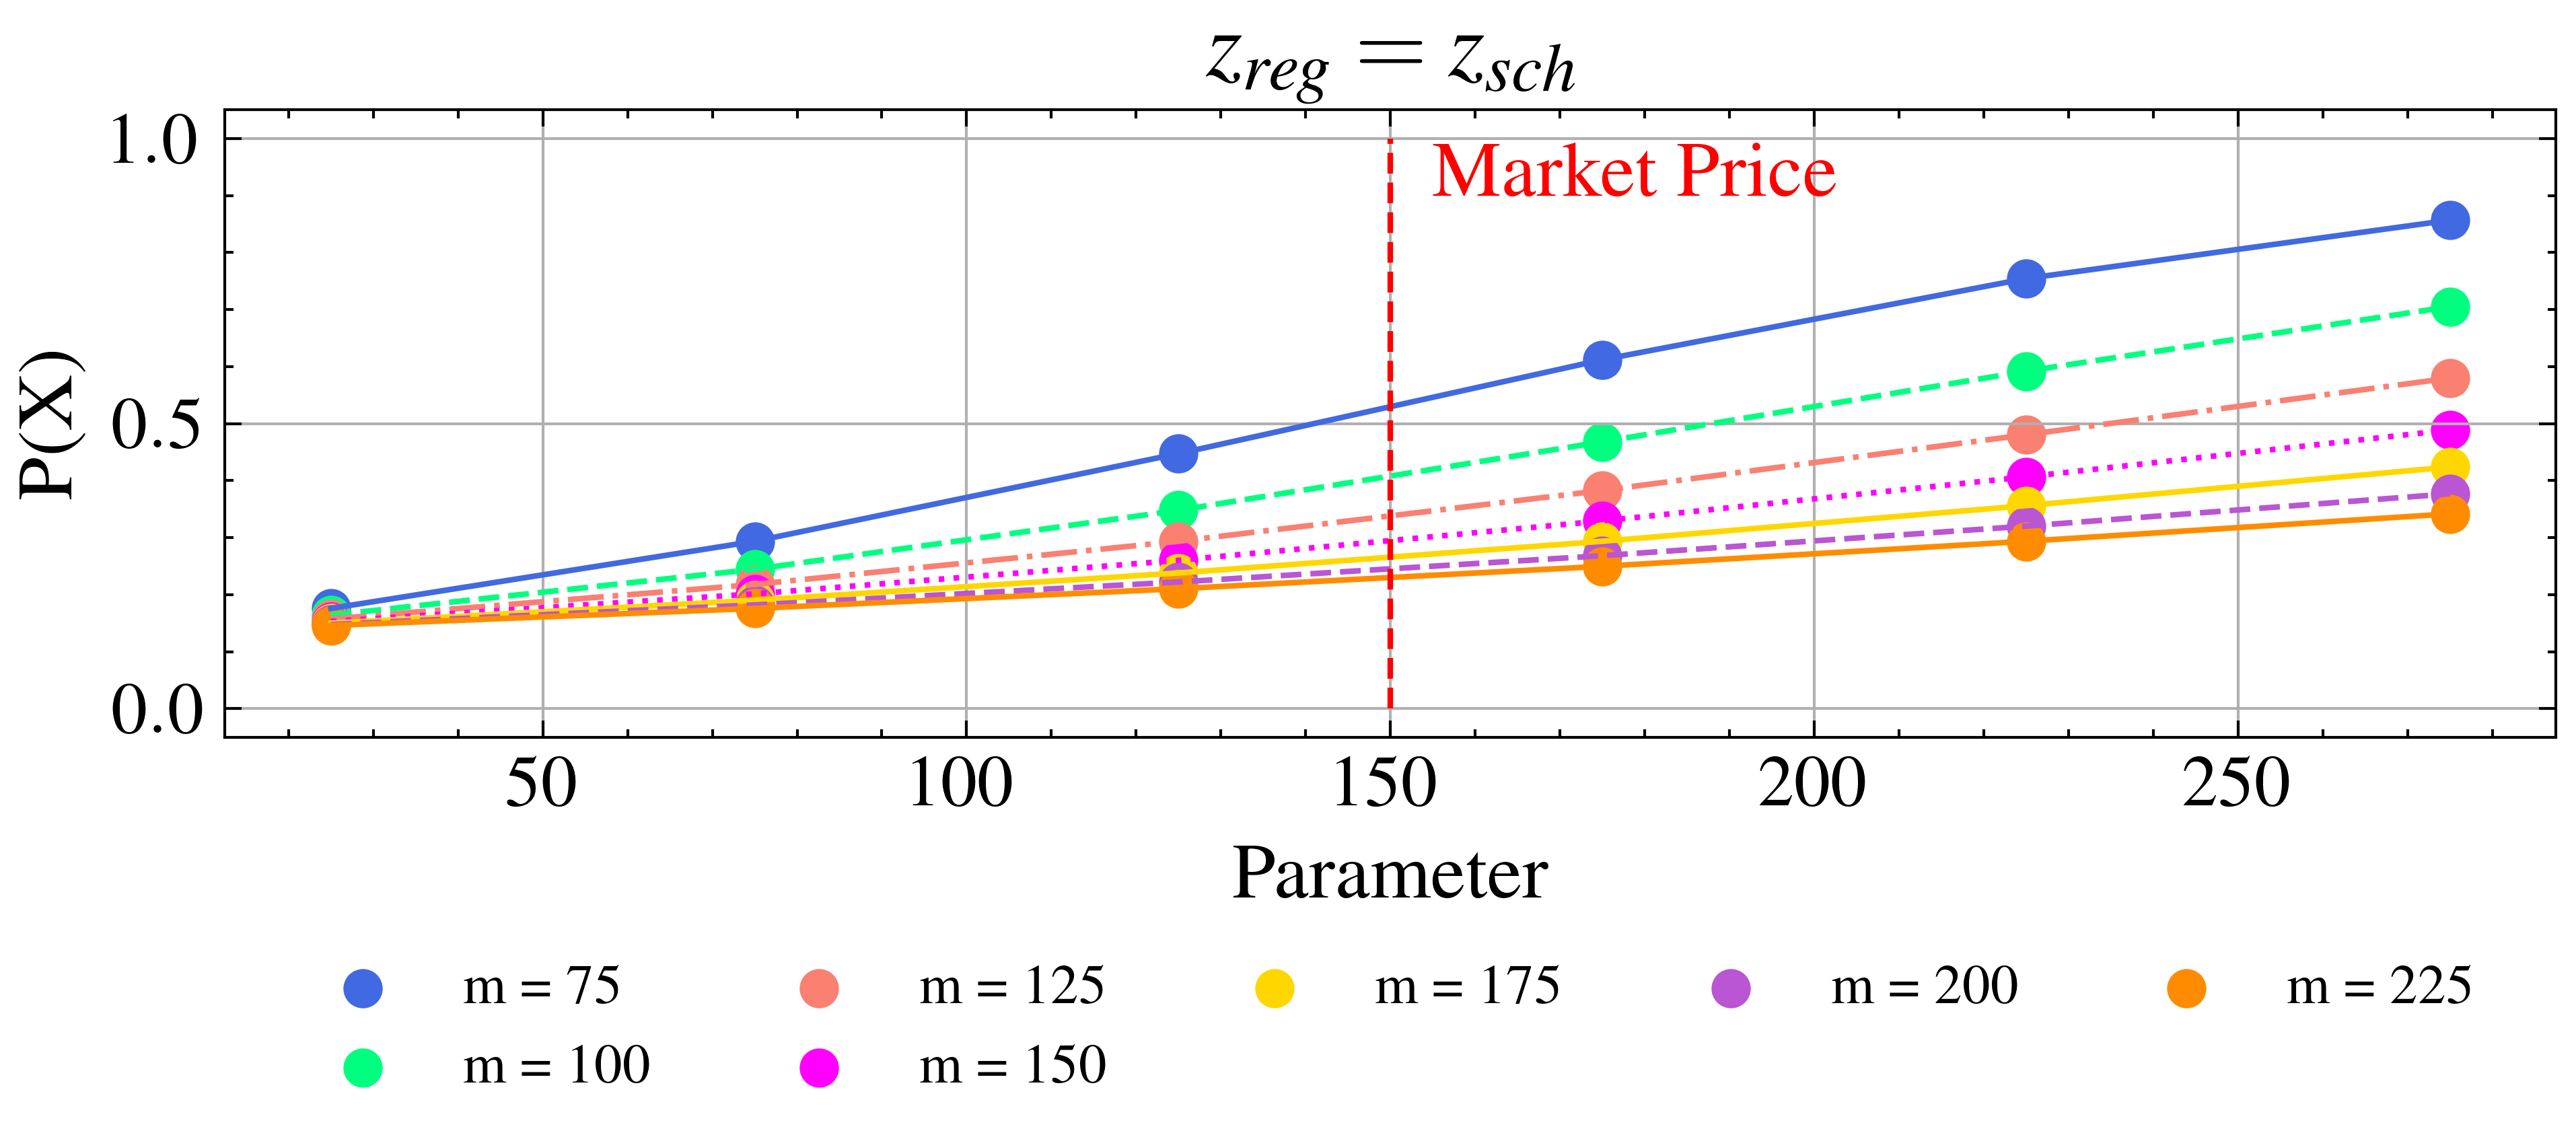

In [5]:
fig,(ax2) = plt.subplots(1,1,figsize=(w,h))

# ax1.scatter(data["mean_x"], data['P_leave'], color = "salmon")
# ax1.set_xlabel("Mean($z_{reg},z_{sch}$)")
# ax1.set_title("$P_{Leave}$")

c_list = ["royalblue", "springgreen", "salmon", "magenta", "gold", "mediumorchid","darkorange"]
ax2.set_ylabel("P(X)")

for i, z in enumerate(i_range):
    ax2.scatter(z_range, p_function_lst[i], color=c_list[i], label = "m = {}".format(z))
    ax2.plot(z_range, p_function_lst[i], color=c_list[i])
    # ax2.scatter(z_range, p_function_lst[2], color="springgreen", label = "slope = 100")
ax2.vlines(150, 0, 1, color = "red", linestyles="dashed")
ax2.text(155,0.9, "Market Price", color = 'red')
# ax2.scatter(tmp["x2s"], tmp['p_flex'], color = "springgreen", label = "SCH")
# ax2.scatter(tmp["x2s"], tmp['P_leave'], color = "salmon", label = "Leave")
ax2.grid()
ax2.set_xlabel("Parameter")
ax2.set_title("$z_{reg}=z_{sch}$")
ax2.legend(loc='lower center',bbox_to_anchor=(0.5, -0.65), ncol=5, fontsize=10)

fig.savefig('Figures/sensitivity_analysis_p_range.pdf', dpi=300)

In [6]:
parameters = [200, -1, 0.0092, 0.341, 0.0092, 0, 30, 35]
parameter_names = ["leave_x_intercept", 
                    "leave_y_intercept",
                    "REG_delta_x_coeff", 
                    "REG_y_intercept",
                    "SCH_delta_x_coeff", 
                    "SCH_y_intercept",
                    "SCH_z_0",
                    "REG_z_0"
                    ]
# df_list = []
default_params = [200, -1, 0.0092, 0.341, 0.0092, 0, 30, 35]
# for val in  [100,150,200,250]: 
#     parameters[0] = val

#     for name, value in zip(parameter_names, parameters):
#         # Iterate over the parameter names and values
#         output_label = ""
#         for name, value in zip(parameter_names, parameters):
#             output_label += f"{name}_{value}-"

#     output_file = output_label + ".pkl"
#     print(output_label)
#     res_path = os.path.join(data_path, "sobol_indice_data","results_"+ output_file)
#     df = pd.read_pickle(res_path)
#     df['Intercept'] = val
#     df_list.append(df)
# df = pd.concat(df_list)
# max_df = df.groupby(['highPower','arrHour']).max()
# min_df = df.groupby(['highPower','arrHour']).min()

# arr = (high_prices['sch_centsPerHr'].values - sch_high_max)
# def errors(default,sim,type):
#     if type=='high':
#         arr = default - sim
#         arr = np.where(arr < 0, 0, arr)

#         var = np.divide(arr,default) * 100
#         print("Max {}, Min {}, Mean {}".format(var.max(), var.min() , var.mean()))
#     if type=='low':
#         arr = sim - default
#         arr = np.where(arr < 0, 0, arr)
        
#         var = np.divide(arr,default) * 100
#         print("Max {}, Min {}, Mean {}".format(var.max(), var.min() , var.mean()))
#     return arr 

# sch_high_max = errors(high_prices['sch_centsPerHr'].values,
#                       max_df.loc[1,'sch_centsPerHr'].values,'high')


# sch_high_min = errors(high_prices['sch_centsPerHr'].values,
#                       min_df.loc[1,'sch_centsPerHr'].values,'low')

# reg_high_max = errors(high_prices['reg_centsPerHr'].values,
#                       max_df.loc[1,'reg_centsPerHr'].values,'high')


# reg_high_min = errors(high_prices['reg_centsPerHr'].values,
#                       min_df.loc[1,'reg_centsPerHr'].values,'low')


# sch_low_max = errors(low_prices['sch_centsPerHr'].values,
#                       max_df.loc[0,'sch_centsPerHr'].values,'high')


# sch_low_min = errors(low_prices['sch_centsPerHr'].values,
#                       min_df.loc[0,'sch_centsPerHr'].values,'low')

# reg_low_max = errors(low_prices['reg_centsPerHr'].values,
#                       max_df.loc[0,'reg_centsPerHr'].values,'high')


# reg_low_min = errors(low_prices['reg_centsPerHr'].values,
# #                       min_df.loc[0,'reg_centsPerHr'].values,'low')



In [7]:

df1 = pd.read_pickle(os.path.join(data_path, "sensitivity_analysis_trial", 'results_all2.pkl'))
df2 = pd.read_pickle(os.path.join(data_path, "sensitivity_analysis_trial", 'results_all3.pkl'))
df3 = pd.read_pickle(os.path.join(data_path, "sensitivity_analysis_trial", 'results_all4.pkl'))
df = pd.concat([df1,df2,df3]).reset_index(drop=True)
df = df.drop_duplicates(subset = ['arrHour','highPower','z_0_reg','z_0_sch','x_intercept'],keep='first')

parameters = list(df['z_0_reg'].unique())

from itertools import combinations_with_replacement
numbers = [20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5]
# Generate combinations of 2 numbers with replacement
combinations_2 = list(combinations_with_replacement(numbers, 2))

for row in df.index:

    _,_, df.loc[row, 'p_leave'] = calculate_probability(df.loc[row,'reg_centsPerHr'],
                                                         df.loc[row,'sch_centsPerHr'],
                                                        leave_intercept = df.loc[row,'x_intercept'], 
                                                        utility_intercept= parameters[1], 
                                                        REG_delta_x_coeff = parameters[2], 
                                                        REG_y_intercept = parameters[3], 
                                                        SCH_delta_x_coeff = parameters[4],
                                                        SCH_y_intercept = parameters[5]) 

df = df.set_index(['arrHour','highPower'])
df['reg_experiment'] = prices['reg_centsPerHr']
df['sch_experiment'] = prices['sch_centsPerHr']
df['reg_diff'] = df['reg_centsPerHr'] - df['reg_experiment']
df['sch_diff'] = df['sch_centsPerHr'] - df['sch_experiment']
df = df.reset_index(drop=False)

df['reg_diff'] = df['reg_diff'].astype(float)
df['sch_diff'] = df['sch_diff'].astype(float)


diff_df = df.groupby(['z_0_reg', 'z_0_sch', 'highPower',"x_intercept"]).mean()
diff_df.sort_values(by=['sch_diff','reg_diff']).head(10)

arrHour           J  p_leave  \
z_0_reg z_0_sch highPower x_intercept                                 
25.0    7.5     1         100             11.5  -26.686609      0.0   
30.0    7.5     1         100             11.5  -53.573481      0.0   
35.0    7.5     1         100             11.5  -80.460353      0.0   
27.5    7.5     1         100             11.5  -40.130045      0.0   
37.5    7.5     1         100             11.5  -92.268531      0.0   
32.5    7.5     1         100             11.5  -67.016917      0.0   
40.0    7.5     1         100             11.5 -107.347224      0.0   
22.5    7.5     1         100             11.5  -13.243173      0.0   
20.0    7.5     1         100             11.5    0.200262      0.0   
17.5    7.5     1         100             11.5   13.643698      0.0   

                                       reg_experiment  sch_experiment  \
z_0_reg z_0_sch highPower x_intercept                                   
25.0    7.5     1         100              233.925525      216.757024   
30.0    7.5     1         100              233.925525      216.757024   
35.0    7.5     1         100              233.925525      216.757024   
27.5    7.5     1         100              233.925525      216.757024   
37.5    7.5     1         100              233.925525      216.757024   
32.5    7.5     1         100              233.925525      216.757024   
40.0    7.5     1         100              233.925525      216.757024   
22.5    7.5     1         100              233.925525      216.757024   
20.0    7.5     1         100              233.925525      216.757024   
17.5    7.5     1         100              233.925525      216.757024   

                                         reg_diff    sch_diff  
z_0_reg z_0_sch highPower x_intercept                          
25.0    7.5     1         100          -65.567153 -162.499367  
30.0    7.5     1         100          -32.518968 -162.426123  
35.0    7.5     1         100            0.579365 -162.411704  
27.5    7.5     1         100          -48.982007 -162.409311  
37.5    7.5     1         100           15.777147 -162.405747  
32.5    7.5     1         100          -15.949667 -162.393765  
40.0    7.5     1         100           33.866271 -162.331475  
22.5    7.5     1         100          -81.769404 -162.285850  
20.0    7.5     1         100          -97.945311 -162.032470  
17.5    7.5     1         100         -114.088971 -161.761611

In [ ]:
# ax = df[(df['highPower']==1) & 
#         (df['x_intercept']==250) & 
#         (df['z_0_reg']==35) &
#          (df['z_0_sch']==32.5) ].plot.scatter(x='arrHour',y='reg_centsPerHr', figsize=(6, 2))
# ax.set_ylim(70,260)
# ax.plot(arrHour, high_prices['reg_centsPerHr'].values, color=high_vis_map[4], label = 'REGULAR Tariff',marker ='X',linestyle = "--")
# ax.plot(np.arange(0,24,0.25), high_TOU, label = 'TOU Cost', ms=0,marker ='X',
#                 linestyle = "--")


# # ax = df[(df['highPower']==1) & 
# #         (df['x_intercept']==200) & 
# #         (df['z_0_reg']==37.5) &
# #          (df['z_0_sch']==32.5) ].plot.scatter(x='arrHour',y='sch_centsPerHr', figsize=(6, 2))


# ax = df[(df['highPower']==1) & 
#         (df['x_intercept']==200) & 
#         (df['z_0_reg']==35) &
#          (df['z_0_sch']==32.5) ].plot.scatter(x='arrHour',y='sch_centsPerHr', figsize=(6, 2))
# ax.set_ylim(70,260)
# ax.plot(arrHour, high_prices['sch_centsPerHr'].values, color=high_vis_map[4], label = 'SCHEDULED Tariff',marker ='X',linestyle = "--")
# ax.plot(np.arange(0,24,0.25), high_TOU, label = 'TOU Cost', ms=0,marker ='X',
#                 linestyle = "--")

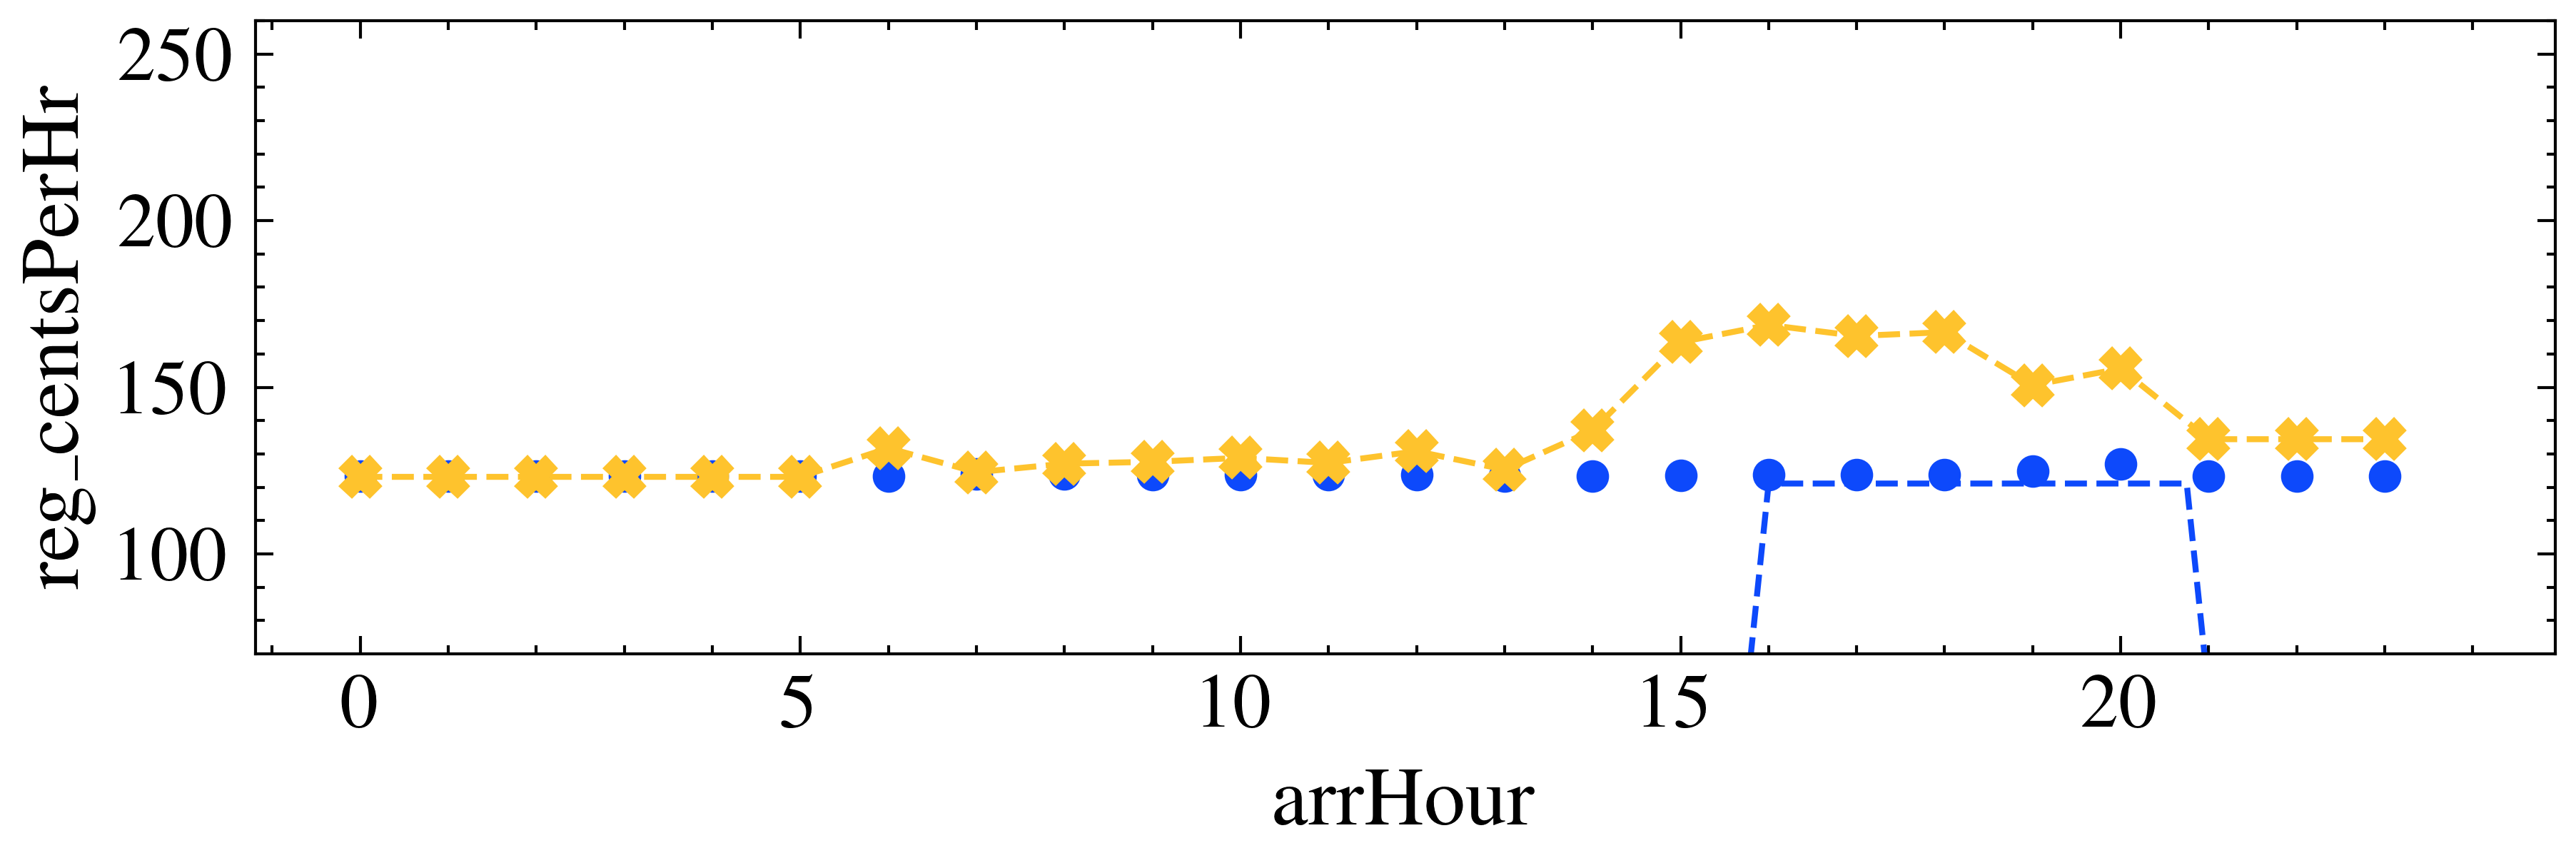

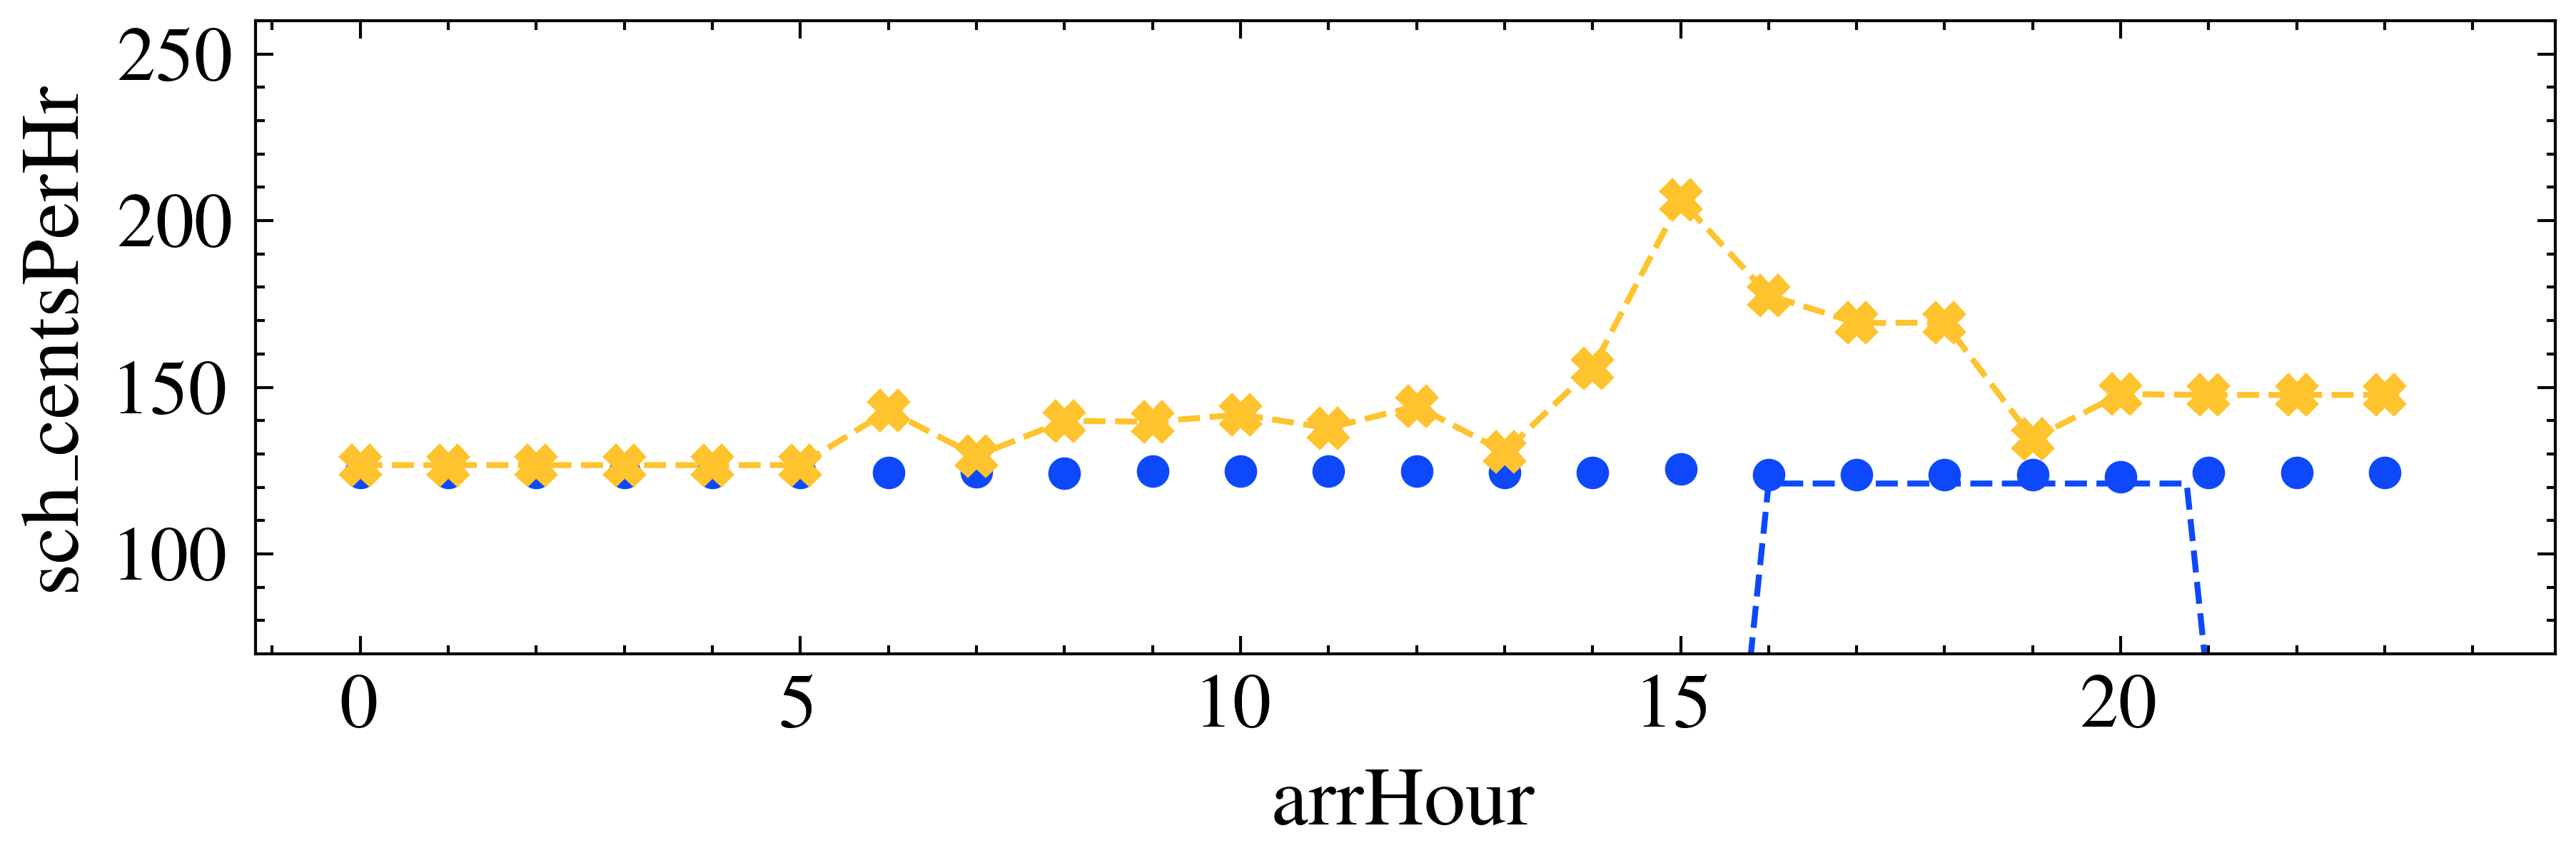

In [ ]:
ax = df[(df['highPower']==0) & 
        (df['x_intercept']==250) & 
        (df['z_0_reg']==37.5) &
         (df['z_0_sch']==37.5) ].plot.scatter(x='arrHour',y='reg_centsPerHr', figsize=(6, 2))
ax.set_ylim(70,260)
ax.plot(arrHour, low_prices['reg_centsPerHr'].values, color=high_vis_map[4], label = 'REGULAR Tariff',marker ='X',linestyle = "--")
ax.plot(np.arange(0,24,0.25), low_TOU, label = 'TOU Cost', ms=0,marker ='X',
                linestyle = "--")


ax = df[(df['highPower']==0) & 
        (df['x_intercept']==250) & 
        (df['z_0_reg']==37.5) &
         (df['z_0_sch']==37.5) ].plot.scatter(x='arrHour',y='sch_centsPerHr', figsize=(6, 2))
ax.set_ylim(70,260)
ax.plot(arrHour, low_prices['sch_centsPerHr'].values, color=high_vis_map[4], label = 'SCHEDULED Tariff',marker ='X',linestyle = "--")
ax.plot(np.arange(0,24,0.25), low_TOU, label = 'TOU Cost', ms=0,marker ='X',
                linestyle = "--")

In [ ]:
df[(df['x_intercept'] == 100)].groupby(['z_0_reg','z_0_sch','highPower']).mean()

arrHour           J  x_intercept        p_leave  \
z_0_reg z_0_sch highPower                                                    
7.5     7.5     0             11.5   27.365259        100.0   3.548848e-05   
                1             11.5   67.417442        100.0   2.712466e-05   
10.0    7.5     0             11.5   22.385010        100.0  7.652222e-109   
                1             11.5   53.974006        100.0  1.396653e-226   
        10.0    0             11.5   22.385010        100.0   4.604167e-05   
...                            ...         ...          ...            ...   
42.5    37.5    1             11.5 -120.946734        100.0   0.000000e+00   
        40.0    0             11.5  -75.409219        100.0   1.048534e-07   
                1             11.5 -119.288616        100.0   1.839641e-07   
        42.5    0             11.5  -79.333657        100.0   1.048536e-07   
                1             11.5 -120.831535        100.0   6.298082e-08   

                           reg_experiment  sch_experiment    reg_diff  \
z_0_reg z_0_sch highPower                                               
7.5     7.5     0              136.354770      144.596084 -104.082286   
                1              233.925525      216.757024 -177.427182   
10.0    7.5     0              136.354770      144.596084  -96.328195   
                1              233.925525      216.757024 -161.363141   
        10.0    0              136.354770      144.596084  -96.014127   
...                                   ...             ...         ...   
42.5    37.5    1              233.925525      216.757024   46.603669   
        40.0    0              136.354770      144.596084    1.246056   
                1              233.925525      216.757024   42.859859   
        42.5    0              136.354770      144.596084    3.345736   
                1              233.925525      216.757024   47.077014   

                             sch_diff  
z_0_reg z_0_sch highPower              
7.5     7.5     0         -112.291576  
                1         -160.255367  
10.0    7.5     0         -112.304378  
                1         -160.272801  
        10.0    0         -104.228575  
...                               ...  
42.5    37.5    1           30.924637  
        40.0    0          -11.959811  
                1           46.904336  
        42.5    0           -4.350274  
                1           64.193660  

[224 rows x 8 columns]

In [ ]:
### x_intercept = 100 
df100 = df[(df['x_intercept'] == 100) & (df['z_0_reg'] == 27.5) & (df['z_0_sch'] == 25)]
print("Mean P_leave:", df100['p_leave'].mean())
print("Mean z_reg:", df100['reg_centsPerHr'].mean())
print("Mean z_sch:", df100['sch_centsPerHr'].mean())
print(" ")

### x_intercept = 125
df125 = df[(df['x_intercept'] == 125) & (df['z_0_reg'] == 27.5) & (df['z_0_sch'] == 27.5)]
print("Mean P_leave:", df125['p_leave'].mean())
print("Mean z_reg:", df125['reg_centsPerHr'].mean())
print("Mean z_sch:", df125['sch_centsPerHr'].mean())
print(" ")

### x_intercept = 150
df150 = df[(df['x_intercept'] == 150) & (df['z_0_reg'] == 32.5) & (df['z_0_sch'] == 30)]
print("Mean P_leave:", df150['p_leave'].mean())
print("Mean z_reg:", df150['reg_centsPerHr'].mean())
print("Mean z_sch:", df150['sch_centsPerHr'].mean())
print(" ")

### x_intercept = 175
df175 = df[(df['x_intercept'] == 175) & (df['z_0_reg'] == 32.5) & (df['z_0_sch'] == 32.5)]
print("Mean P_leave:", df175['p_leave'].mean())
print("Mean z_reg:", df175['reg_centsPerHr'].mean())
print("Mean z_sch:", df175['sch_centsPerHr'].mean())
print(" ")

### x_intercept = 200 
df200 = df[(df['x_intercept'] == 200) & (df['z_0_reg'] == 35) & (df['z_0_sch'] == 35)]
print("Mean P_leave:", df200['p_leave'].mean())
print("Mean z_reg:", df200['reg_centsPerHr'].mean())
print("Mean z_sch:", df200['sch_centsPerHr'].mean())
print(" ")

### x_intercept = 225 
df225 = df[(df['x_intercept'] == 225) & (df['z_0_reg'] == 37.5) & (df['z_0_sch'] == 37.5)]
print("Mean P_leave:", df225['p_leave'].mean())
print("Mean z_reg:", df225['reg_centsPerHr'].mean())
print("Mean z_sch:", df225['sch_centsPerHr'].mean())
print(" ")

### x_intercept = 250 
df250 = df[(df['x_intercept'] == 250) & (df['z_0_reg'] ==40 ) & (df['z_0_sch'] == 37.5)]
print("Mean P_leave:", df250['p_leave'].mean())
print("Mean z_reg:", df250['reg_centsPerHr'].mean())
print("Mean z_sch:", df250['sch_centsPerHr'].mean())
print(" ")

sim_prices_df = pd.concat([df100, df125, df150, df175,df200, df225, df250])


max_df = sim_prices_df.groupby(by=['highPower','arrHour']).max()
min_df =  sim_prices_df.groupby(by=['highPower','arrHour']).min()
sim_prices_df = sim_prices_df.set_index(['highPower','arrHour'])

Mean P_leave: 2.427534319138531e-12
Mean z_reg: 137.55168710142433
Mean z_sch: 127.20508976902103
 
Mean P_leave: 3.380866575740718e-05
Mean z_reg: 140.11966659720875
Mean z_sch: 140.5128174639615
 
Mean P_leave: 2.957715271603843e-13
Mean z_reg: 163.22330544712392
Mean z_sch: 152.33311149037715
 
Mean P_leave: 7.732825645996047e-06
Mean z_reg: 165.014147379752
Mean z_sch: 164.53036856755435
 
Mean P_leave: 1.207164060018133e-06
Mean z_reg: 176.5532914092089
Mean z_sch: 176.92058459109796
 
Mean P_leave: 2.708255781027782e-07
Mean z_reg: 186.87432618118112
Mean z_sch: 188.00678550770616
 
Mean P_leave: 3.6844537970177833e-13
Mean z_reg: 198.06711144367713
Mean z_sch: 188.35815845353454
 


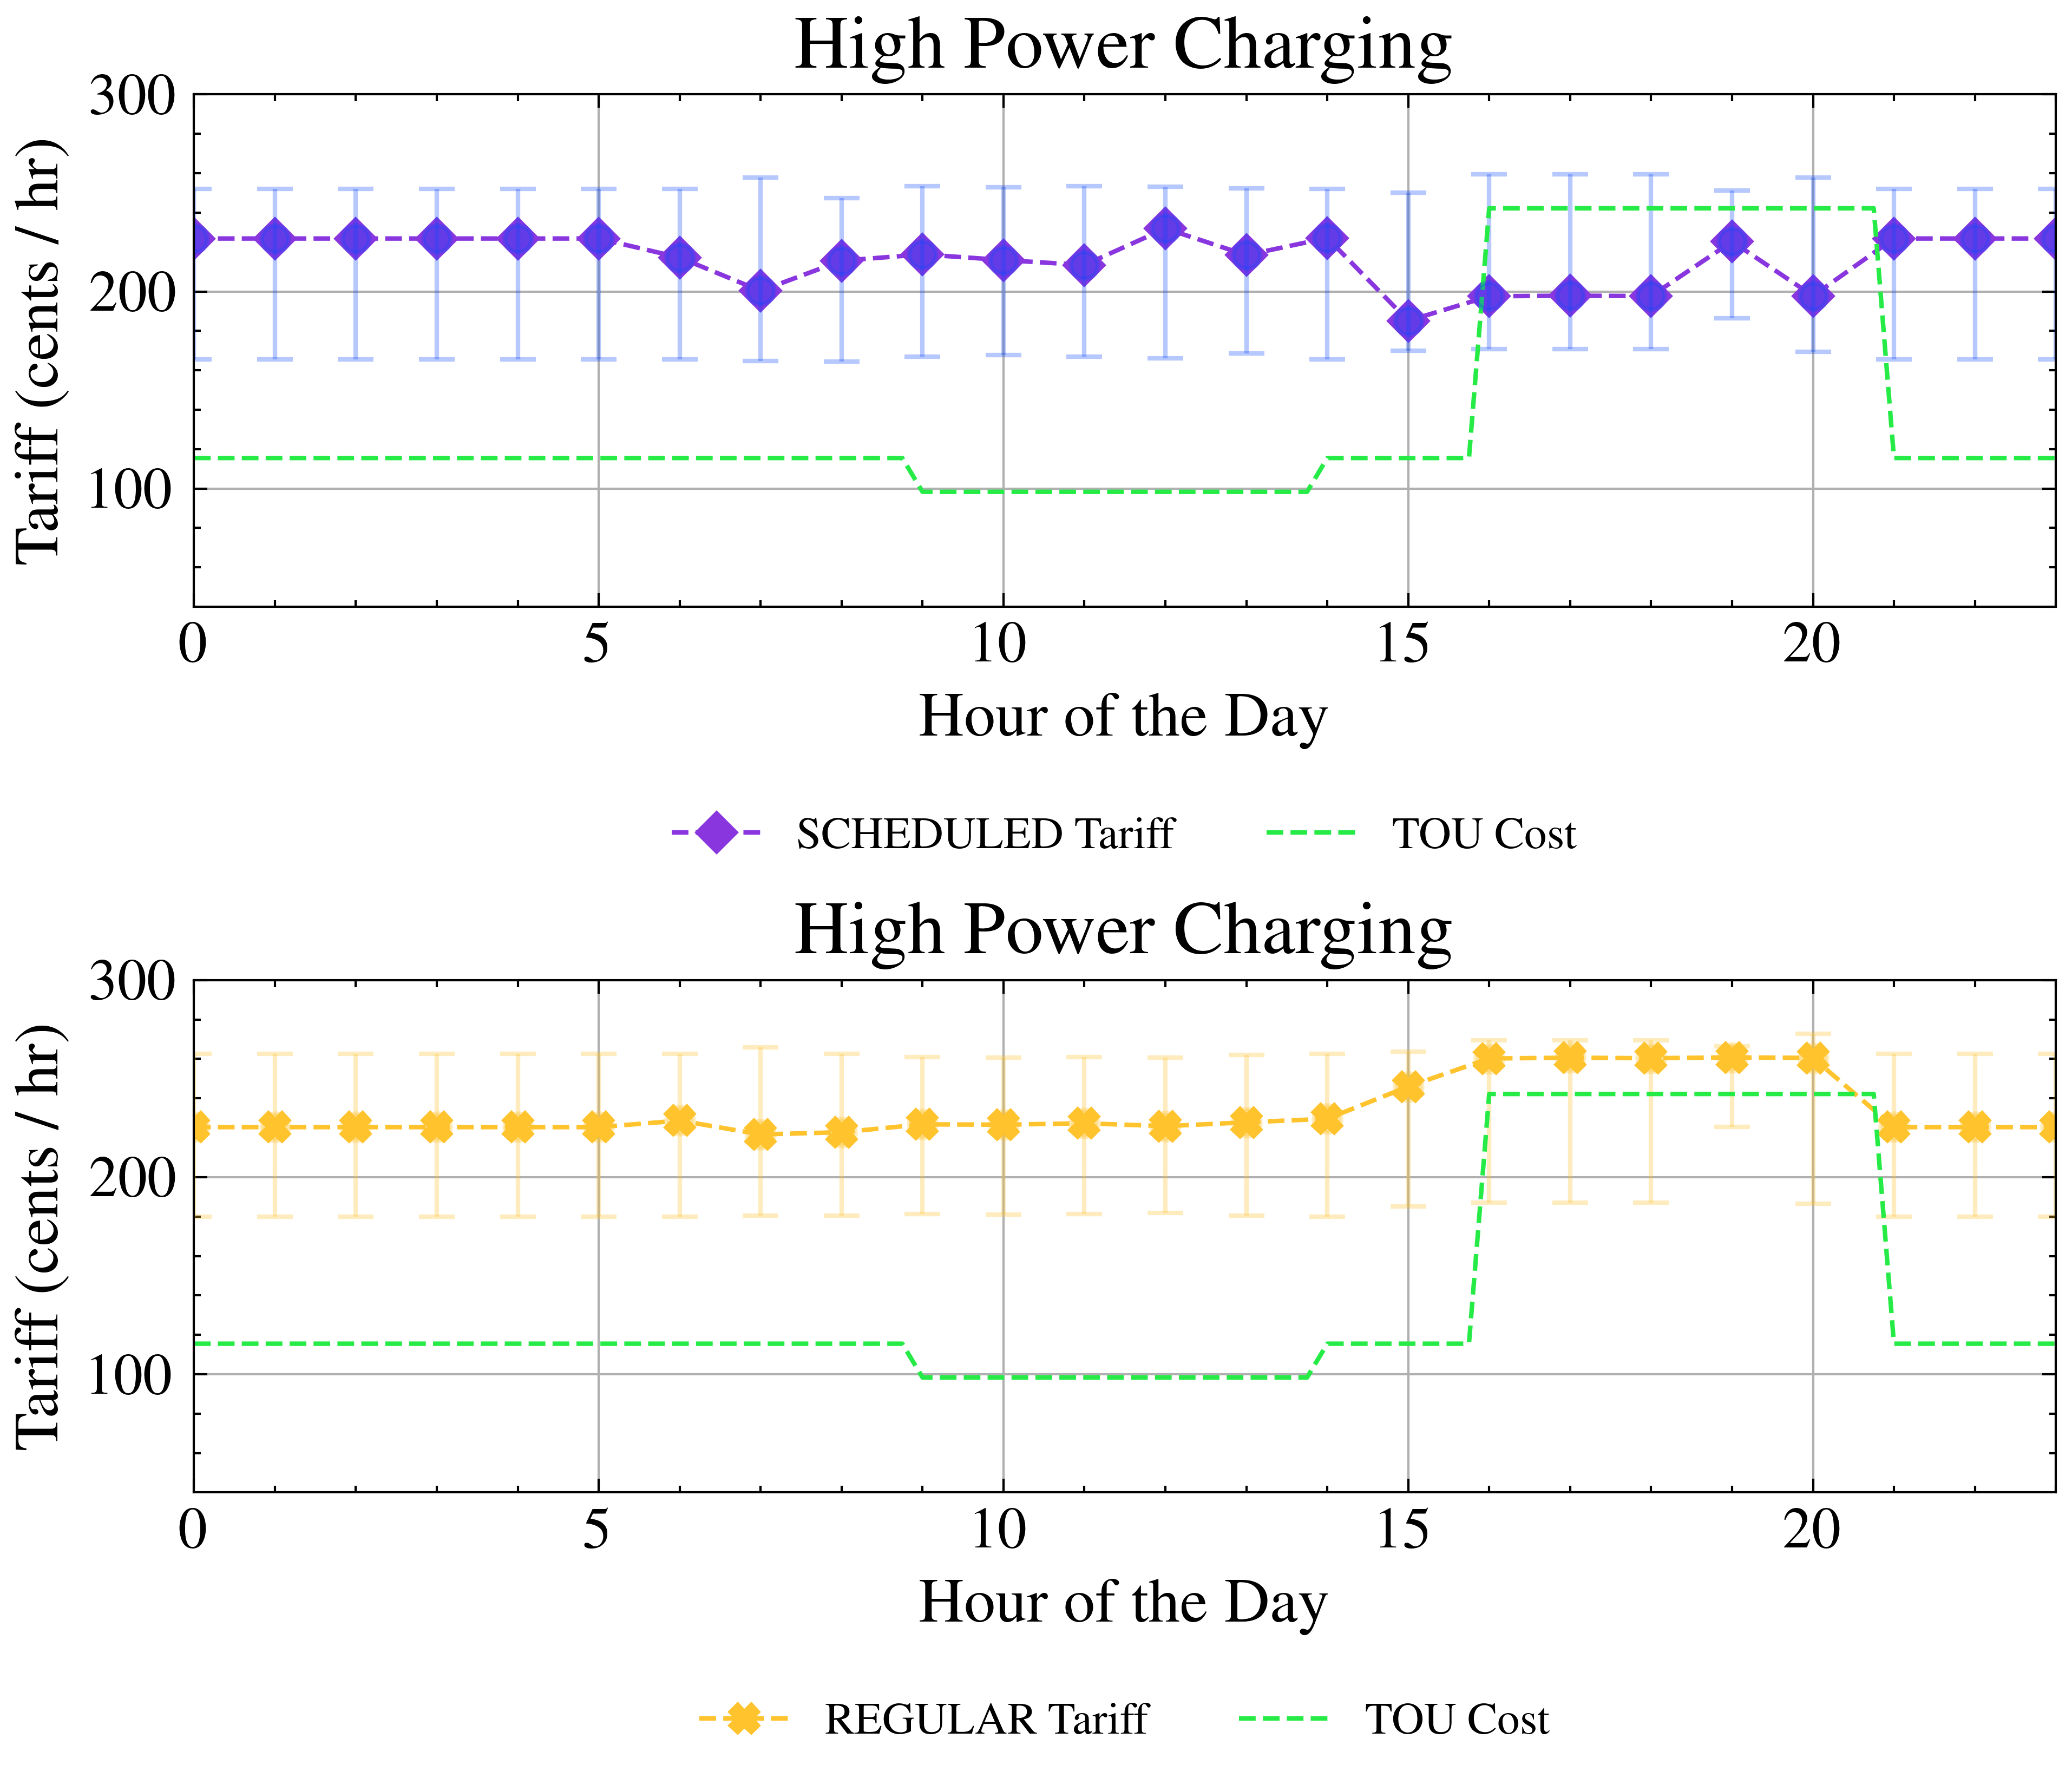

In [ ]:

## Plot initial guess vs optimization result 
fig, (ax, ax1)= plt.subplots(2,1,figsize=(w,h * 2))
# Objective Value for each iteration 

arrHour = high_prices['arrHour'].values
ax.plot(arrHour, high_prices['sch_centsPerHr'].values, 
        label = 'SCHEDULED Tariff', 
        marker = 'D',
        linestyle = "--",color=high_vis_map[3])

ax.errorbar(arrHour, high_prices['sch_centsPerHr'].values, yerr=[min_df.loc[1,'sch_diff'].values * (-1),max_df.loc[1,'sch_diff'].values], fmt='o', capsize=4, alpha=0.3)


ax1.plot(arrHour, high_prices['reg_centsPerHr'].values, color=high_vis_map[4], label = 'REGULAR Tariff',marker ='X',linestyle = "--")

ax1.errorbar(arrHour, high_prices['reg_centsPerHr'].values, yerr=[min_df.loc[1,'reg_diff'].values * (-1) , max_df.loc[1,'reg_diff'].values], fmt='o', capsize=4, alpha=0.3, color=high_vis_map[4])



for ax_all in [ax,ax1]:
        ax_all.plot(np.arange(0,24,0.25), high_TOU, label = 'TOU Cost', ms=0,marker ='X',
                linestyle = "--",
        color=high_vis_map[2])
        ax_all.set_ylim(40,300)
        ax_all.set_xlim(0,23)
        ax_all.grid()
        ax_all.set_title("High Power Charging")
        ax_all.set_xlabel("Hour of the Day")
        ax_all.set_ylabel("Tariff (cents / hr)")
        # ax.set_title("Objective Value")
        # ax.legend(loc = 0)
        ax_all.legend(bbox_to_anchor=(0.5, -0.45), loc='center', ncol=3,fontsize=10)

fig.savefig('Figures/sensitivity_analysis_h_prices.pdf', dpi=300)



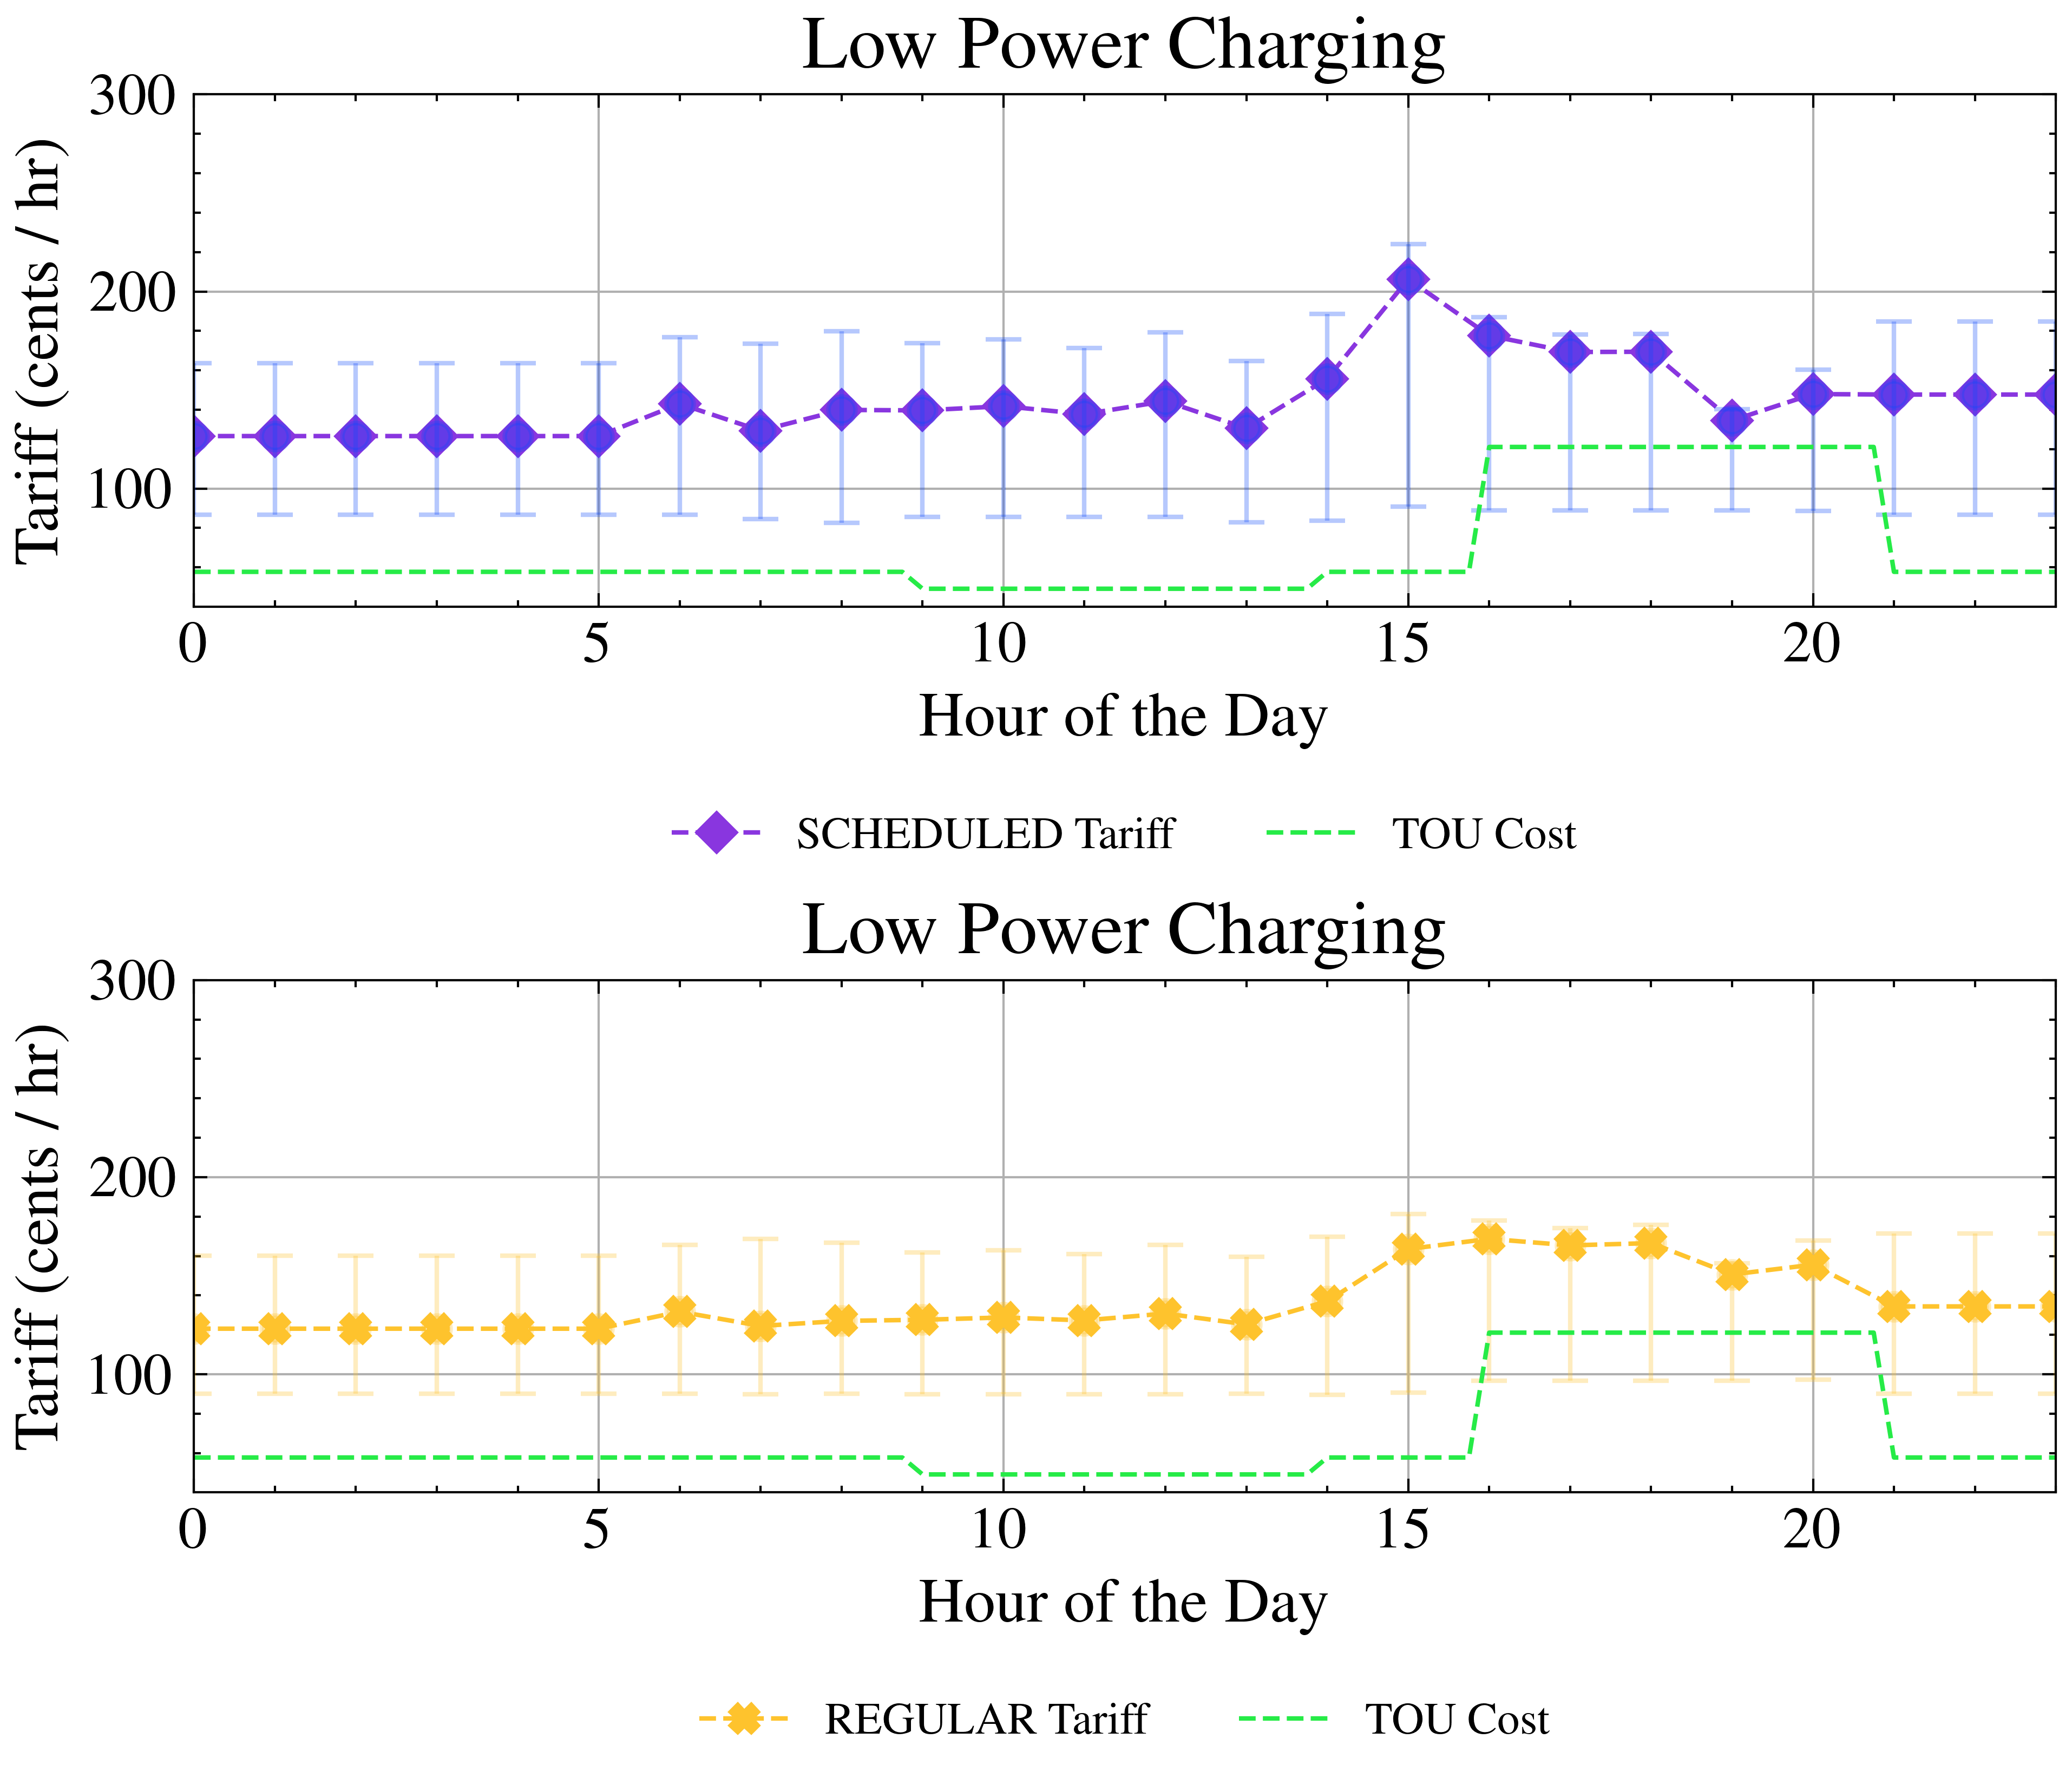

In [11]:

## Plot initial guess vs optimization result 
fig, (ax, ax1)= plt.subplots(2,1,figsize=(w,h * 2))
# Objective Value for each iteration 

arrHour = high_prices['arrHour'].values
ax.plot(arrHour,low_prices['sch_centsPerHr'].values, 
        label = 'SCHEDULED Tariff', 
        marker = 'D',
        linestyle = "--",color=high_vis_map[3])

ax.errorbar(arrHour, low_prices['sch_centsPerHr'].values, yerr=[min_df.loc[0,'sch_diff'].values * (-1),max_df.loc[1,'reg_diff'].values], fmt='o', capsize=4, alpha=0.3)


ax1.plot(arrHour, low_prices['reg_centsPerHr'].values, color=high_vis_map[4], label = 'REGULAR Tariff',marker ='X',linestyle = "--")

ax1.errorbar(arrHour, low_prices['reg_centsPerHr'].values, yerr=[min_df.loc[0,'reg_diff'].values * (-1), max_df.loc[1,'reg_diff'].values], fmt='o', capsize=4, alpha=0.3, color=high_vis_map[4])


for ax_all in [ax,ax1]:
        ax_all.plot(np.arange(0,24,0.25), low_TOU, label = 'TOU Cost', ms=0,marker ='X',
                linestyle = "--",
        color=high_vis_map[2])
        ax_all.set_ylim(40,300)
        ax_all.set_xlim(0,23)
        ax_all.grid()
        ax_all.set_title("Low Power Charging")
        ax_all.set_xlabel("Hour of the Day")
        ax_all.set_ylabel("Tariff (cents / hr)")
        # ax.set_title("Objective Value")
        # ax.legend(loc = 0)
        ax_all.legend(bbox_to_anchor=(0.5, -0.45), loc='center', ncol=3,fontsize=10)

fig.savefig('Figures/sensitivity_analysis_l_prices.pdf', dpi=300)

In [8]:
df1 = pd.read_pickle(os.path.join(data_path, "sensitivity_analysis_trial", 'power_schedule_all2.pkl'))
df2 = pd.read_pickle(os.path.join(data_path, "sensitivity_analysis_trial", 'power_schedule_all3.pkl'))
df3 = pd.read_pickle(os.path.join(data_path, "sensitivity_analysis_trial", 'power_schedule_all4.pkl'))
df_pow = pd.concat([df1,df2,df3])
df_pow= df_pow.drop_duplicates(subset = ['arrHour','highPower','z_0_reg','z_0_sch','x_intercept'],keep='first')


### x_intercept = 100
df_pow100 = df_pow[(df_pow['x_intercept'] == 100) & (df_pow['z_0_reg'] == 35) & (df_pow['z_0_sch'] == 22.5)]

### x_intercept = 125
df_pow125 = df_pow[(df_pow['x_intercept'] == 125) & (df_pow['z_0_reg'] == 35) & (df_pow['z_0_sch'] == 25)]

### x_intercept = 150
df_pow150 = df_pow[(df_pow['x_intercept'] == 150) & (df_pow['z_0_reg'] == 35) & (df_pow['z_0_sch'] == 27.5)]

### x_intercept = 175
df_pow175 = df_pow[(df_pow['x_intercept'] == 175) & (df_pow['z_0_reg'] == 35) & (df_pow['z_0_sch'] == 27.5)]

### x_intercept = 200
df_pow200 = df_pow[(df_pow['x_intercept'] == 200) & (df_pow['z_0_reg'] == 35) & (df_pow['z_0_sch'] == 35)]
### x_intercept = 225
df_pow225 = df_pow[(df_pow['x_intercept'] == 225) & (df_pow['z_0_reg'] == 37.5) & (df_pow['z_0_sch'] == 37.5)]


### x_intercept = 250
df_pow250 = df_pow[(df_pow['x_intercept'] == 250) & (df_pow['z_0_reg'] ==40) & (df_pow['z_0_sch'] == 37.5)]

powers = pd.concat([df_pow100, df_pow125, df_pow150, df_pow175,df_pow200, df_pow225, df_pow250])

powers = powers.set_index(['arrHour','highPower','x_intercept'])

In [9]:
x_intercept = [100, 125, 150,175, 200, 225, 250]

parameters = [200, -1, 0.0092, 0.341, 0.0092, 0, 30, 35]
parameter_names = ["leave_x_intercept", 
                    "leave_y_intercept",
                    "REG_delta_x_coeff", 
                    "REG_y_intercept",
                    "SCH_delta_x_coeff", 
                    "SCH_y_intercept",
                    "SCH_z_0",
                    "REG_z_0"
                    ]
# df_list = []
default_params = [200, -1, 0.0092, 0.341, 0.0092, 0, 30, 35]

#### STORE SIMULTION STATS DATA HERE 
sim_names = sim_names = ["xIntercept_{}_sim_{}".format(k,i) for k,i in product(x_intercept,range(1,20))]
sim_names = list(np.unique(np.array(sim_names)))

sim_start_ts = sessions['connectTime'].min().replace(minute=0,second=0)
sim_end_ts = phase3_end 
sim_data = pd.DataFrame(index = pd.date_range(sim_start_ts , sim_end_ts, freq='15min'))

sim_stats_df = pd.DataFrame(index = sim_names, columns = ['Revenue (cents)',
                                                          'Cost (cents)',
                                                          'LEAVE_count',
                                                          'SCH_count'])
sim_powers_df = pd.DataFrame(index = pd.date_range(sim_start_ts , sim_end_ts, freq='15min'), 
                             columns = sim_names)
sim_powers_df = sim_powers_df.fillna(0)


###### TOU 
TOU_tariff = TOU_15min()
for i, timestamp in enumerate(sim_data.index):
    time_index = (timestamp.time().hour * 4) + (timestamp.time().minute // 15)
    sim_powers_df.loc[timestamp, "TOU Tariff (cents/kWH)"] = TOU_tariff[time_index]



#### LOOOOP 
for x in x_intercept: 
    for sim_num in range(1,20):
        output_label = "xIntercept_{}_sim_{}".format(x,sim_num)
        ### THIS NUMBER IS BASED ON THE LEAVE PROBABILITY -- > WE OBSERVED 136 SESSIONS AT 0.33 LEAVE RATE THEN WE ADD 136 * 0.33 SESSIONS WITH THE MEAN STATISTICS 
        rate, count = sample_sessions(sessions, 45)
        row_list = [sessions]
        for cnt in range(len(count)):
            row_list.append(sessions[(sessions['arrHour'] == count.loc[cnt,'arrHour']) & (sessions['highPower'] == count.loc[cnt,'highPower'])].sample(n=count.loc[cnt,'choice'], replace=True))
        sessions_augmented = pd.concat(row_list)
        sessions_augmented  = sessions_augmented.reset_index(drop=False)

        assert len(sessions_augmented) == len(sessions) + 45, "Size mismatch"
        
        revenue = 0
        leave = 0
        sch_choices = 0

        for row in sessions_augmented.index:

            user = sessions_augmented.loc[row,'userId']
            highPower = int(user_maxChgRate.loc[user,'peakPower_W'] / 1000 > 5 )
            arrHour = sessions_augmented.loc[row,'connectTime'].hour
            duration = powers.loc[(arrHour,highPower,x),'estDurationHrs']

            REG = powers.loc[(arrHour,highPower,x),'reg_centsPerHr' ]
            SCH = powers.loc[(arrHour,highPower,x),'sch_centsPerHr' ]
            parameters = default_params[:]
            parameters[0] = x
            choice_sim = monte_carlo_sim_choice(REG,SCH,parameters)
            
            if choice_sim != 'LEAVE':
                if choice_sim == 'SCH':
                    sch_choices += 1
                
                power = json.loads(powers.loc[(arrHour,highPower,x),choice_sim.lower()+'_power_kw'])
                tariff = powers.loc[(arrHour,highPower,x),choice_sim.lower()+'_centsPerHr']

                revenue += tariff * duration 
                start_ts =  sessions_augmented.loc[row,'connectTime'].replace(minute=0,second=0)
                session_idx = pd.date_range(start_ts, periods=len(power),freq='15min')
                session = pd.DataFrame(index = session_idx, data = {'power_kW':power, "TOU":TOU_tariff[arrHour * 4: (arrHour * 4) + len(power)]})
                sim_powers_df.loc[session_idx, output_label]  = sim_powers_df.loc[session_idx, output_label].fillna(0) + session.loc[session_idx,'power_kW']
            else:
    
                # print(choice_sim)
                leave += 1
                _,_,p_leave = calculate_probability(REG,SCH,
                                                    leave_intercept = x, 
                                                    utility_intercept= parameters[1], 
                                                    REG_delta_x_coeff = parameters[2], 
                                                    REG_y_intercept = parameters[3], 
                                                    SCH_delta_x_coeff = parameters[4],
                                                    SCH_y_intercept = parameters[5])
                # print("Leave prob: {}".format(p_leave))
                # leave_list.append(dcosId)
                
                
        sim_stats_df.loc[output_label,'Revenue (cents)'] = revenue
        sim_stats_df.loc[output_label,'LEAVE_count'] = leave
        sim_stats_df.loc[output_label,'SCH_count'] = sch_choices
        sim_stats_df.loc[output_label,'x_intercept'] = x

        total_cost = sim_powers_df.loc[:,output_label] * sim_powers_df.loc[:,'TOU Tariff (cents/kWH)'] * 0.25 
        sim_stats_df.loc[output_label,'Cost (cents)'] = total_cost.sum()
# [monte_carlo_sim_choice(sessions.loc[dcosId,'reg_centsPerHr'],sessions.loc[dcosId,'sch_centsPerHr'],leaveIntercept = 100) for dcosId in sessions.index]

sim_stats_df['Net Revenue (cents)'] = sim_stats_df['Revenue (cents)'] - sim_stats_df['Cost (cents)']
if 'sim_name' not in sim_stats_df.columns: 
    sim_stats_df = sim_stats_df.reset_index(drop=False)
    sim_stats_df = sim_stats_df.rename(columns={'index': 'sim_name'})
    sim_stats_df[['Net Revenue (cents)','Revenue (cents)', 'Cost (cents)']] = ( sim_stats_df[['Net Revenue (cents)','Revenue (cents)', 'Cost (cents)']] / 100 ) / 31


# Iterate over the parameter names and values

In [10]:
plt.style.use(['science','ieee','high-vis'])
plt.rcParams['font.size'] = 14
w = 7/1.1
h = 3/1.1

high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
matplotlib.rc('axes', labelsize=14)

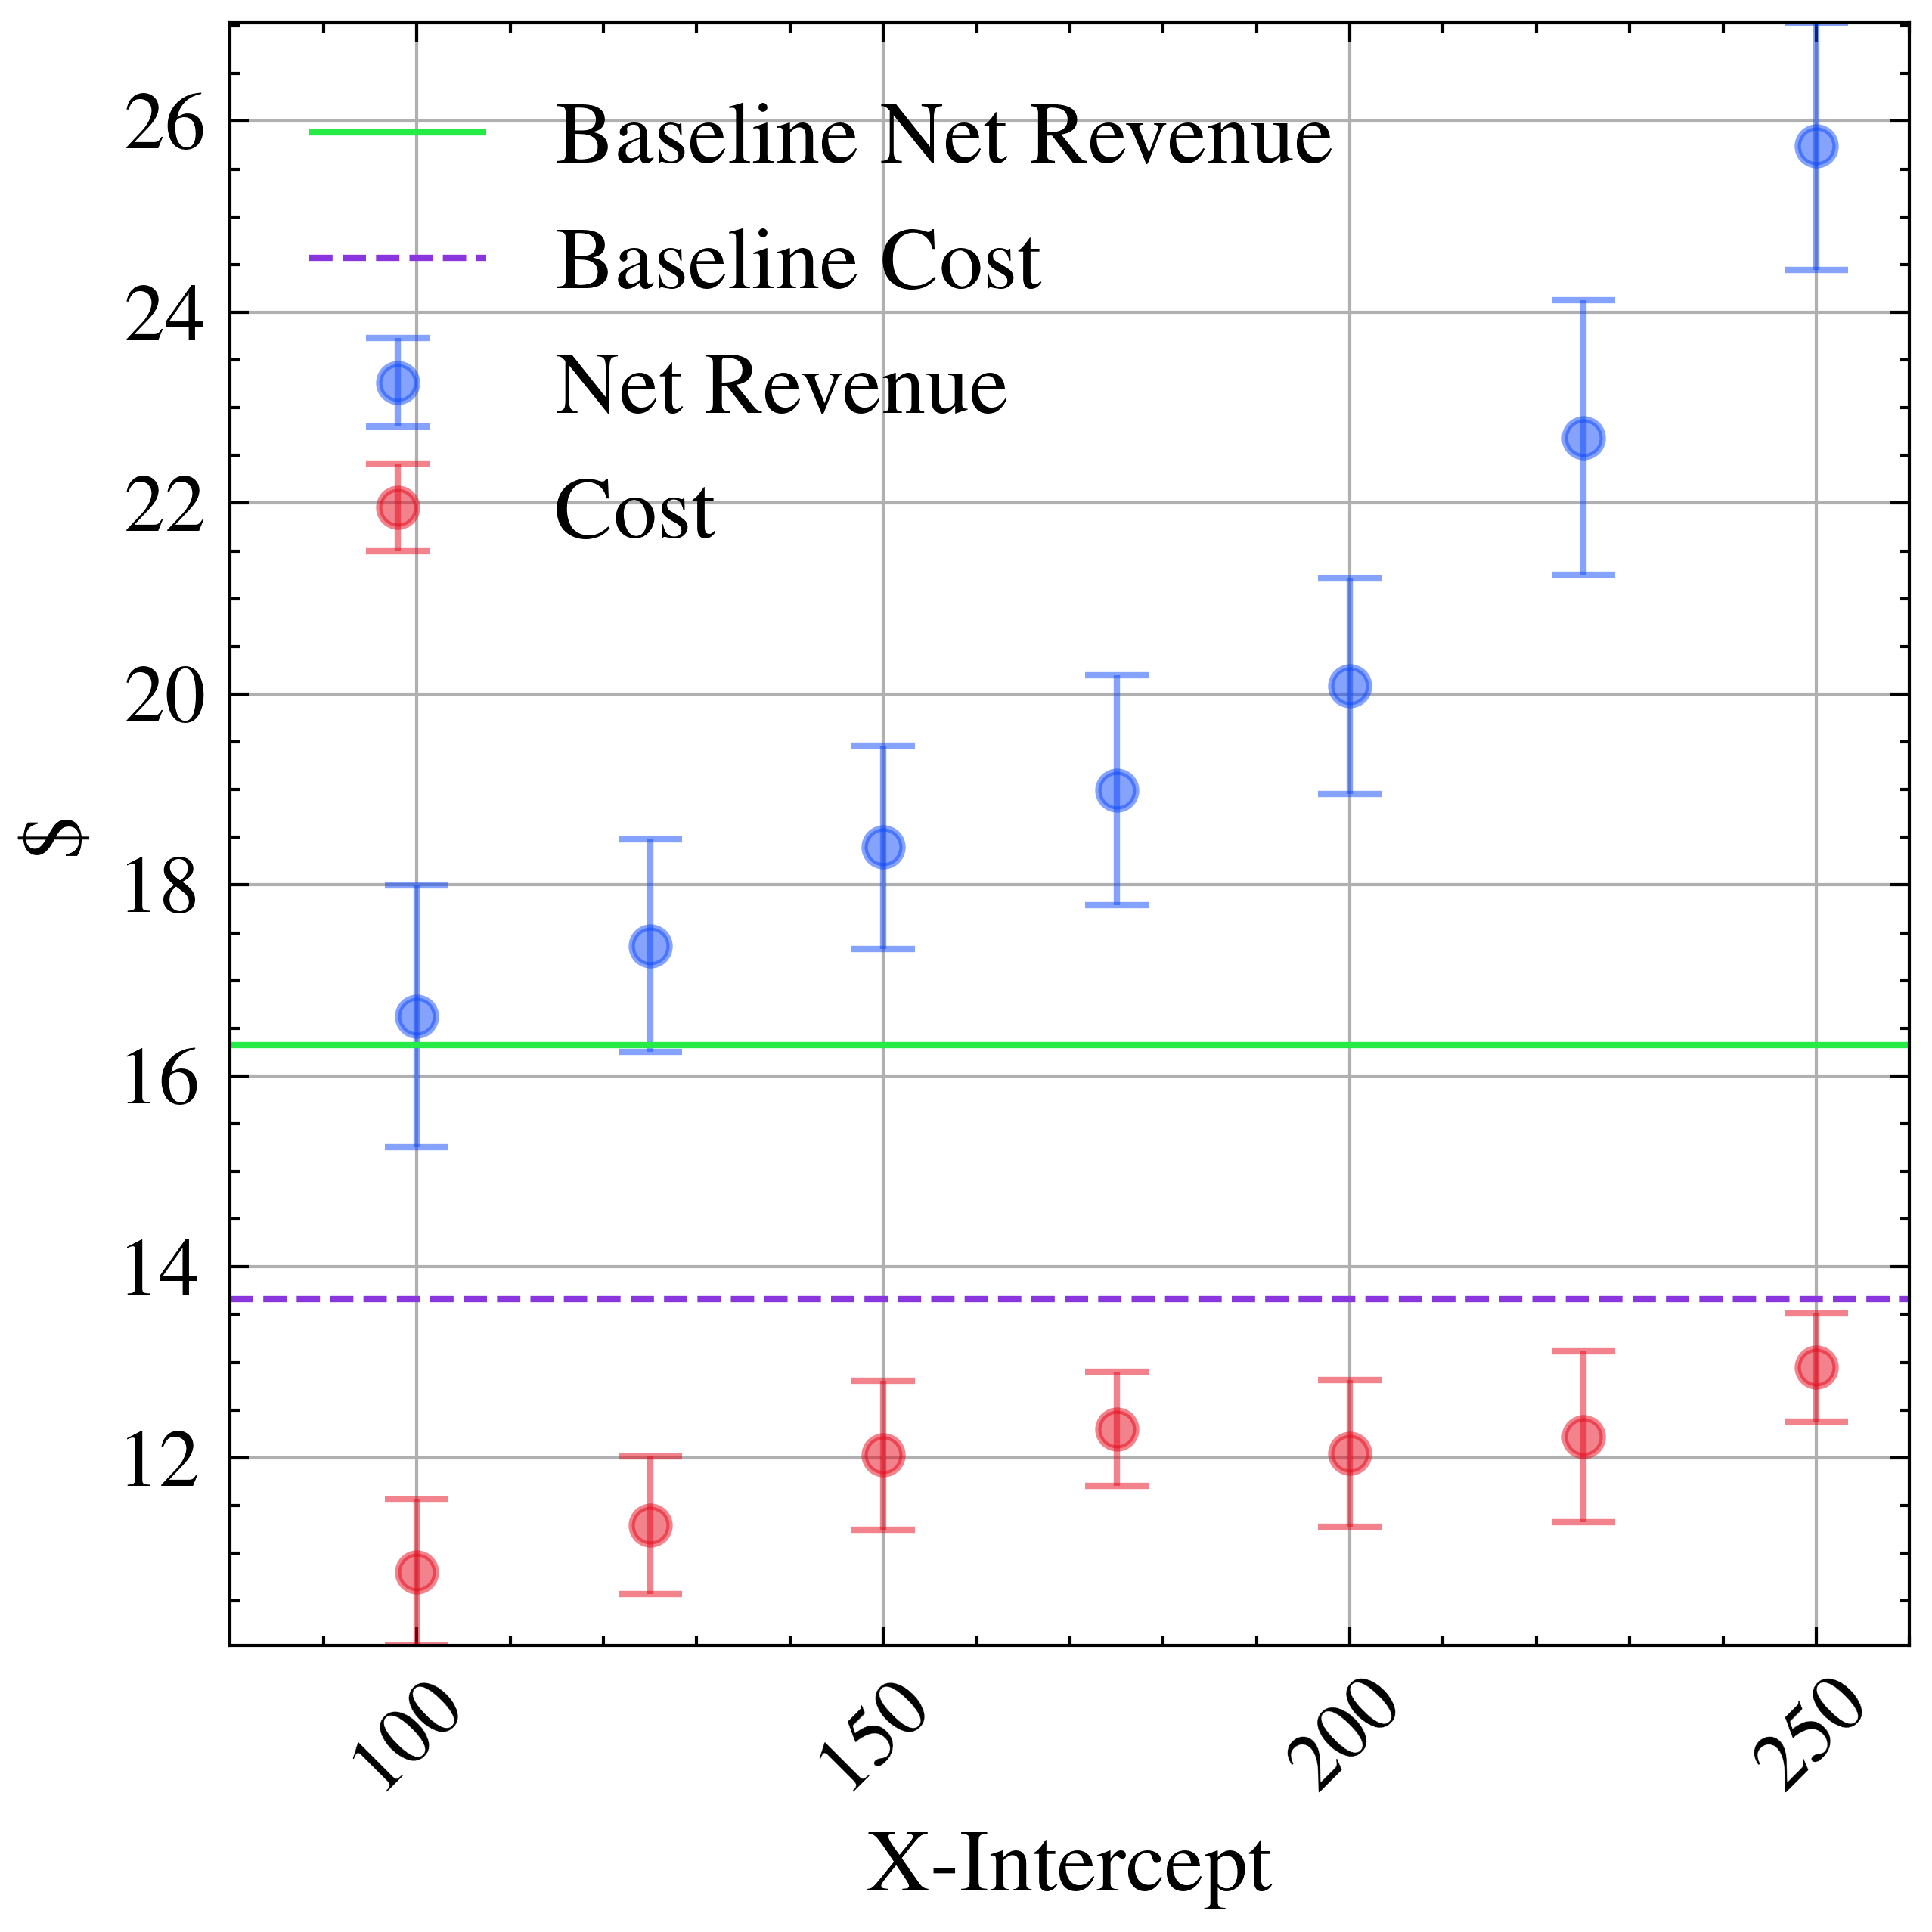

In [11]:
grouped_df = sim_stats_df.groupby('x_intercept')
means = grouped_df['Net Revenue (cents)'].mean()
stds = grouped_df['Net Revenue (cents)'].std()

plt.figure(figsize=(w/1.5, w/1.5))
plt.errorbar(means.index, means, yerr=stds, fmt='o',alpha=0.5, capsize=5, color=high_vis_map[0],label='Net Revenue')

means = grouped_df['Cost (cents)'].mean()
stds = grouped_df['Cost (cents)'].std()


plt.errorbar(means.index, means, yerr=stds, fmt='o', alpha = 0.5,capsize=5, color=high_vis_map[1], label='Cost')
plt.hlines(16.32, xmin = 80, xmax = 260,color = high_vis_map[2],linestyle="-", label ='Baseline Net Revenue')
plt.hlines(13.66, xmin = 80, xmax = 260,color = high_vis_map[3], linestyle="--",label ='Baseline Cost')

plt.xlabel('X-Intercept')
plt.ylabel('\$')
# plt.title('Monte Carlo Simulation Results')
plt.legend()
plt.grid(True)
plt.margins(0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
high_vis_map.extend(["#f07933",
"#14d45e",
"#b812b3",
"#f9cb0b",
"#1ad3ea"])


In [38]:
high_vis_map

['#0d49fb',
 '#e6091c',
 '#26eb47',
 '#8936df',
 '#fec32d',
 '#25d7fd',
 '#f07933',
 '#14d45e',
 '#b812b3',
 '#f9cb0b',
 '#1ad3ea']

In [13]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": "Helvetica",
# })

# plt.rcParams['legend.title_fontsize'] = 'small'

high_vis_map = ['#0d49fb',
 '#e6091c',
 '#26eb47',
 '#8936df',
 '#fec32d',
 '#25d7fd',
 '#f07933',
 '#14d45e',
 '#b812b3',
 '#f9cb0b',
 '#1ad3ea']

19.985027732616306 3.224424061746721
11.948516989308024 0.9700398682487148


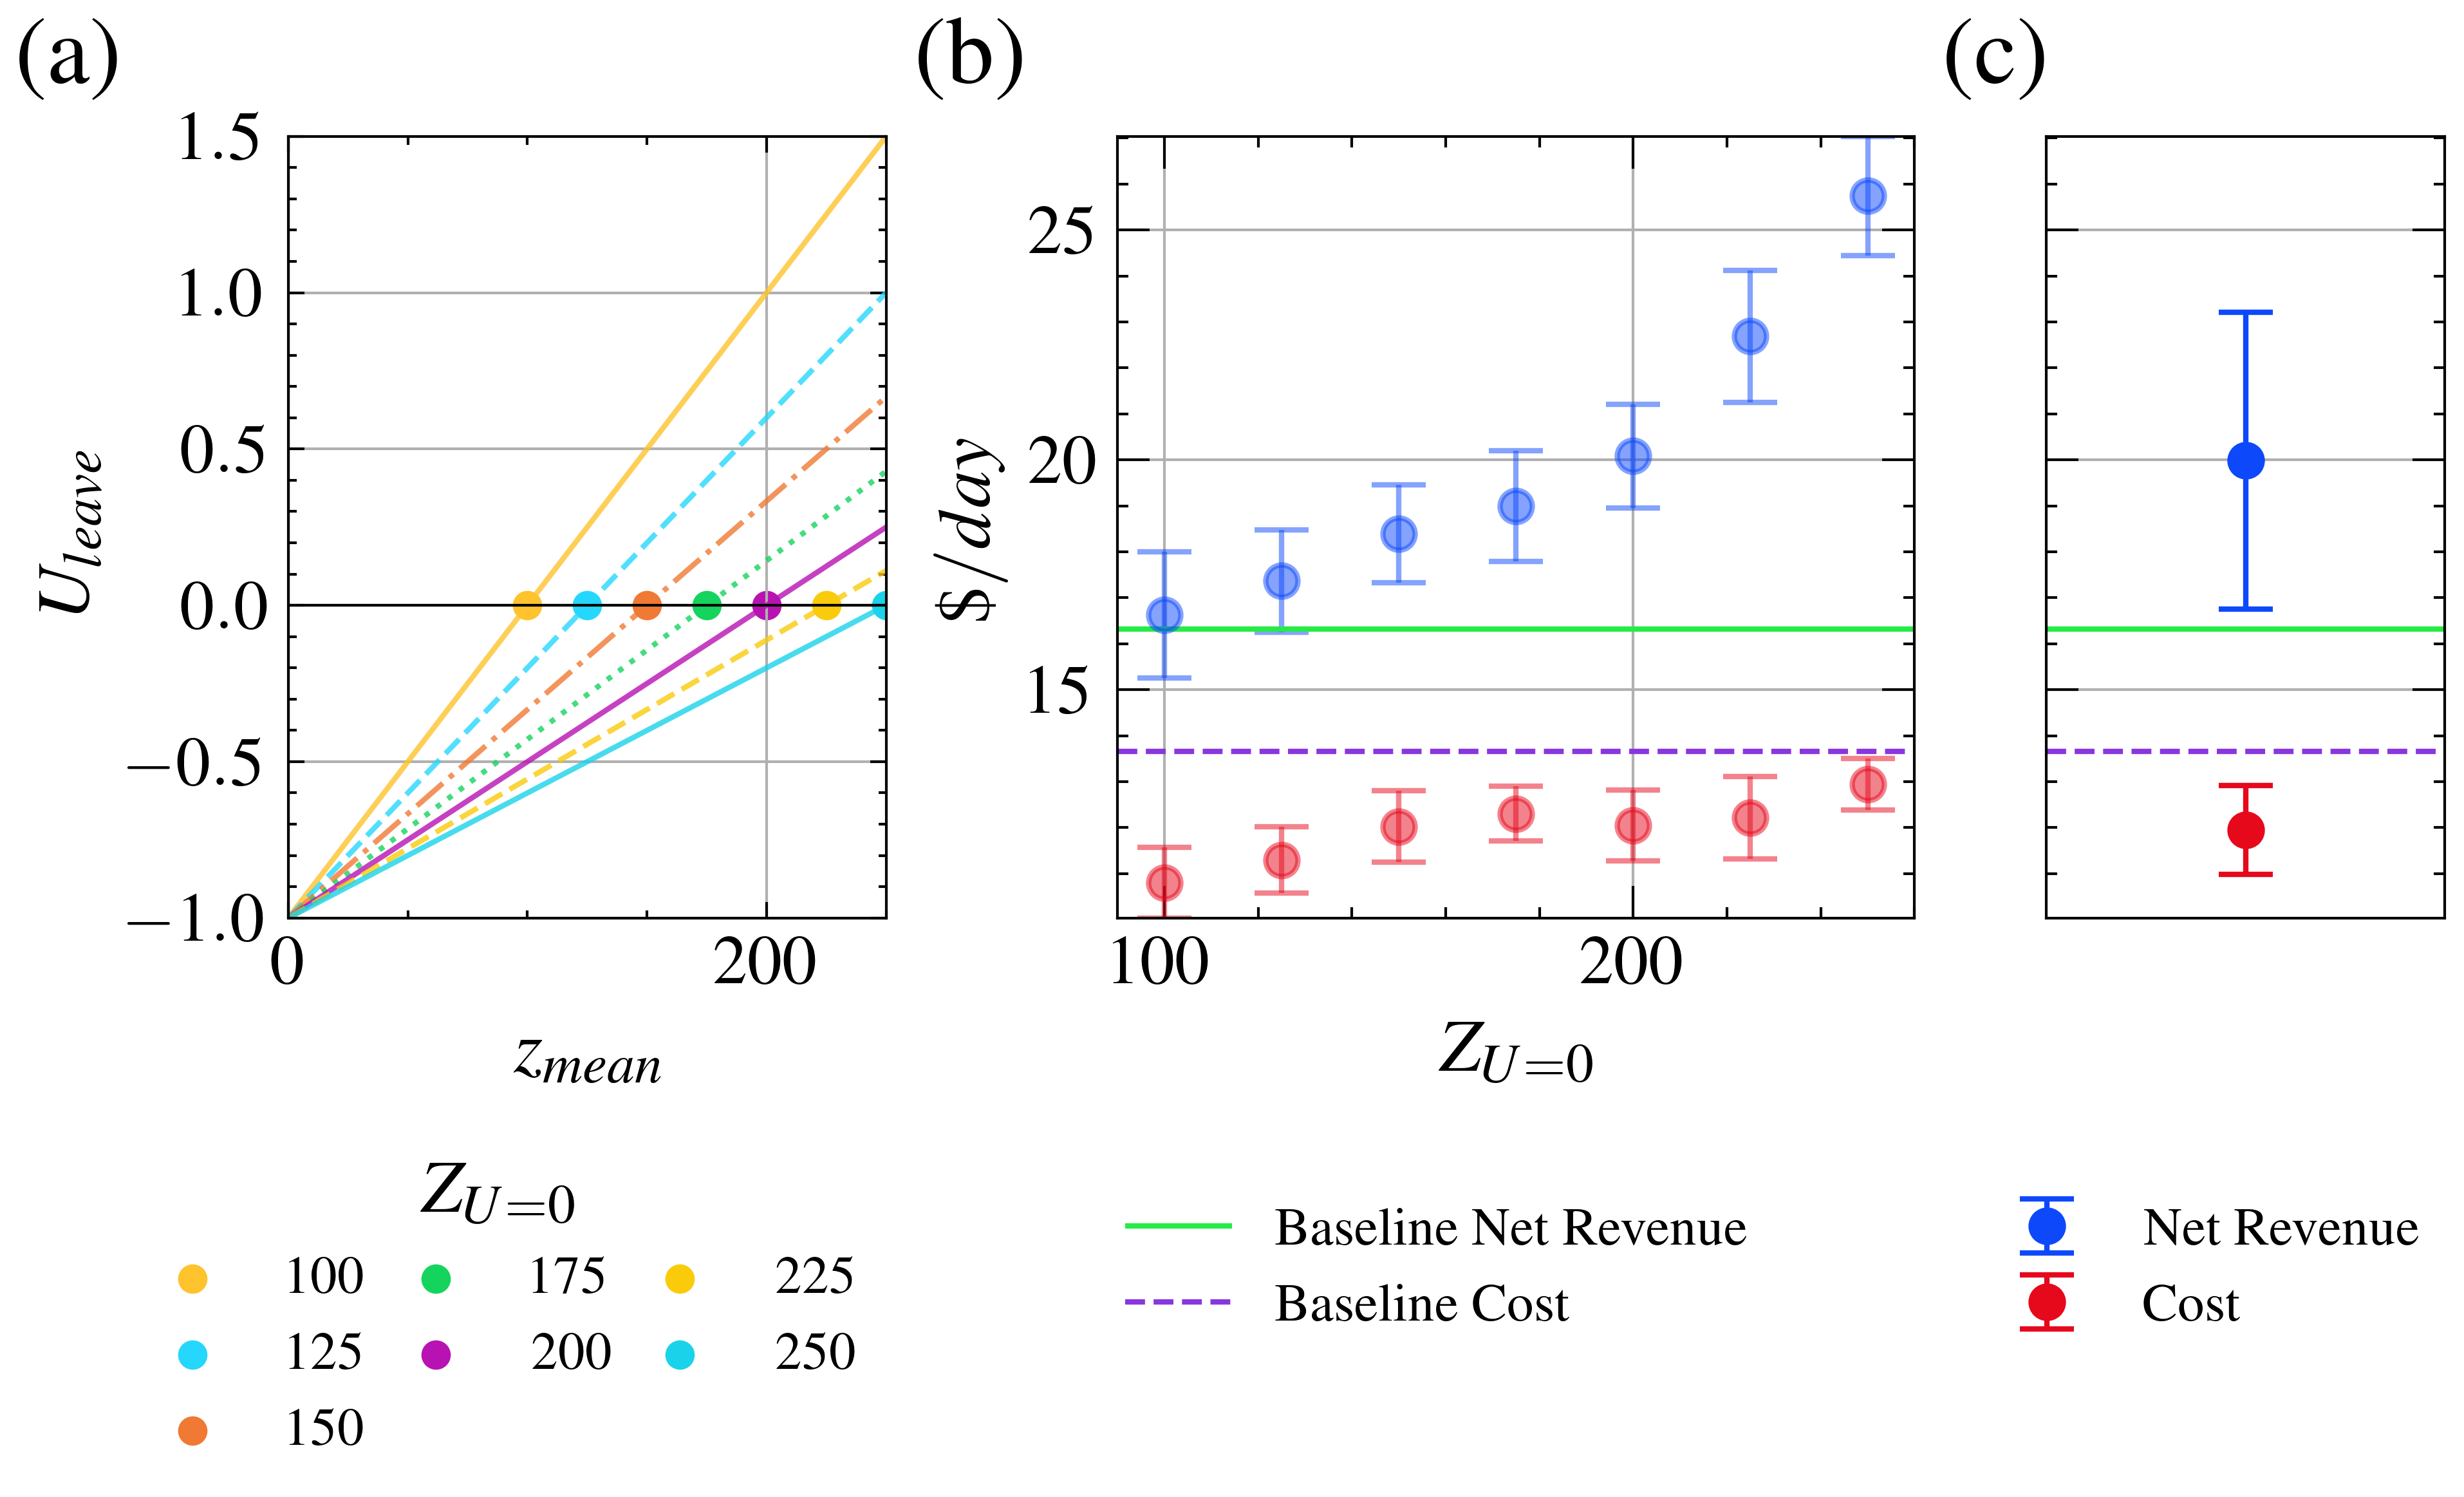

In [14]:
import matplotlib.ticker as ticker
grouped_df = sim_stats_df.groupby('x_intercept')
means = grouped_df['Net Revenue (cents)'].mean()
stds = grouped_df['Net Revenue (cents)'].std()
subplot_labels = ['(a)','(b)','(c)']
# Create the figure and subplots
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, 
                                    figsize=(w, w/1.7), 
                                    sharey=False, 
                                    gridspec_kw={'width_ratios': [1.5, 2, 1]},
                                    constrained_layout=True)

for ax, label in zip([ax0,ax1, ax2], subplot_labels):
    # Your plotting code for each subplot goes here
    # For example:
    # ax.plot(...)

    # Add the label in the upper left corner of the subplot
    pos_x = -0.25
    if label == '(a)':
        pos_x = -.45
    
    ax.text(pos_x, 1.15, label, transform=ax.transAxes, fontsize=18, fontweight='bold', va='top')

# 

i_range = np.arange(100,275,25)
z_mean = np.arange(0,300,50)
for i, leave_intercept in enumerate(i_range):
    leave_coeff = 1 / leave_intercept
    u_leave = -1 + leave_coeff * (z_mean)
    ax0.plot(z_mean, u_leave, color=high_vis_map[i+4],alpha=0.8)
    ax0.scatter(leave_intercept, 0, color=high_vis_map[i+4], s = 20, label = leave_intercept)
ax0.margins(0)
ax0.legend(title="$Z_{U=0}$",
           loc='center',  columnspacing=0.25,
           ncol=3,fontsize=10, bbox_to_anchor=(0.35, -0.5),)

ax1.errorbar(means.index, means, yerr=stds, fmt='o',alpha=0.5, capsize=5, color=high_vis_map[0])

means = grouped_df['Cost (cents)'].mean()
stds = grouped_df['Cost (cents)'].std()


ax1.errorbar(means.index, means, yerr=stds, fmt='o', alpha = 0.5,capsize=5, color=high_vis_map[1])

ax1.hlines(16.32, xmin = 90, xmax = 260,color = high_vis_map[2],linestyle="-", label ='Baseline Net Revenue')
ax1.hlines(13.66, xmin = 90, xmax = 260,color = high_vis_map[3], linestyle="--",label ='Baseline Cost')

ax1.set_xlabel('$Z_{U=0}$')
ax1.set_ylabel('$\$/day$')
# plt.title('Monte Carlo Simulation Results')
ax1.legend(bbox_to_anchor=(0.4, -0.45), loc='center', ncol=1,fontsize=10)
ax1.grid(True)

# Set tick sizes for the first subplot
ax1.tick_params(axis='both', which='major', length=6)  # Major tick size
ax1.tick_params(axis='both', which='minor', length=2)   # Minor tick size

ax2.tick_params(axis='both', which='major', length=6)  # Major tick size
ax2.tick_params(axis='both', which='minor', length=2)   # Minor tick size


ax1.margins(0)
ax2.margins(0)

# ax2.set_xlabel('All Samples')

ax2.errorbar(150,sim_stats_df['Net Revenue (cents)'].mean(), yerr=sim_stats_df['Net Revenue (cents)'].std(), fmt='o',alpha=1, capsize=5, color=high_vis_map[0],label='Net Revenue')
ax2.errorbar(150,sim_stats_df['Cost (cents)'].mean(), yerr=sim_stats_df['Cost (cents)'].std(), fmt='o',alpha=1, capsize=5, color=high_vis_map[1],label='Cost')
ax2.grid(True)

print(sim_stats_df['Net Revenue (cents)'].mean(), sim_stats_df['Net Revenue (cents)'].std())
print(sim_stats_df['Cost (cents)'].mean(), sim_stats_df['Cost (cents)'].std())
ax2.hlines(16.32, xmin = 140, xmax = 160,color = high_vis_map[2],linestyle="-")
ax2.hlines(13.66, xmin = 140, xmax = 160,color = high_vis_map[3], linestyle="--")

ax2.legend(bbox_to_anchor=(0.4, -0.45), loc='center', ncol=1,fontsize=10)
    
ax2.set_xticks([])

ax0.grid(True)
ax0.axhline(0, color='black', linewidth=0.5)
ax0.axvline(0, color='black', linewidth=0.5)
ax0.set_ylabel("$U_{leave}$")
ax0.set_xlabel("$z_{mean}$")

# fig.patch.set_visible(False)
# Share the y-axis between ax1 and ax2
ax1.get_shared_y_axes().join(ax1, ax2)
ax2.set_yticklabels([])
fig.savefig('Figures/sensitivity_analysis_results_legend_abc2.pdf', dpi=300)

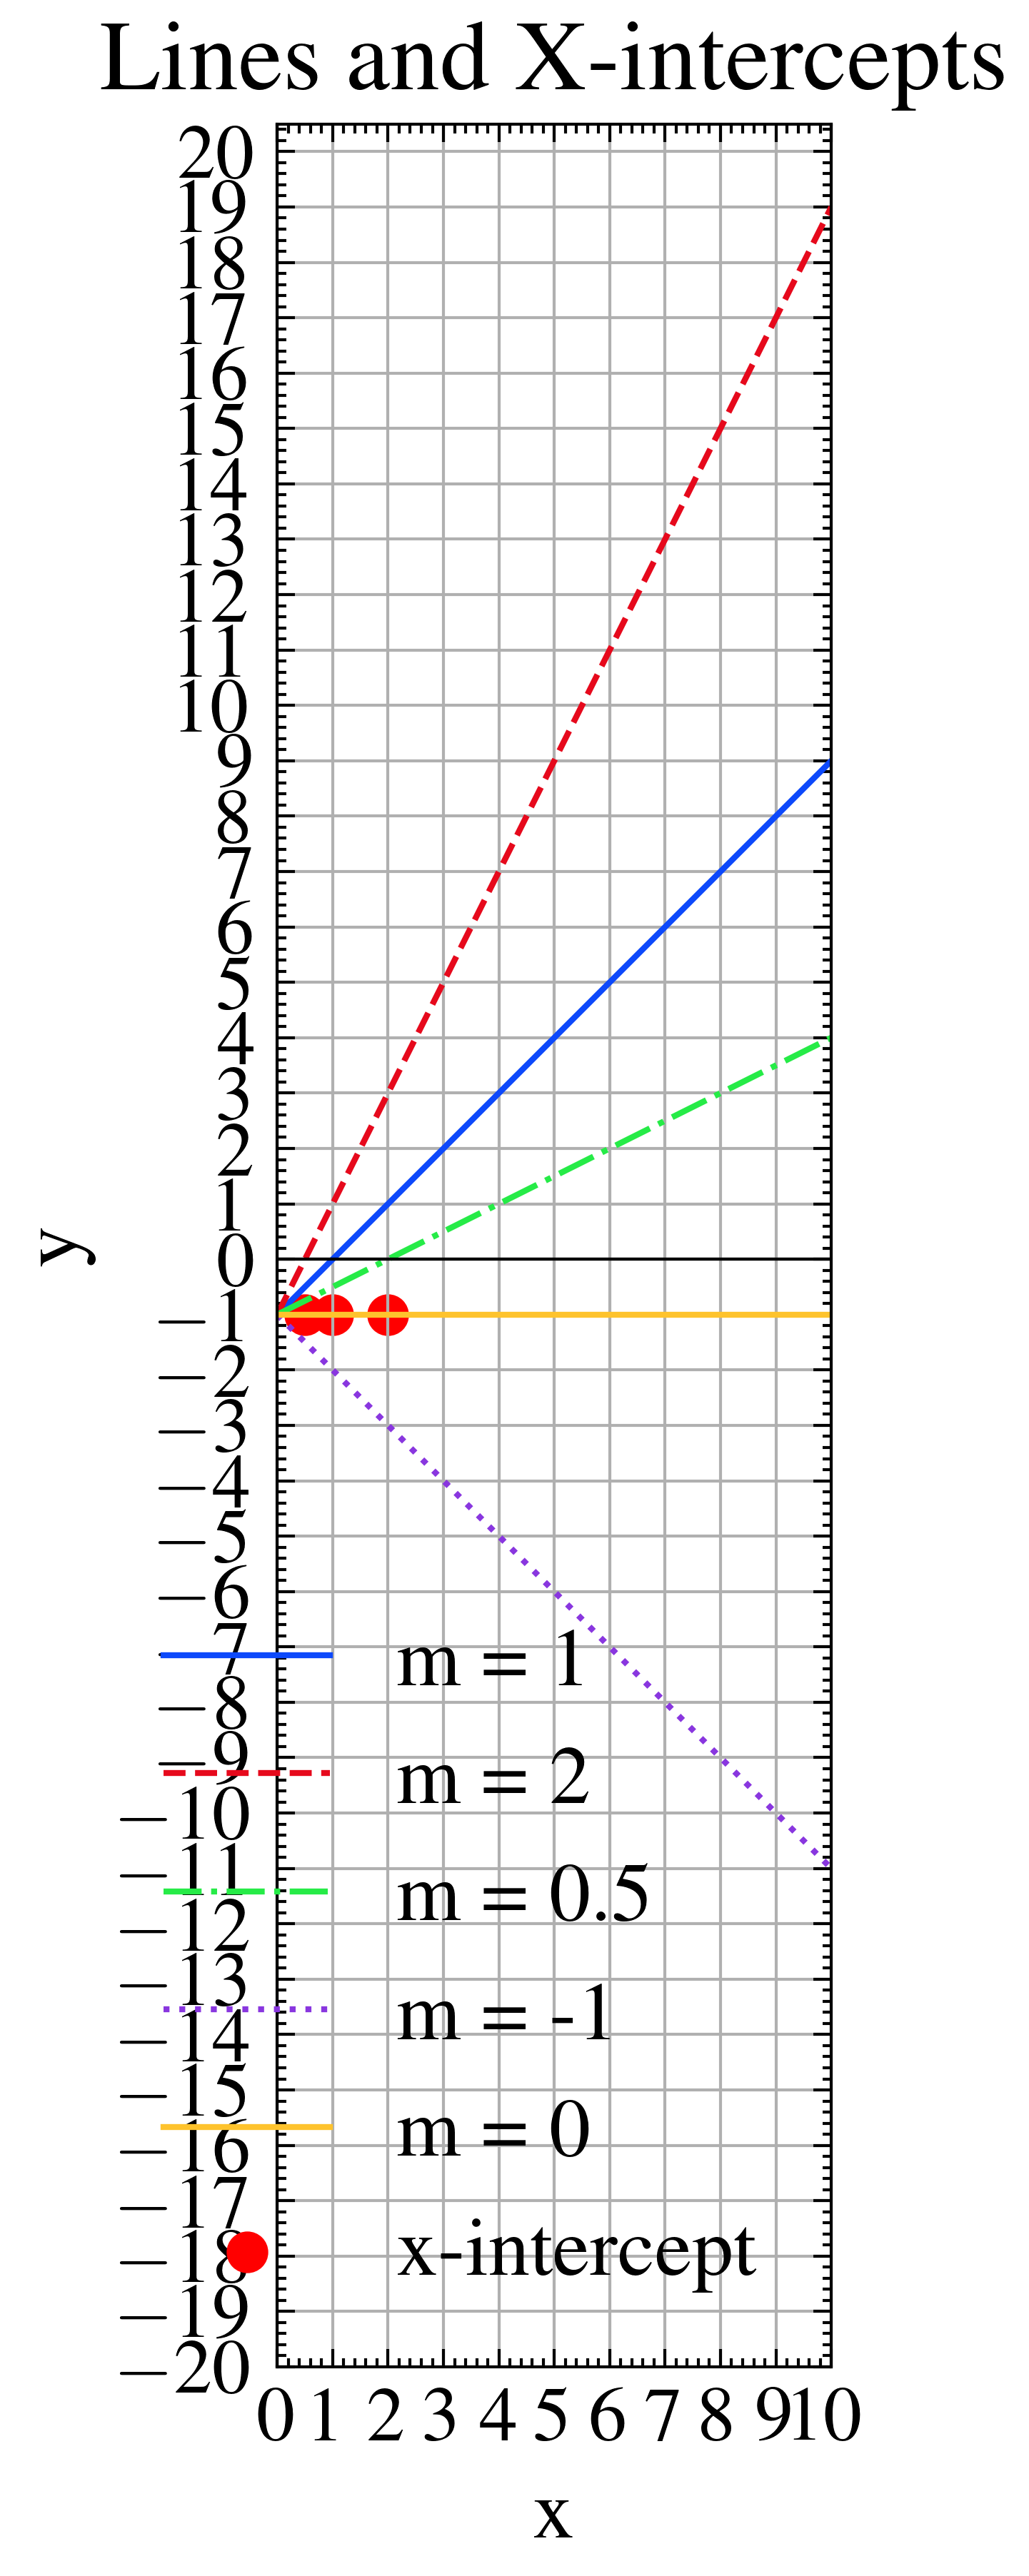

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Define the values of m for each line
m_values = [1, 2, 0.5, -1, 0]

# Create a range of x values for plotting
x = np.linspace(0, 10, 100)

# Create the plot
plt.figure(figsize=(8, 6))
plt.gca().set_aspect('equal')  # Set aspect ratio to be equal

# Plot each line with a different color
for m in m_values:
    y = -1 + m * x
    plt.plot(x, y, label=f'm = {m}')

# Plot the x-axis starting from y = 0
plt.axhline(0, color='black', linewidth=0.5)
plt.xlim(0, 10)  # Set the x-axis limits to show from y = 0

# Find and plot the x-intercepts
x_intercepts = [1/m for m in m_values if m != 0]  # Avoid division by zero for m=0
y_intercepts = [-1 for _ in x_intercepts]
plt.scatter(x_intercepts, y_intercepts, color='red', label='x-intercept')

# Set x and y ticks manually
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(-20, 21, 1))

# Set plot labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lines and X-intercepts')
plt.legend()

plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.show()


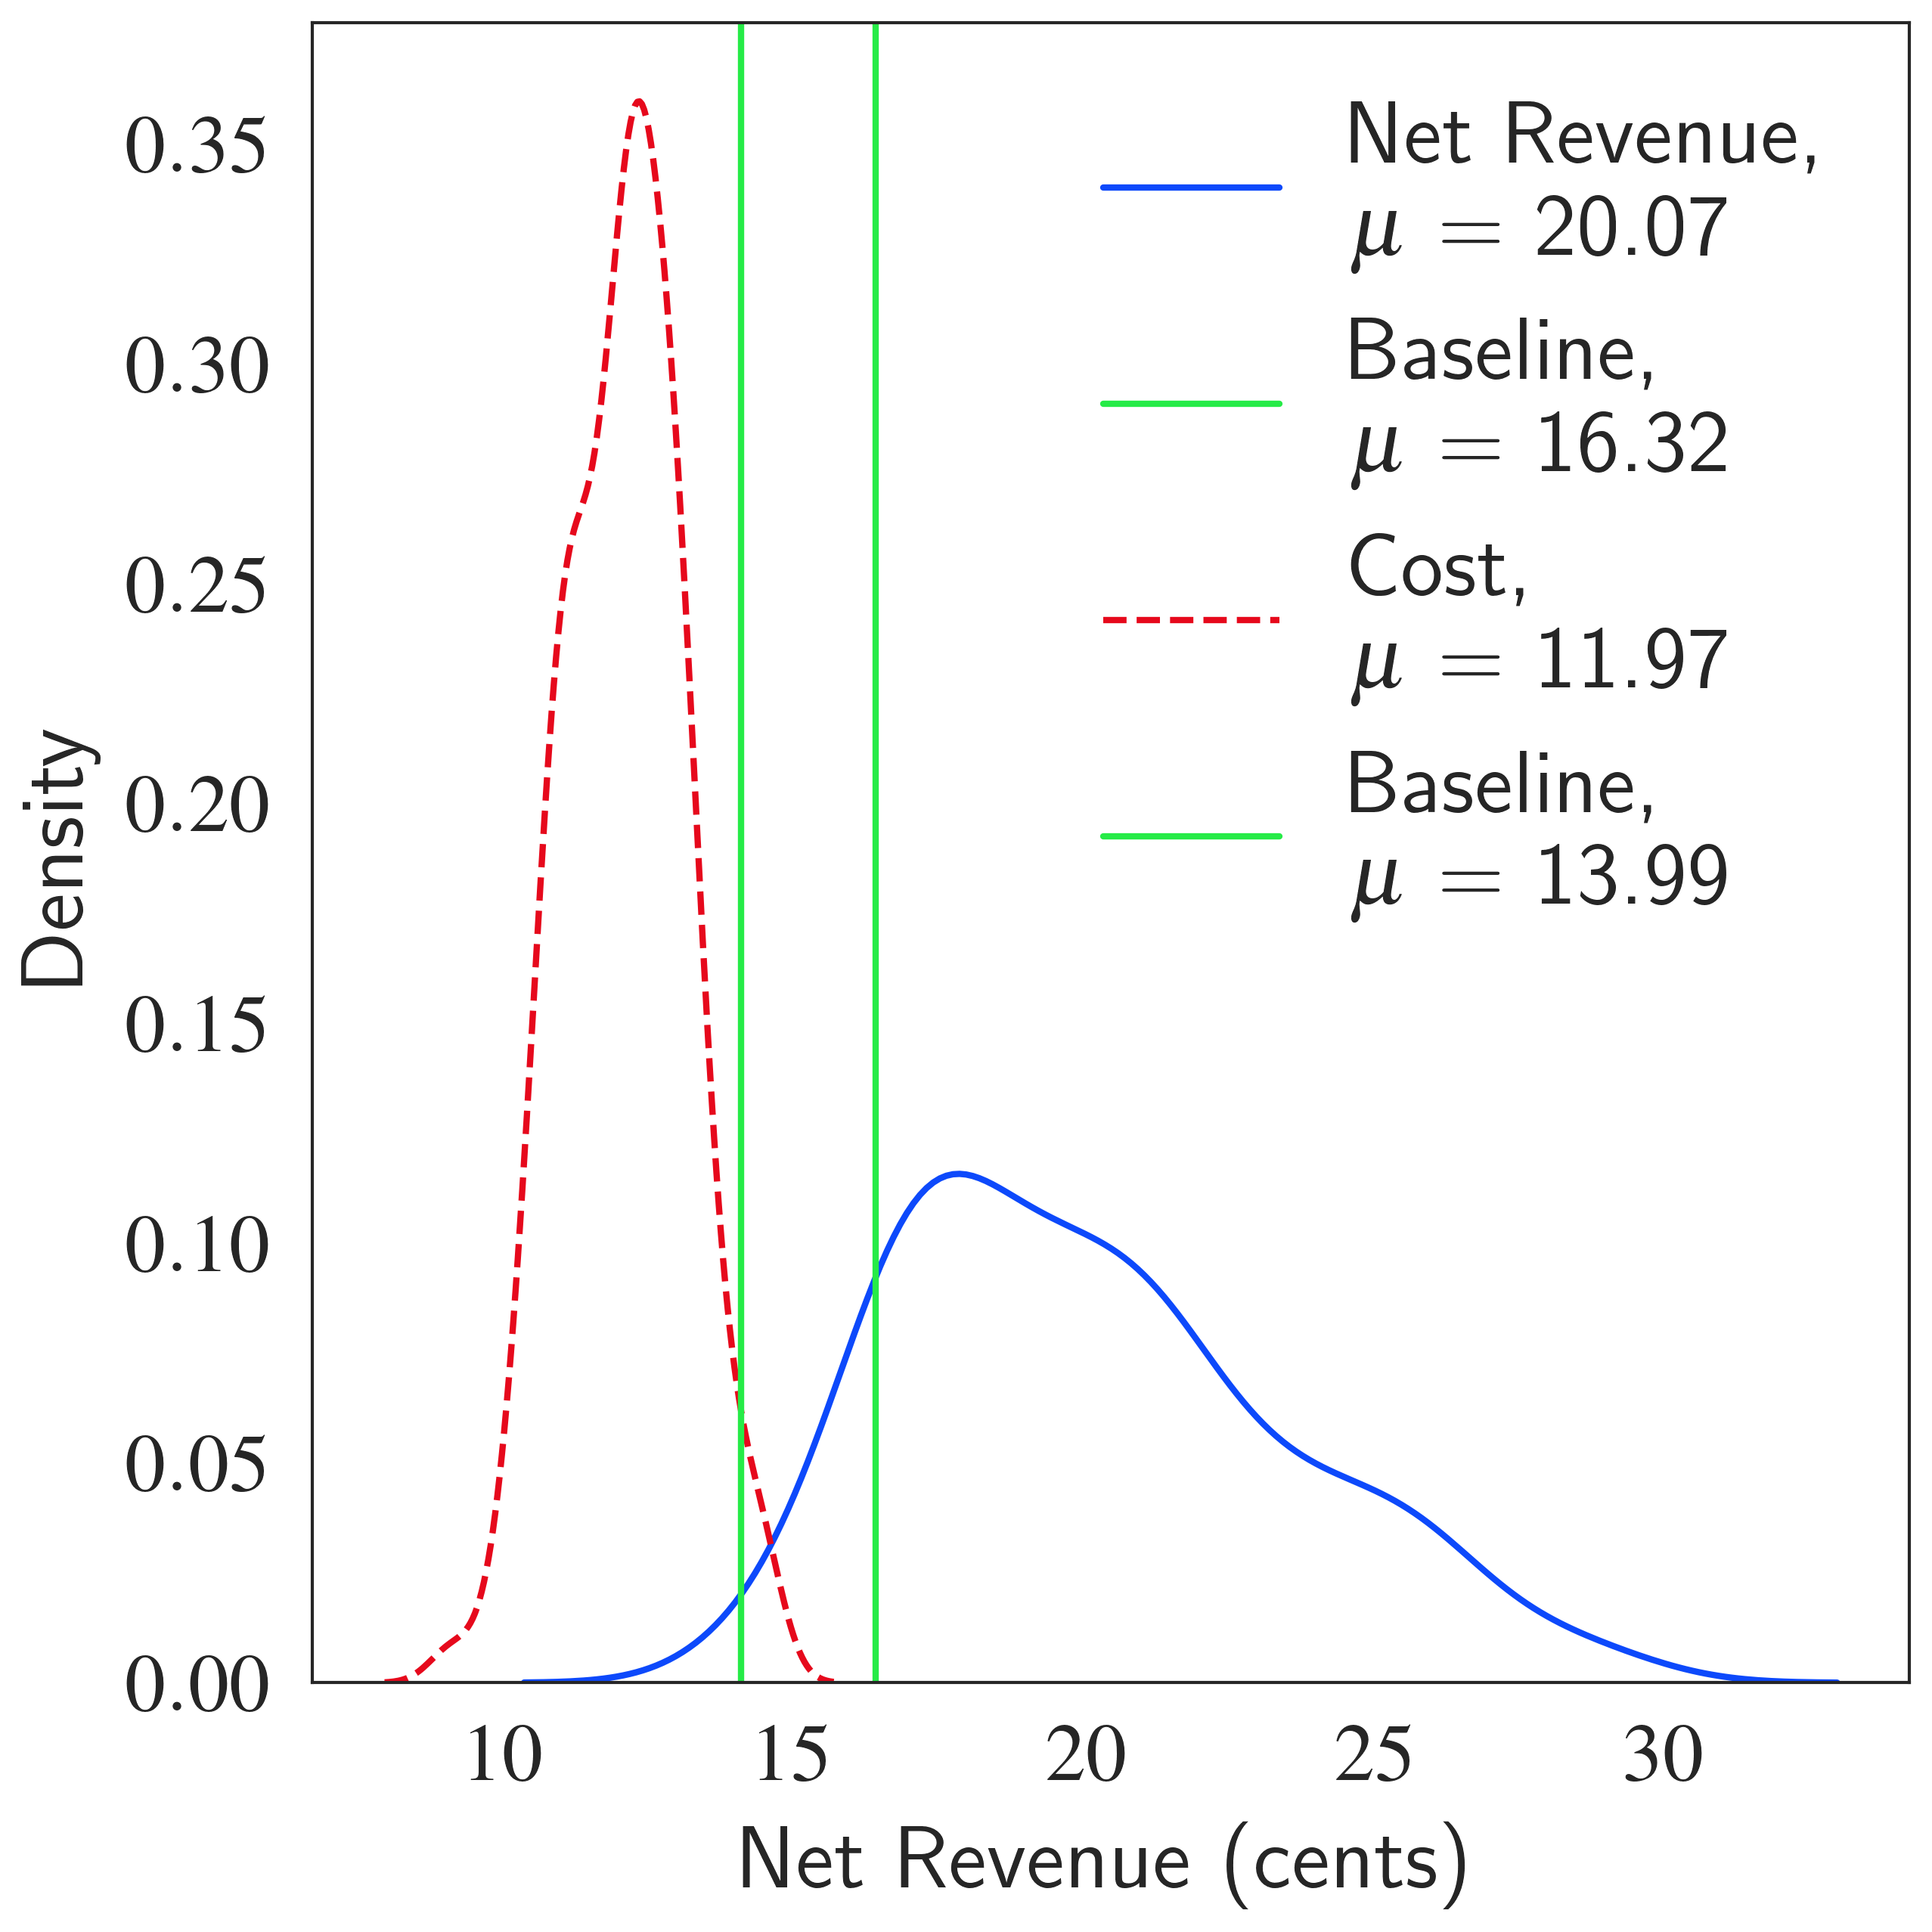

In [51]:
sns.set_style("white")
fig,(ax) = plt.subplots(1,1,figsize=(w/1.5,w/1.5))

sns.kdeplot( sim_stats_df['Net Revenue (cents)'].dropna(),
            ax=ax, lw=1,
            color=high_vis_map[0], 
            label = 'Net Revenue,\n$\mu$ = {}'.format(np.round(sim_stats_df['Net Revenue (cents)'].dropna().mean(),2)))
ax.axvline(16.32, 
           linestyle="-", label = 'Baseline,\n$\mu$ = {}'.format(16.32),
           color=high_vis_map[2])

sns.kdeplot( sim_stats_df['Cost (cents)'].dropna(),
            ax=ax, lw=1,
            color=high_vis_map[1], 
            label = 'Cost,\n$\mu$ = {}'.format(np.round(sim_stats_df['Cost (cents)'].dropna().mean(),2)))
ax.axvline(13.99, 
           linestyle="-", label = 'Baseline,\n$\mu$ = {}'.format(13.99),
           color=high_vis_map[2])
ax.legend()

In [42]:
sim_stats_df.columns

Index(['sim_name', 'Revenue (cents)', 'Cost (cents)', 'LEAVE_count',
       'SCH_count', 'x_intercept', 'Net Revenue (cents)'],
      dtype='object')

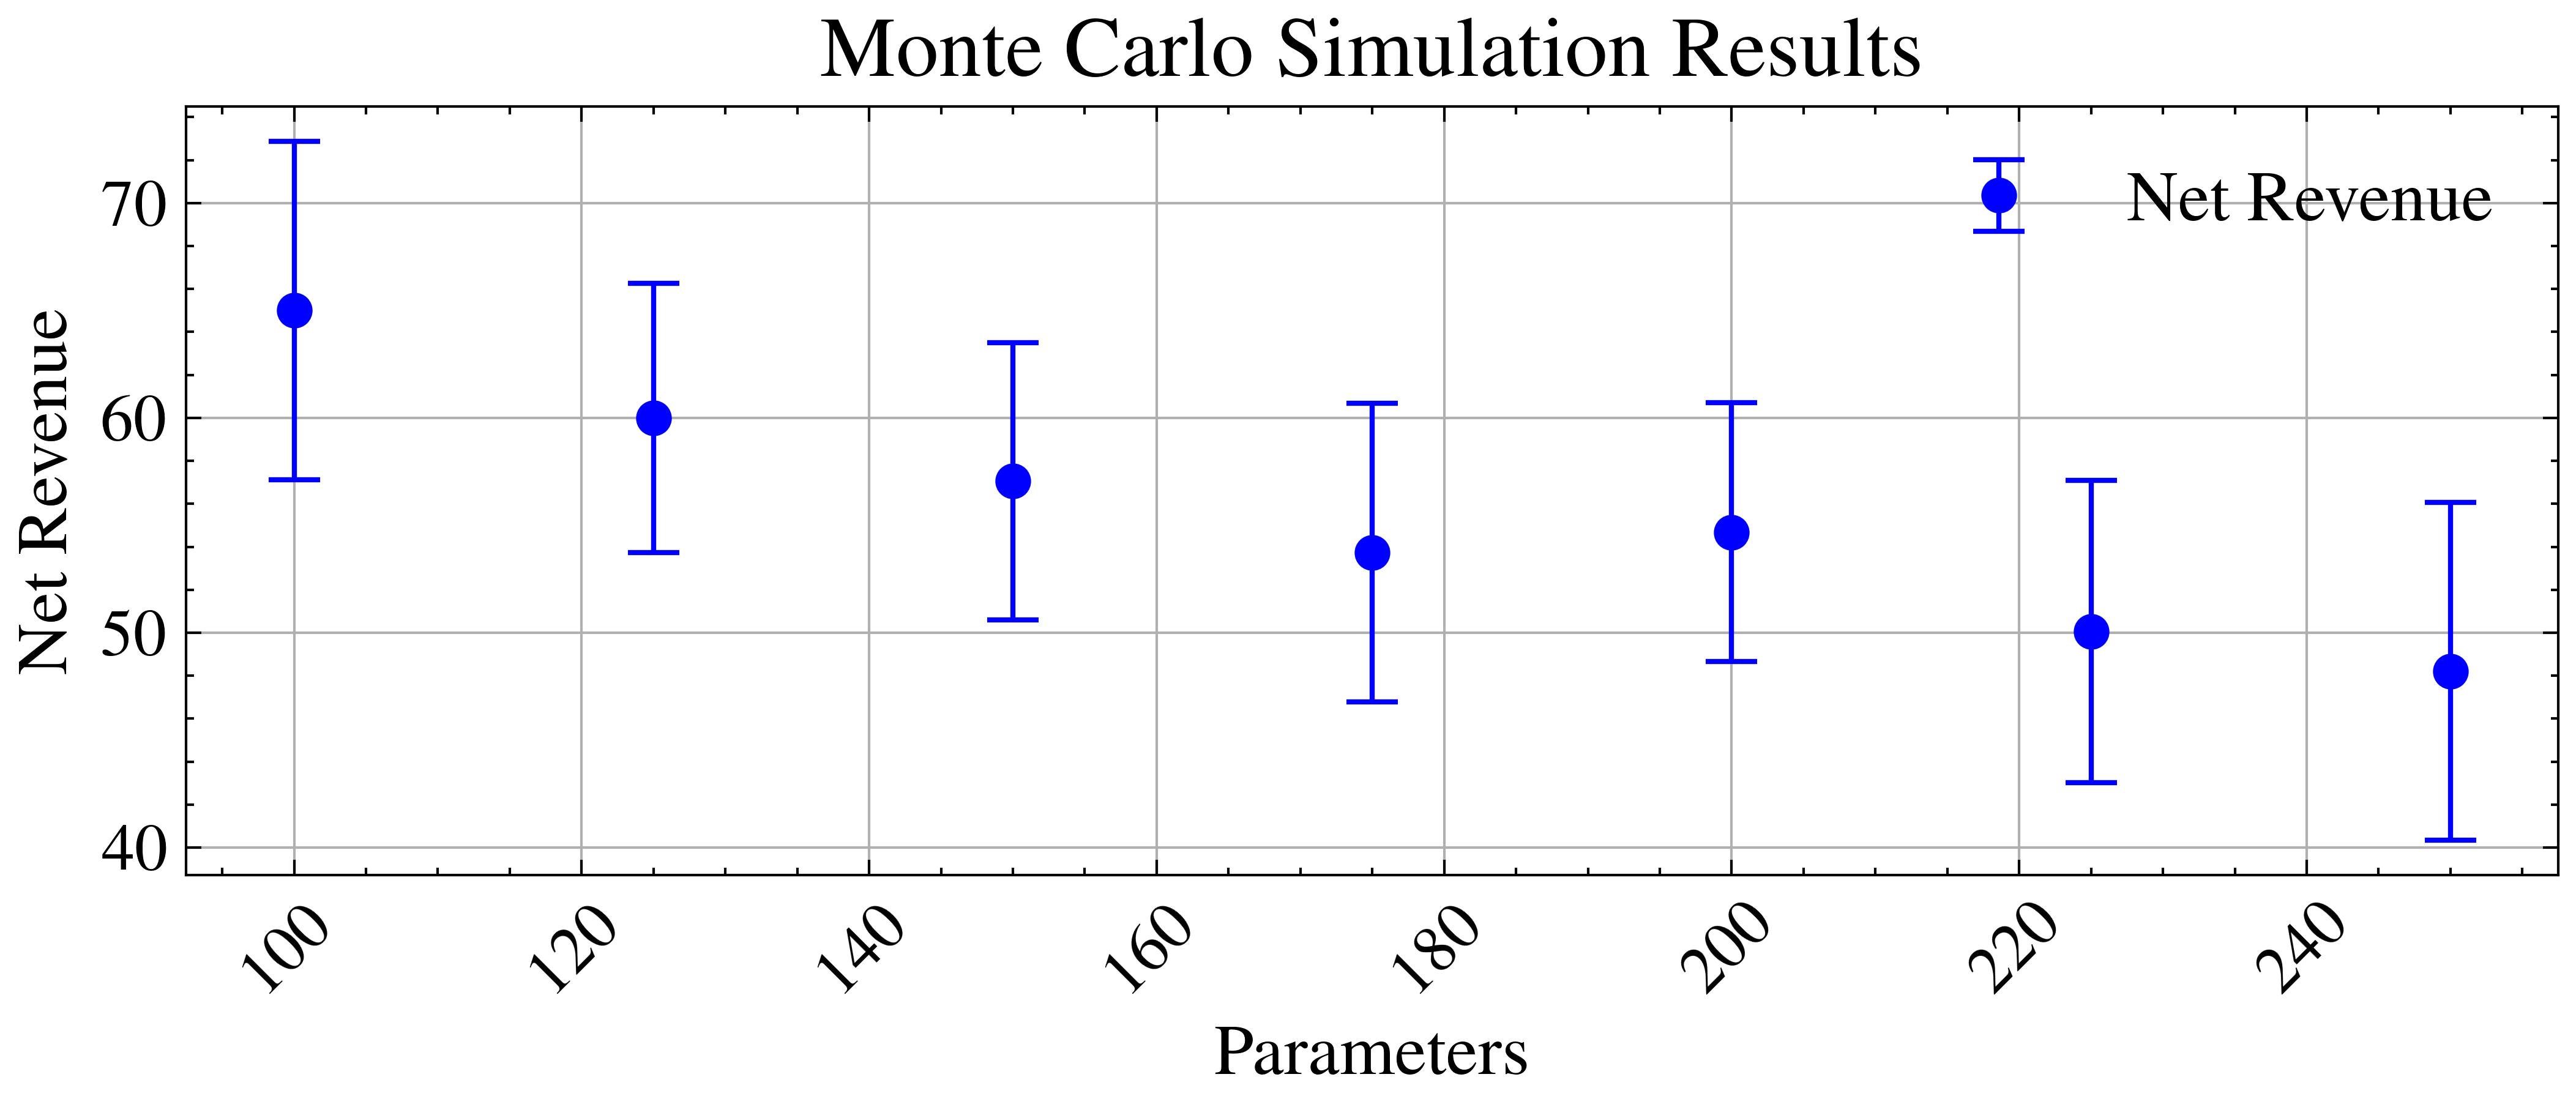

In [107]:
grouped_df = sim_stats_df.groupby('x_intercept')
means = grouped_df['LEAVE_count'].mean()
stds = grouped_df['LEAVE_count'].std()

plt.figure(figsize=(7, 3))
plt.errorbar(means.index, means, yerr=stds, fmt='o', capsize=5, color='b', label='Net Revenue')
plt.xlabel('Parameters')
plt.ylabel('Net Revenue')
plt.title('Monte Carlo Simulation Results')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:


parameter_names = ["leave_x_intercept", 
                    "leave_y_intercept",
                    "REG_delta_x_coeff", 
                    "REG_y_intercept",
                    "SCH_delta_x_coeff", 
                    "SCH_y_intercept",
                    "SCH_z_0",
                    "REG_z_0"
                    ]
default_params = [200, -1, 0.0092, 0.341, 0.0092, 0, 30, 35]
varying_params = [ [100,150,200,250,275], 
                    [-.5, -1, -1.5, -2], 
                    [0.0045 ,0.0092 , 0.0184], 
                    [-0.341, 0 , 0.341 , 0.7], 
                    [0.0045 , 0.0092 , 0.0184], 
                    [-0.341, 0 , 0.341 , 0.7], 
                    [20, 25, 30, 35, 40],
                    [20, 25, 30, 35, 40]]


sim_names = []
for i, varying_range in enumerate(varying_params):
    for value  in varying_range:

        parameters = default_params[:]
        parameters[i] = value


        output_label = ""
        for name, value in zip(parameter_names, parameters):
            output_label += f"{name}_{value}-"

        output_label += ".pkl"
        # print(output_label[:-5])
        
        sim_names.append(output_label[:-5])
sim_names = [k+"_{}".format(i) for k,i in product(sim_names,range(1,20))]
sim_names = list(np.unique(np.array(sim_names)))


import json
sim_start_ts = sessions['connectTime'].min().replace(minute=0,second=0)
sim_end_ts = phase3_end 
sim_data = pd.DataFrame(index = pd.date_range(sim_start_ts , sim_end_ts, freq='15min'))

sim_stats_df = pd.DataFrame(index = sim_names, columns = ['Revenue (cents)',
                                                          'Cost (cents)',
                                                          'LEAVE_count',
                                                          'SCH_count'])
sim_powers_df = pd.DataFrame(index = pd.date_range(sim_start_ts , sim_end_ts, freq='15min'), 
                             columns = sim_names)
sim_powers_df = sim_powers_df.fillna(0)

TOU_tariff = TOU_15min()

for i, timestamp in enumerate(sim_data.index):
    time_index = (timestamp.time().hour * 4) + (timestamp.time().minute // 15)
    sim_powers_df.loc[timestamp, "TOU Tariff (cents/kWH)"] = TOU_tariff[time_index]
    
for i, varying_range in enumerate(varying_params):
    for value  in varying_range:

        parameters = default_params[:]
        parameters[i] = value

        for name, value in zip(parameter_names, parameters):
            # Iterate over the parameter names and values
            output_label = ""
            for name, value in zip(parameter_names, parameters):
                output_label += f"{name}_{value}-"
        
        output_file = output_label + ".pkl"
        print(output_label)
        res_path = os.path.join(data_path, "sobol_indice_data","results_"+ output_file)
        results = pd.read_pickle(res_path)
        pow_path = os.path.join(data_path, "sobol_indice_data","power_schedule_intercept_"+ output_file)
        powers = pd.read_pickle(pow_path)
            
        powers = powers.set_index(['arrHour','highPower'])  
        output_label =  output_label[:-1]
        for sim_num in range(1,20):

            rate, count = sample_sessions(sessions, 33)
            row_list = [sessions]
            for cnt in range(len(count)):
                row_list.append(sessions[(sessions['arrHour'] == count.loc[cnt,'arrHour']) & (sessions['highPower'] == count.loc[cnt,'highPower'])].sample(n=count.loc[cnt,'choice'], replace=True))
            sessions_augmented = pd.concat(row_list)
            sessions_augmented  = sessions_augmented.reset_index(drop=False)

            assert len(sessions_augmented) == len(sessions) + 33, "Size mismatch"

            revenue = 0
            leave = 0
            sch_choices = 0

            for row in sessions_augmented.index:

                user = sessions_augmented.loc[row,'userId']
                highPower = int(user_maxChgRate.loc[user,'peakPower_W'] / 1000 > 5 )
                arrHour = sessions_augmented.loc[row,'connectTime'].hour
                duration = powers.loc[(arrHour,highPower),'estDurationHrs']

                REG = powers.loc[(arrHour,highPower),'reg_centsPerHr' ]
                SCH = powers.loc[(arrHour,highPower),'sch_centsPerHr' ]
                
                choice_sim = monte_carlo_sim_choice(REG,SCH,parameters)
                
                if choice_sim != 'LEAVE':
                    if choice_sim == 'SCH':
                        sch_choices += 1
                    
                    power = json.loads(powers.loc[(arrHour,highPower),choice_sim.lower()+'_power_kw'])
                    tariff = powers.loc[(arrHour,highPower),choice_sim.lower()+'_centsPerHr']

                    revenue += tariff * duration 
                    start_ts =  sessions_augmented.loc[row,'connectTime'].replace(minute=0,second=0)
                    session_idx = pd.date_range(start_ts, periods=len(power),freq='15min')
                    session = pd.DataFrame(index = session_idx, data = {'power_kW':power, "TOU":TOU_tariff[arrHour * 4: (arrHour * 4) + len(power)]})
                    sim_powers_df.loc[session_idx, output_label+"_{}".format(sim_num)]  = sim_powers_df.loc[session_idx, output_label+"_{}".format(sim_num)].fillna(0) + session.loc[session_idx,'power_kW']
                else:
        
                    print(choice_sim)
                    leave += 1
                    _,_,p_leave = calculate_probability(REG,SCH,
                                                        leave_intercept = parameters[0], 
                                                        utility_intercept= parameters[1], 
                                                        REG_delta_x_coeff = parameters[2], 
                                                        REG_y_intercept = parameters[3], 
                                                        SCH_delta_x_coeff = parameters[4],
                                                        SCH_y_intercept = parameters[5])
                    # print("Leave prob: {}".format(p_leave))
                    # leave_list.append(dcosId)
                    
                    
            sim_stats_df.loc[output_label+"_{}".format(sim_num),'Revenue (cents)'] = revenue
            sim_stats_df.loc[output_label+"_{}".format(sim_num),'LEAVE_count'] = leave
            sim_stats_df.loc[output_label+"_{}".format(sim_num),'SCH_count'] = sch_choices

            total_cost = sim_powers_df.loc[:,output_label+"_{}".format(sim_num)] * sim_powers_df.loc[:,'TOU Tariff (cents/kWH)'] * 0.25 
            sim_stats_df.loc[output_label+"_{}".format(sim_num),'Cost (cents)'] = total_cost.sum()
# [monte_carlo_sim_choice(sessions.loc[dcosId,'reg_centsPerHr'],sessions.loc[dcosId,'sch_centsPerHr'],leaveIntercept = 100) for dcosId in sessions.index]

sim_stats_df['Net Revenue (cents)'] = sim_stats_df['Revenue (cents)'] - sim_stats_df['Cost (cents)']

# Iterate over the parameter names and values

parameter_names = ["leave_x_intercept", 
                    "leave_y_intercept",
                    "REG_delta_x_coeff", 
                    "REG_y_intercept",
                    "SCH_delta_x_coeff", 
                    "SCH_y_intercept",
                    "SCH_z_0",
                    "REG_z_0"
                    ]

sobol_indices = pd.DataFrame(index = parameter_names, columns = ["Mean(Y|X)","Var(Y|X)"])
default_params = [200, -1, 0.0092, 0.341, 0.0092, 0, 30, 35]
varying_params = [ [100,150,200,250,275], 
                    [-.5, -1, -1.5, -2], 
                    [0.0045 ,0.0092 , 0.0184], 
                    [-0.341, 0 , 0.341 , 0.7], 
                    [0.0045 , 0.0092 , 0.0184], 
                    [-0.341, 0 , 0.341 , 0.7], 
                    [20, 25, 30, 35, 40],
                    [20, 25, 30, 35, 40]]
    
sim_names = []
for i, varying_range in enumerate(varying_params):
    print("Reading Parameter: ", parameter_names[i])
    sim_names = []
    for value  in varying_range:

        parameters = default_params[:]
        parameters[i] = value


        output_label = ""
        for name, value in zip(parameter_names, parameters):
            output_label += f"{name}_{value}-"

        # output_label += ".pkl"
        sim_names.extend( [output_label[:-1]+"_{}".format(i) for i in range(1,20)])

    mean = sim_stats_df.loc[sim_names, 'Net Revenue (cents)'].mean()
    var = np.var(sim_stats_df.loc[sim_names, 'Net Revenue (cents)'])
    sobol_indices.loc[parameter_names[i],"Mean(Y|X)"] = mean
    sobol_indices.loc[parameter_names[i],"Var(Y|X)"] = var
    print("Mean(Y|X)",mean,"Var(Y|X)",var)


# sim_names = [k+"_{}".format(i) for k,i in product(sim_names,range(1,20))]x
# sim_names = list(np.unique(np.array(sim_names)))

In [ ]:
# arr = (high_prices['sch_centsPerHr'].values - sch_high_max)
def errors(default,sim,type):
    if type=='high':
        arr = default - sim
        arr = np.where(arr < 0, 0, arr)

        var = np.divide(arr,default) * 100
        print("Max {}, Min {}, Mean {}".format(var.max(), var.min() , var.mean()))
    if type=='low':
        arr = sim - default
        arr = np.where(arr < 0, 0, arr)
        
        var = np.divide(arr,default) * 100
        print("Max {}, Min {}, Mean {}".format(var.max(), var.min() , var.mean()))
    return arr 

sch_high_max = errors(high_prices['sch_centsPerHr'].values,
                      max_df.loc[1,'sch_centsPerHr'].values,'high')


sch_high_min = errors(high_prices['sch_centsPerHr'].values,
                      min_df.loc[1,'sch_centsPerHr'].values,'low')

reg_high_max = errors(high_prices['reg_centsPerHr'].values,
                      max_df.loc[1,'reg_centsPerHr'].values,'high')


reg_high_min = errors(high_prices['reg_centsPerHr'].values,
                      min_df.loc[1,'reg_centsPerHr'].values,'low')


sch_low_max = errors(low_prices['sch_centsPerHr'].values,
                      max_df.loc[0,'sch_centsPerHr'].values,'high')


sch_low_min = errors(low_prices['sch_centsPerHr'].values,
                      min_df.loc[0,'sch_centsPerHr'].values,'low')

reg_low_max = errors(low_prices['reg_centsPerHr'].values,
                      max_df.loc[0,'reg_centsPerHr'].values,'high')


reg_low_min = errors(low_prices['reg_centsPerHr'].values,
                      min_df.loc[0,'reg_centsPerHr'].values,'low')



In [452]:
# top_J = df.sort_values(by=['arrHour','highPower','x_intercept', 'J']).drop_duplicates(subset =['arrHour','highPower','x_intercept'], keep='first')
# top_J = df[(df["z_0_reg"]==37.5) & (df["z_0_sch"] == 35)]
# max_df = top_J.groupby(by=['highPower','arrHour']).max()
# min_df =  top_J.groupby(by=['highPower','arrHour']).min()

In [ ]:
df


In [453]:
arr = (high_prices['sch_centsPerHr'].values - sch_high_max)
def errors(default,sim,type):
    if type=='high':
        arr = default - sim
        arr = np.where(arr < 0, 0, arr)

        var = np.divide(arr,default) * 100
        print("Max {}, Min {}, Mean {}".format(var.max(), var.min() , var.mean()))
    if type=='low':
        arr = sim - default
        arr = np.where(arr < 0, 0, arr)
        
        var = np.divide(arr,default) * 100
        print("Max {}, Min {}, Mean {}".format(var.max(), var.min() , var.mean()))
    return arr 

sch_high_max = errors(high_prices['sch_centsPerHr'].values,
                      max_df.loc[1,'sch_centsPerHr'].values,'high')


sch_high_min = errors(high_prices['sch_centsPerHr'].values,
                      min_df.loc[1,'sch_centsPerHr'].values,'low')

reg_high_max = errors(high_prices['reg_centsPerHr'].values,
                      max_df.loc[1,'reg_centsPerHr'].values,'high')


reg_high_min = errors(high_prices['reg_centsPerHr'].values,
                      min_df.loc[1,'reg_centsPerHr'].values,'low')


sch_low_max = errors(low_prices['sch_centsPerHr'].values,
                      max_df.loc[0,'sch_centsPerHr'].values,'high')


sch_low_min = errors(low_prices['sch_centsPerHr'].values,
                      min_df.loc[0,'sch_centsPerHr'].values,'low')

reg_low_max = errors(low_prices['reg_centsPerHr'].values,
                      max_df.loc[0,'reg_centsPerHr'].values,'high')


reg_low_min = errors(low_prices['reg_centsPerHr'].values,
                      min_df.loc[0,'reg_centsPerHr'].values,'low')



Max 0.0, Min 0.0, Mean 0.0
Max 24.954122038926005, Min 0.0, Mean 6.9417844023405495
Max 1.4265965432854986, Min 0.0, Mean 0.059441522636895776
Max 9.577999024609223, Min 0.0, Mean 5.733347345661817
Max 42.65039675637381, Min 8.227512759110795, Mean 17.32746268444105
Max 0.0, Min 0.0, Mean 0.0
Max 24.23719636022228, Min 0.0, Mean 7.994581028953385
Max 0.0, Min 0.0, Mean 0.0


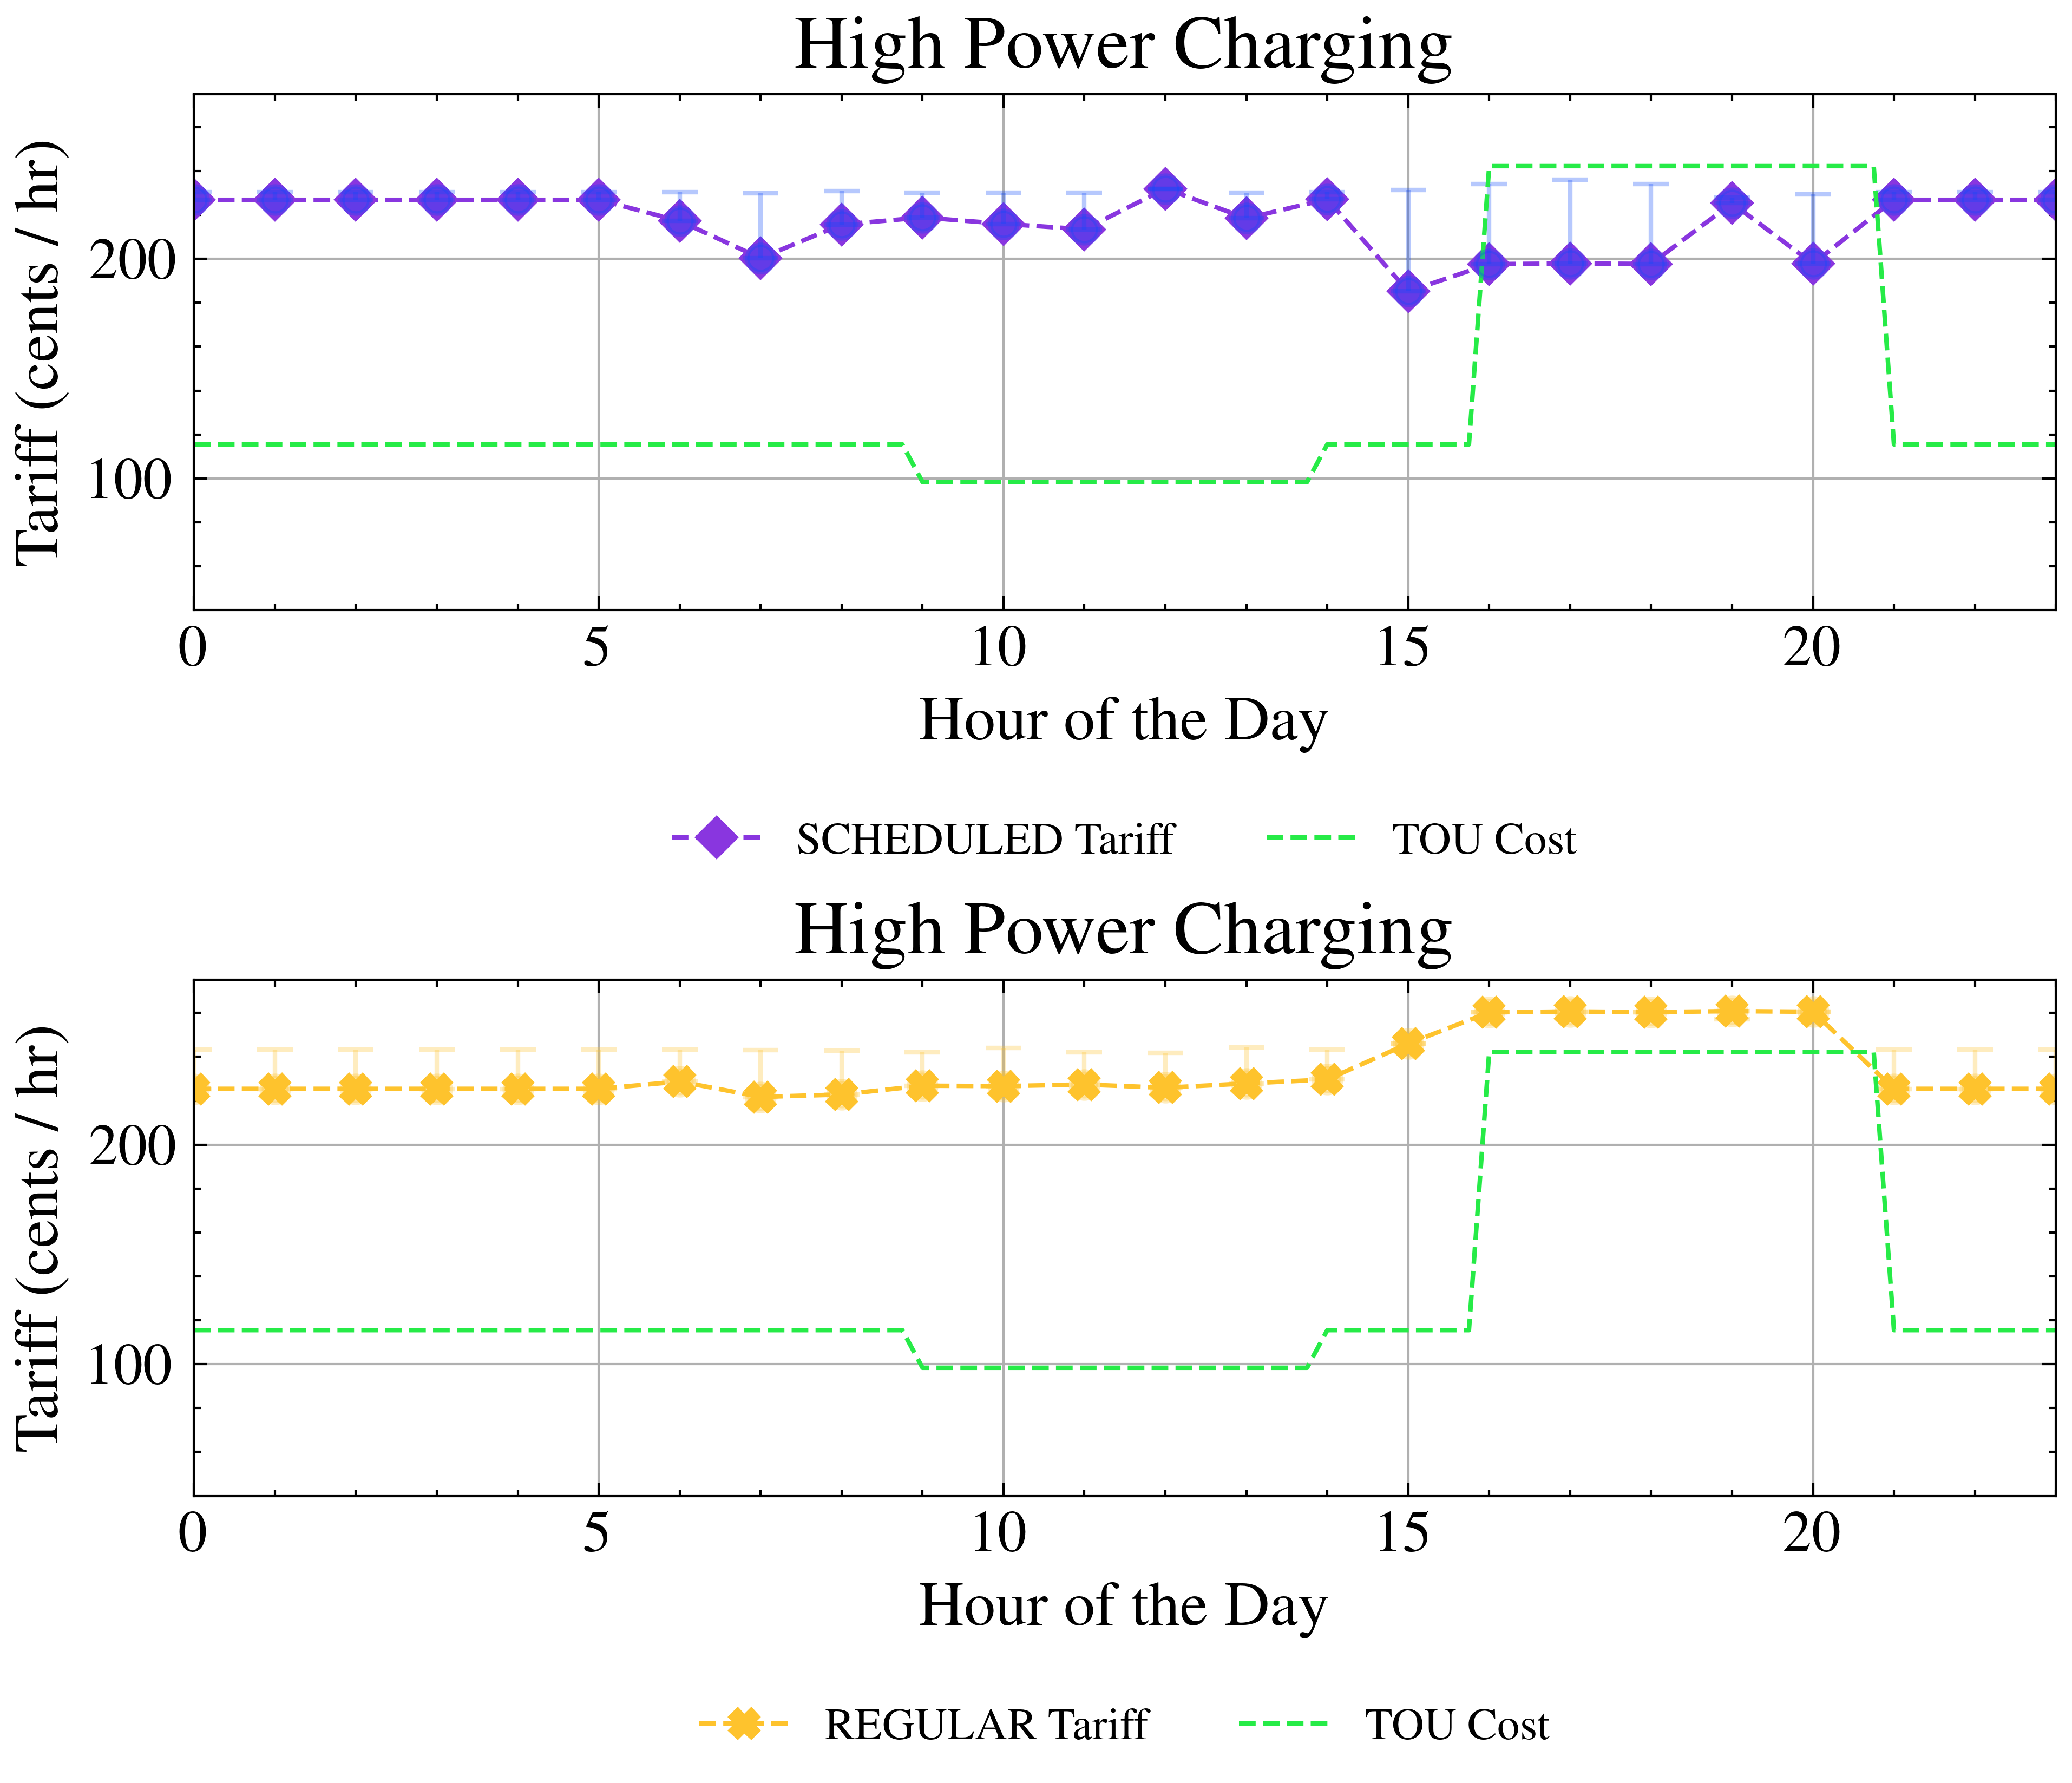

In [12]:
z_range = np.arange(75, 300, 25)
p_function_dict = {} 

for intercept_val in z_range:
    p_function_dict[intercept_val] = {}
    for mean_z in [100, 150, 250]:
        _, _, p_leave = calculate_probability(mean_z,mean_z,
                                leave_intercept = intercept_val, 
                                utility_intercept = parameters[1], 
                                REG_delta_x_coeff = parameters[2], 
                                REG_y_intercept = parameters[3], 
                                SCH_delta_x_coeff = parameters[4],
                                SCH_y_intercept = parameters[5])
    
        p_function_dict[intercept_val][mean_z] = p_leave

## 100, low price, set the probability in [0,20] range
## 150 med price, set the probability in [30,50]
## 200 high price, set the probability in [50,70] 

## keep: 125, 



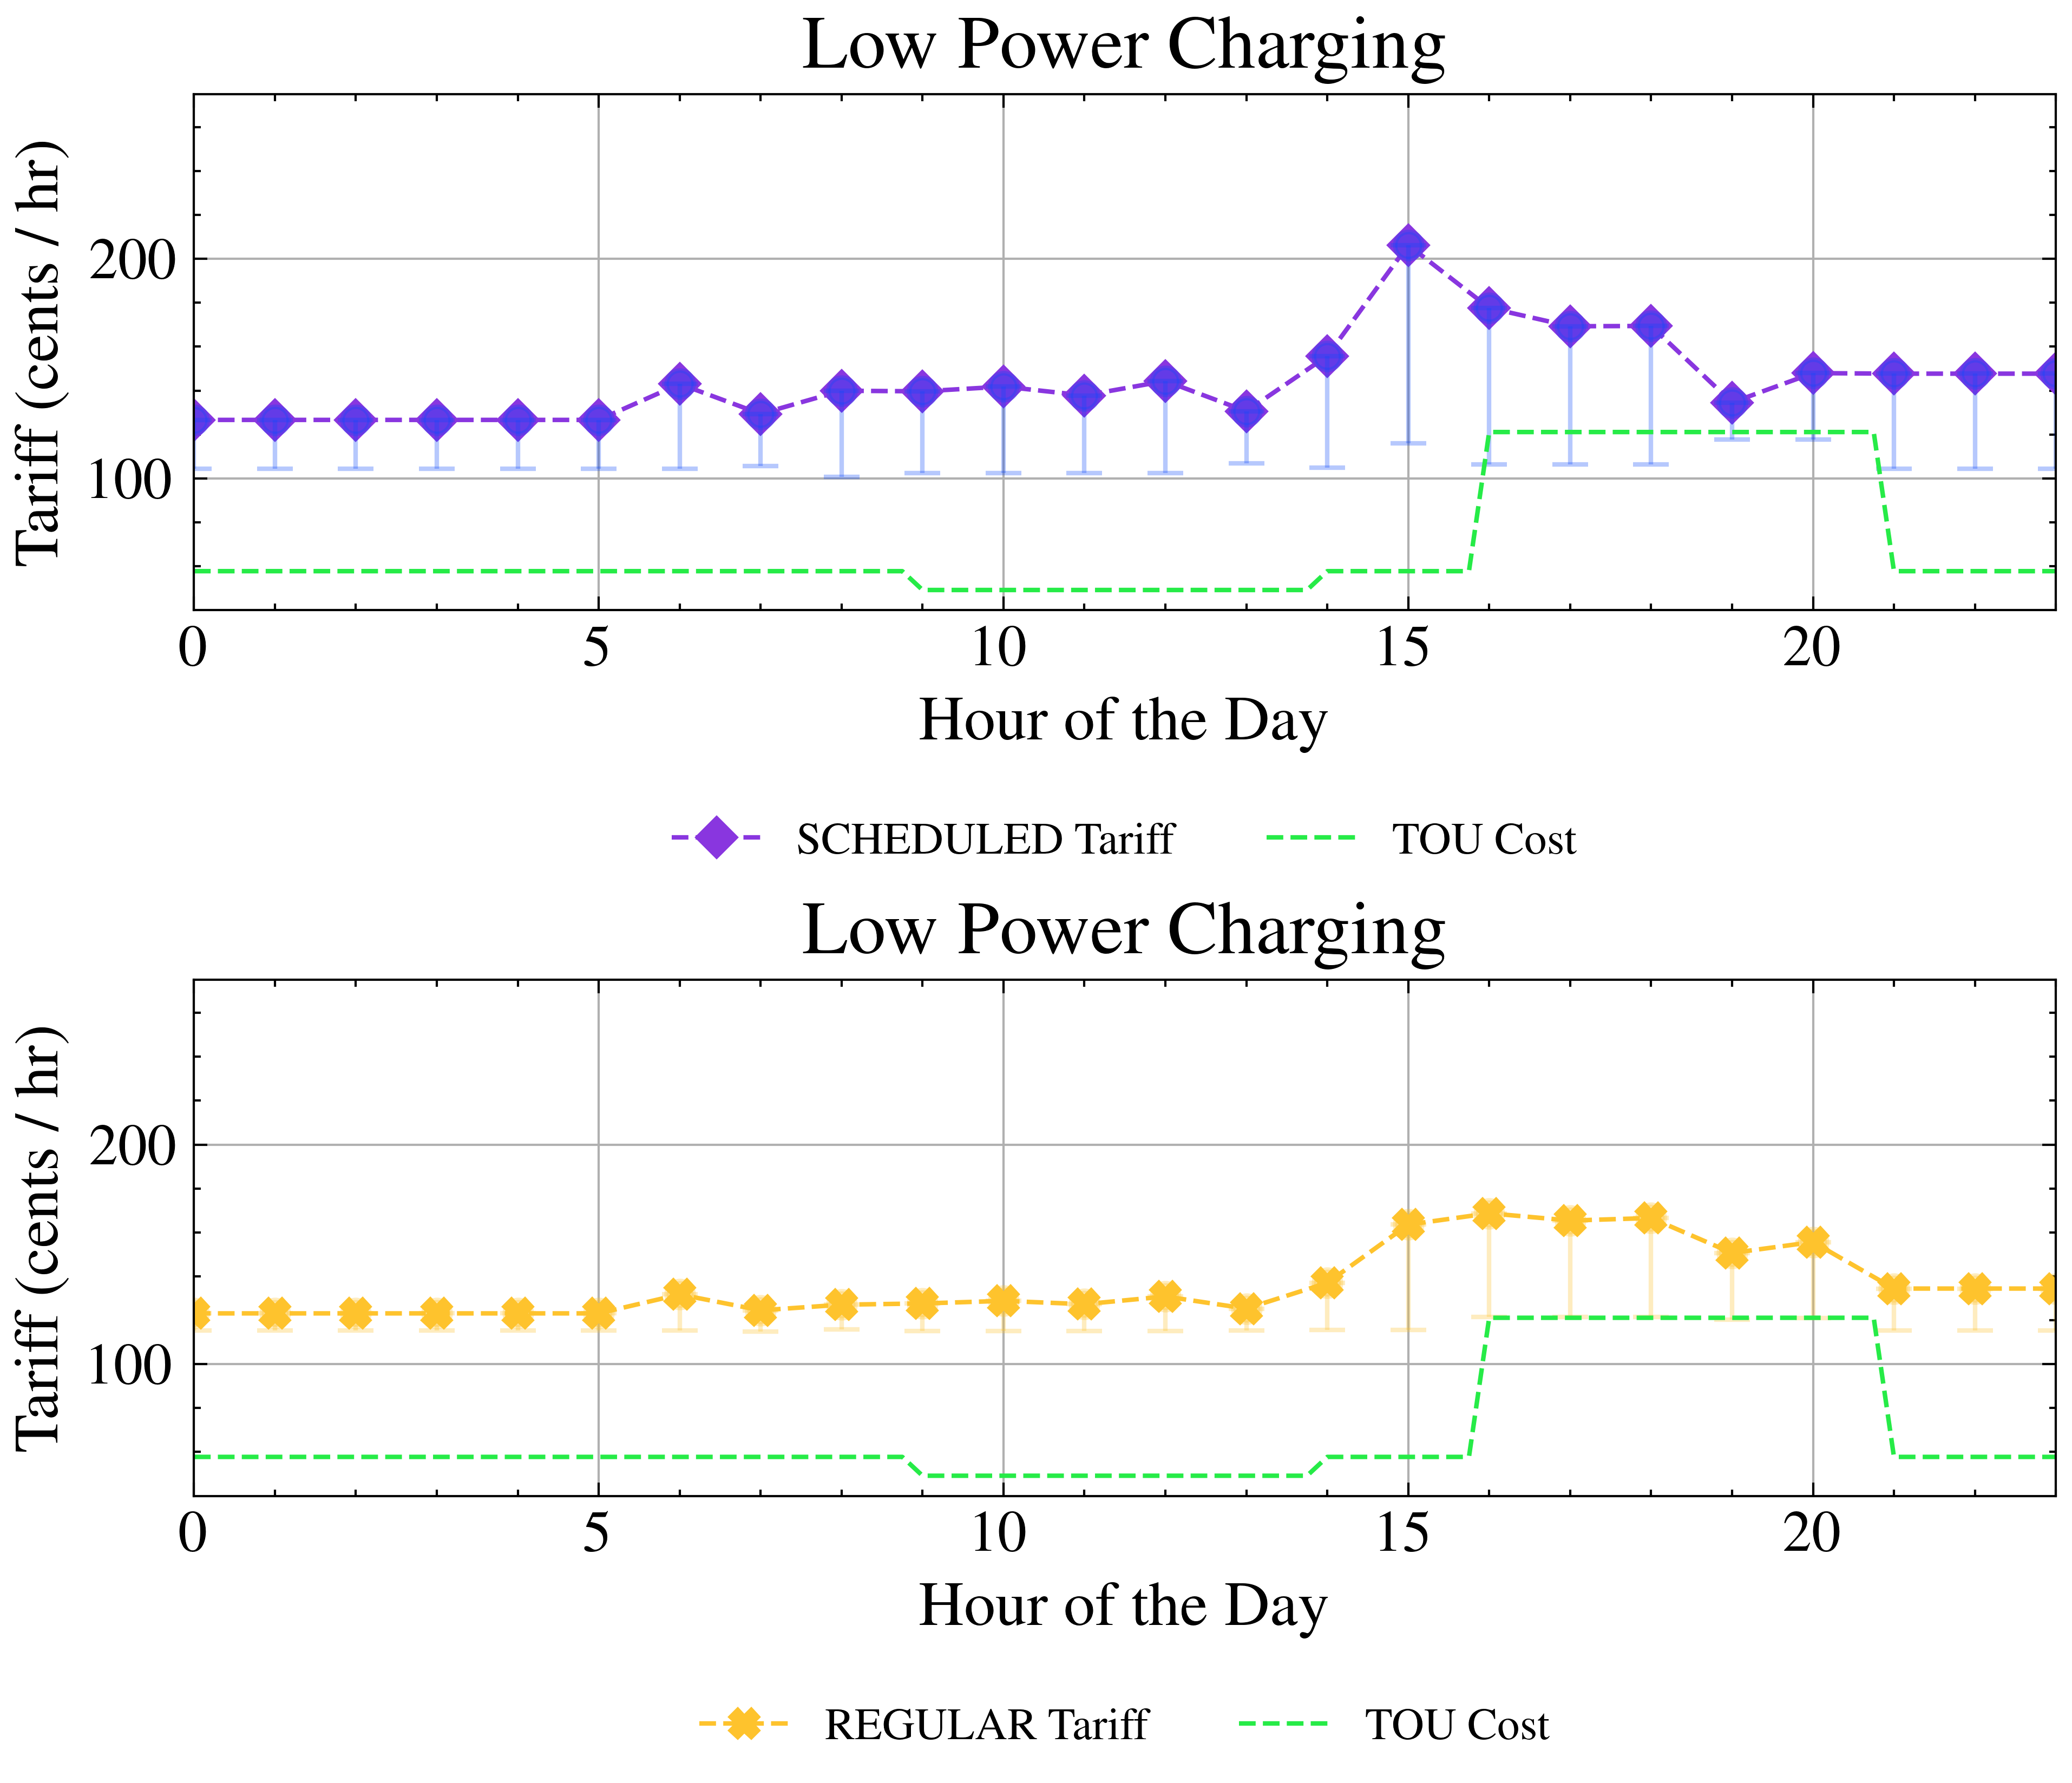

In [133]:
# Check the power profile of the price results
# Check the sensitivty to the DCM parameters of choice
# Read Data

## Plot initial guess vs optimization result 
fig, (ax, ax1)= plt.subplots(2,1,figsize=(w,h * 2))
# Objective Value for each iteration 

arrHour = low_prices['arrHour'].values


ax.plot(arrHour, low_prices['sch_centsPerHr'].values, 
        label = 'SCHEDULED Tariff', 
        marker = 'D',
        linestyle = "--",color=high_vis_map[3])

ax.errorbar(arrHour, low_prices['sch_centsPerHr'].values, yerr=[sch_low_max, sch_low_min], fmt='o', capsize=4, alpha=0.3)


ax1.plot(arrHour, low_prices['reg_centsPerHr'].values, color=high_vis_map[4], label = 'REGULAR Tariff',marker ='X',linestyle = "--")

ax1.errorbar(arrHour, low_prices['reg_centsPerHr'].values, yerr=[reg_low_max, reg_low_min], fmt='o', capsize=4, alpha=0.3, color=high_vis_map[4])



for ax_all in [ax,ax1]:
        ax_all.plot(np.arange(0,24,0.25), low_TOU, label = 'TOU Cost', ms=0,marker ='X',
                linestyle = "--",
        color=high_vis_map[2])
        ax_all.set_ylim(40,275)
        ax_all.set_xlim(0,23)
        ax_all.grid()
        ax_all.set_title("Low Power Charging")
        ax_all.set_xlabel("Hour of the Day")
        ax_all.set_ylabel("Tariff (cents / hr)")
        # ax.set_title("Objective Value")
        # ax.legend(loc = 0)
        ax_all.legend(bbox_to_anchor=(0.5, -0.45), loc='center', ncol=3,fontsize=10)

# fig.savefig('Figures/fig2a.pdf', dpi=300)

## Low power charging, set a different baseline 


{75: {100: 0.36707654611026214,
  150: 0.5304342244254859,
  250: 0.8108006369216981},
 100: {100: 0.2935690837944023,
  150: 0.40658223813128547,
  250: 0.650647726575468},
 125: {100: 0.25386338917571005,
  150: 0.33668272025167384,
  250: 0.5304342244254859},
 150: {100: 0.22944534092504804,
  150: 0.2935690837944023,
  250: 0.4473346340905699},
 175: {100: 0.2130422847468635,
  150: 0.26483858380621644,
  250: 0.3894699041770821},
 200: {100: 0.2013123239156074,
  150: 0.24450961467464863,
  250: 0.34793866316694505},
 225: {100: 0.19252781389692433,
  150: 0.22944534092504804,
  250: 0.3171281393188268},
 250: {100: 0.18571269588832537,
  150: 0.21787170216942955,
  250: 0.2935690837944023},
 275: {100: 0.18027638844226038,
  150: 0.2087200608815704,
  250: 0.27507557811338323}}

In [102]:
if 'sim_name' not in sim_stats_df.columns: 
    sim_stats_df = sim_stats_df.reset_index(drop=False)
    sim_stats_df = sim_stats_df.rename(columns={'index': 'sim_name'})
    sim_stats_df[['Net Revenue (cents)','Revenue (cents)', 'Cost (cents)']] = ( sim_stats_df[['Net Revenue (cents)','Revenue (cents)', 'Cost (cents)']] / 100 ) / 31
    
sim_stats_df['y_intercept'] = sim_stats_df['sim_name'].str.split("-",expand=True)[2].astype(float) * -1
sim_stats_df['x_intercept'] = sim_stats_df['sim_name'].str.split("-",expand=True)[0].str.split("_",expand=True)[3].astype(int)
sim_stats_df['sim_num'] = sim_stats_df['sim_name'].str.split("_",expand=True)[5]



<AxesSubplot: xlabel='y_intercept', ylabel='x_intercept'>

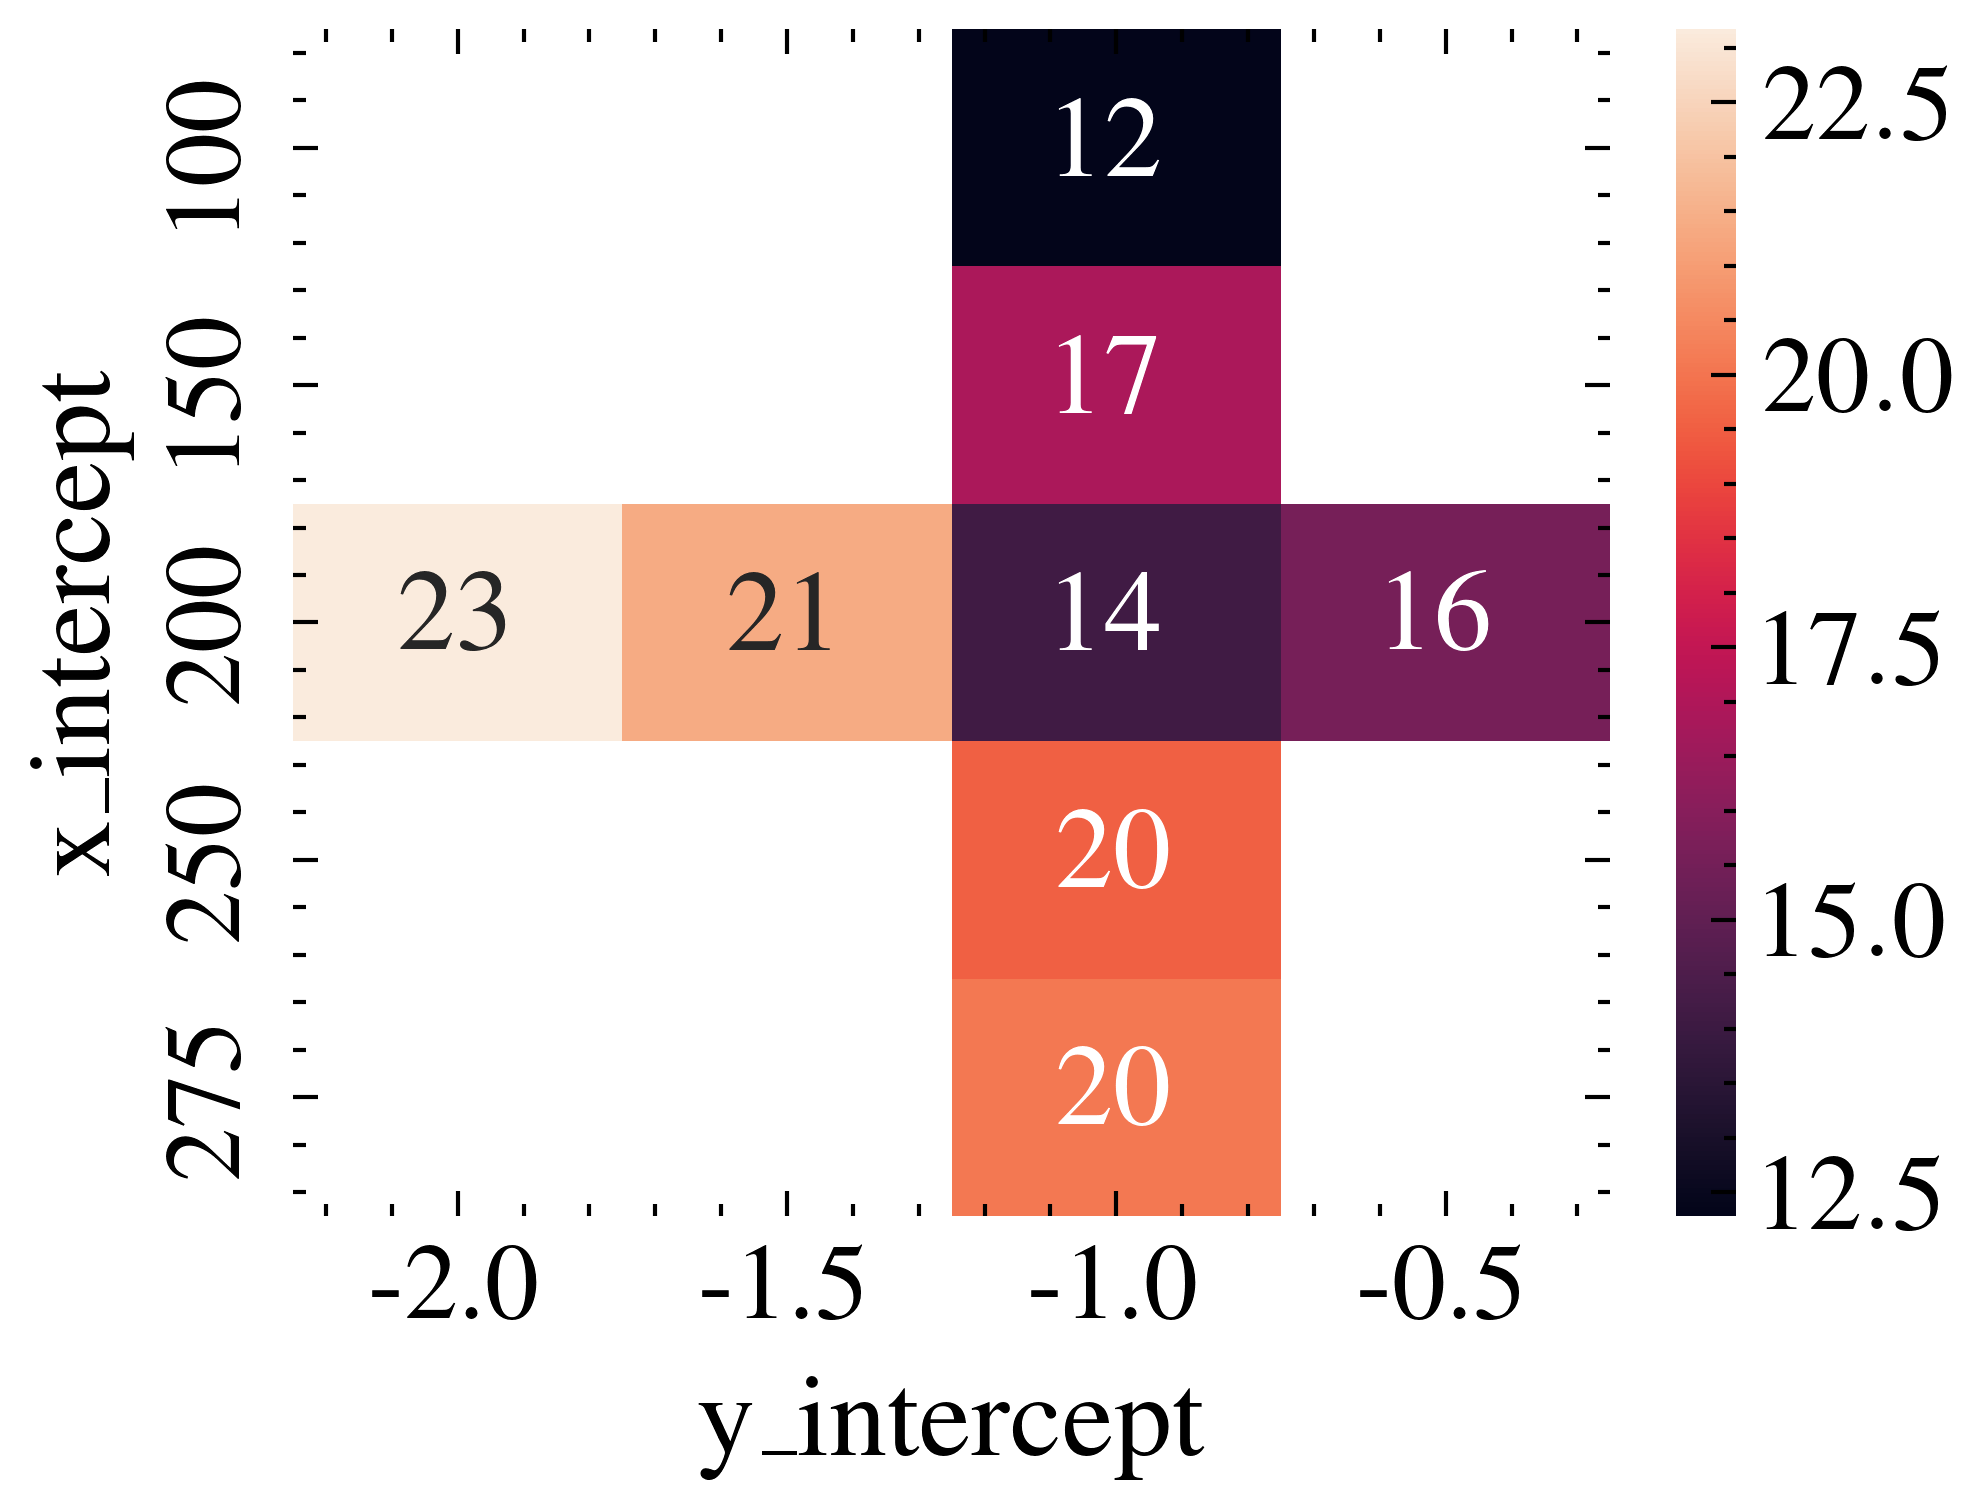

In [105]:

plot_df = sim_stats_df[['x_intercept', 'y_intercept', 'Net Revenue (cents)']].groupby(['x_intercept', 'y_intercept']).mean().reset_index(drop=False)
plot_df = plot_df.pivot('x_intercept', 'y_intercept', 'Net Revenue (cents)')
sns.heatmap(plot_df, annot=True)

In [72]:
calculate_probability(0,0,275,-0.25)

(0.4415584837733671, 0.3139426975416481, 0.24449881868498477)

In [50]:
sim_stats_df.sort_values('Net Revenue (cents)').head(1000)

sim_name Revenue (cents) Cost (cents) Net Revenue (cents)  \
14    y_-0.25_x_100_Sim_5        7.966244     8.327747           -0.361503   
8    y_-0.25_x_100_Sim_17        7.544717     7.882957           -0.338239   
5    y_-0.25_x_100_Sim_14        9.240358     8.874505            0.365853   
4    y_-0.25_x_100_Sim_13        9.549042     8.893468            0.655574   
12    y_-0.25_x_100_Sim_3        9.907075     8.969388            0.937687   
..                    ...             ...          ...                 ...   
262   y_-1.25_x_250_Sim_6       30.288719    11.552608           18.736111   
370   y_-1.5_x_275_Sim_18       30.389294    11.639514           18.749781   
367   y_-1.5_x_275_Sim_15       30.500894     11.74927           18.751624   
349   y_-1.5_x_250_Sim_16       30.390943    11.553768           18.837176   
365   y_-1.5_x_275_Sim_13       31.502953    12.298302           19.204651   

     y_intercept  x_intercept sim_num  
14         -0.25          100       5  
8          -0.25          100      17  
5          -0.25          100      14  
4          -0.25          100      13  
12         -0.25          100       3  
..           ...          ...     ...  
262        -1.25          250       6  
370        -1.50          275      18  
367        -1.50          275      15  
349        -1.50          250      16  
365        -1.50          275      13  

[475 rows x 7 columns]

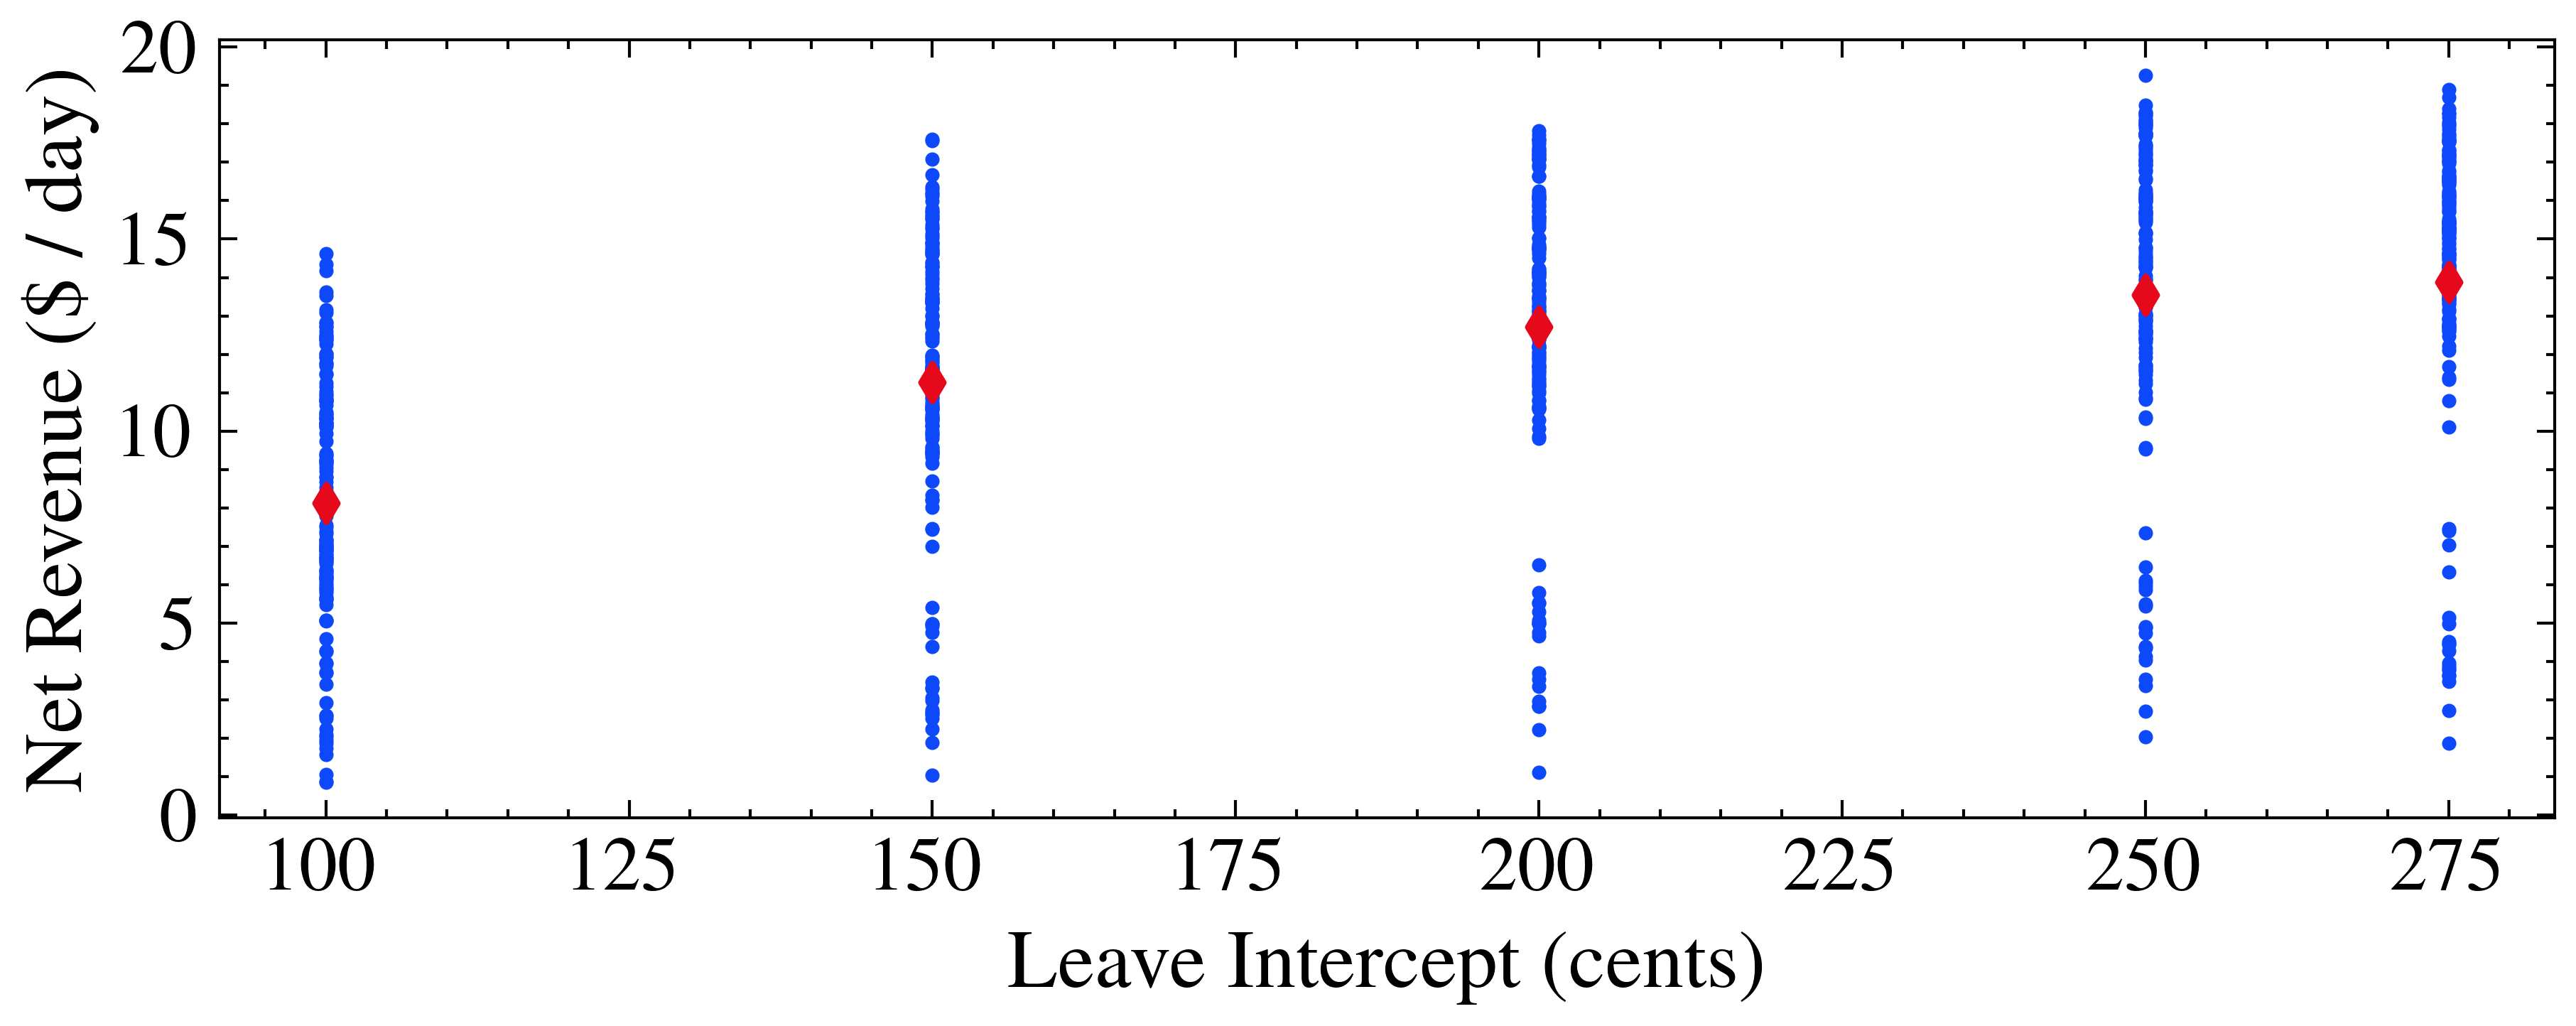

In [85]:
# sim_stats_df['intercept'] = sim_stats_df['sim_name'].str.split("_",expand=True)[1]

means = sim_stats_df[['x_intercept', 'Net Revenue (cents)']].groupby(['x_intercept']).mean().reset_index(drop=False)

x = sim_stats_df['x_intercept']
y = (sim_stats_df['Net Revenue (cents)'])
fig,ax = plt.subplots(1,1,figsize=( w ,h), tight_layout = False)
ax.set_xlabel("Leave Intercept (cents)")
ax.set_ylabel("Net Revenue (\$ / day)")
ax.scatter(x,y,s=2)
ax.scatter(means['x_intercept'],means['Net Revenue (cents)'],marker="d",s=20,label='mean')




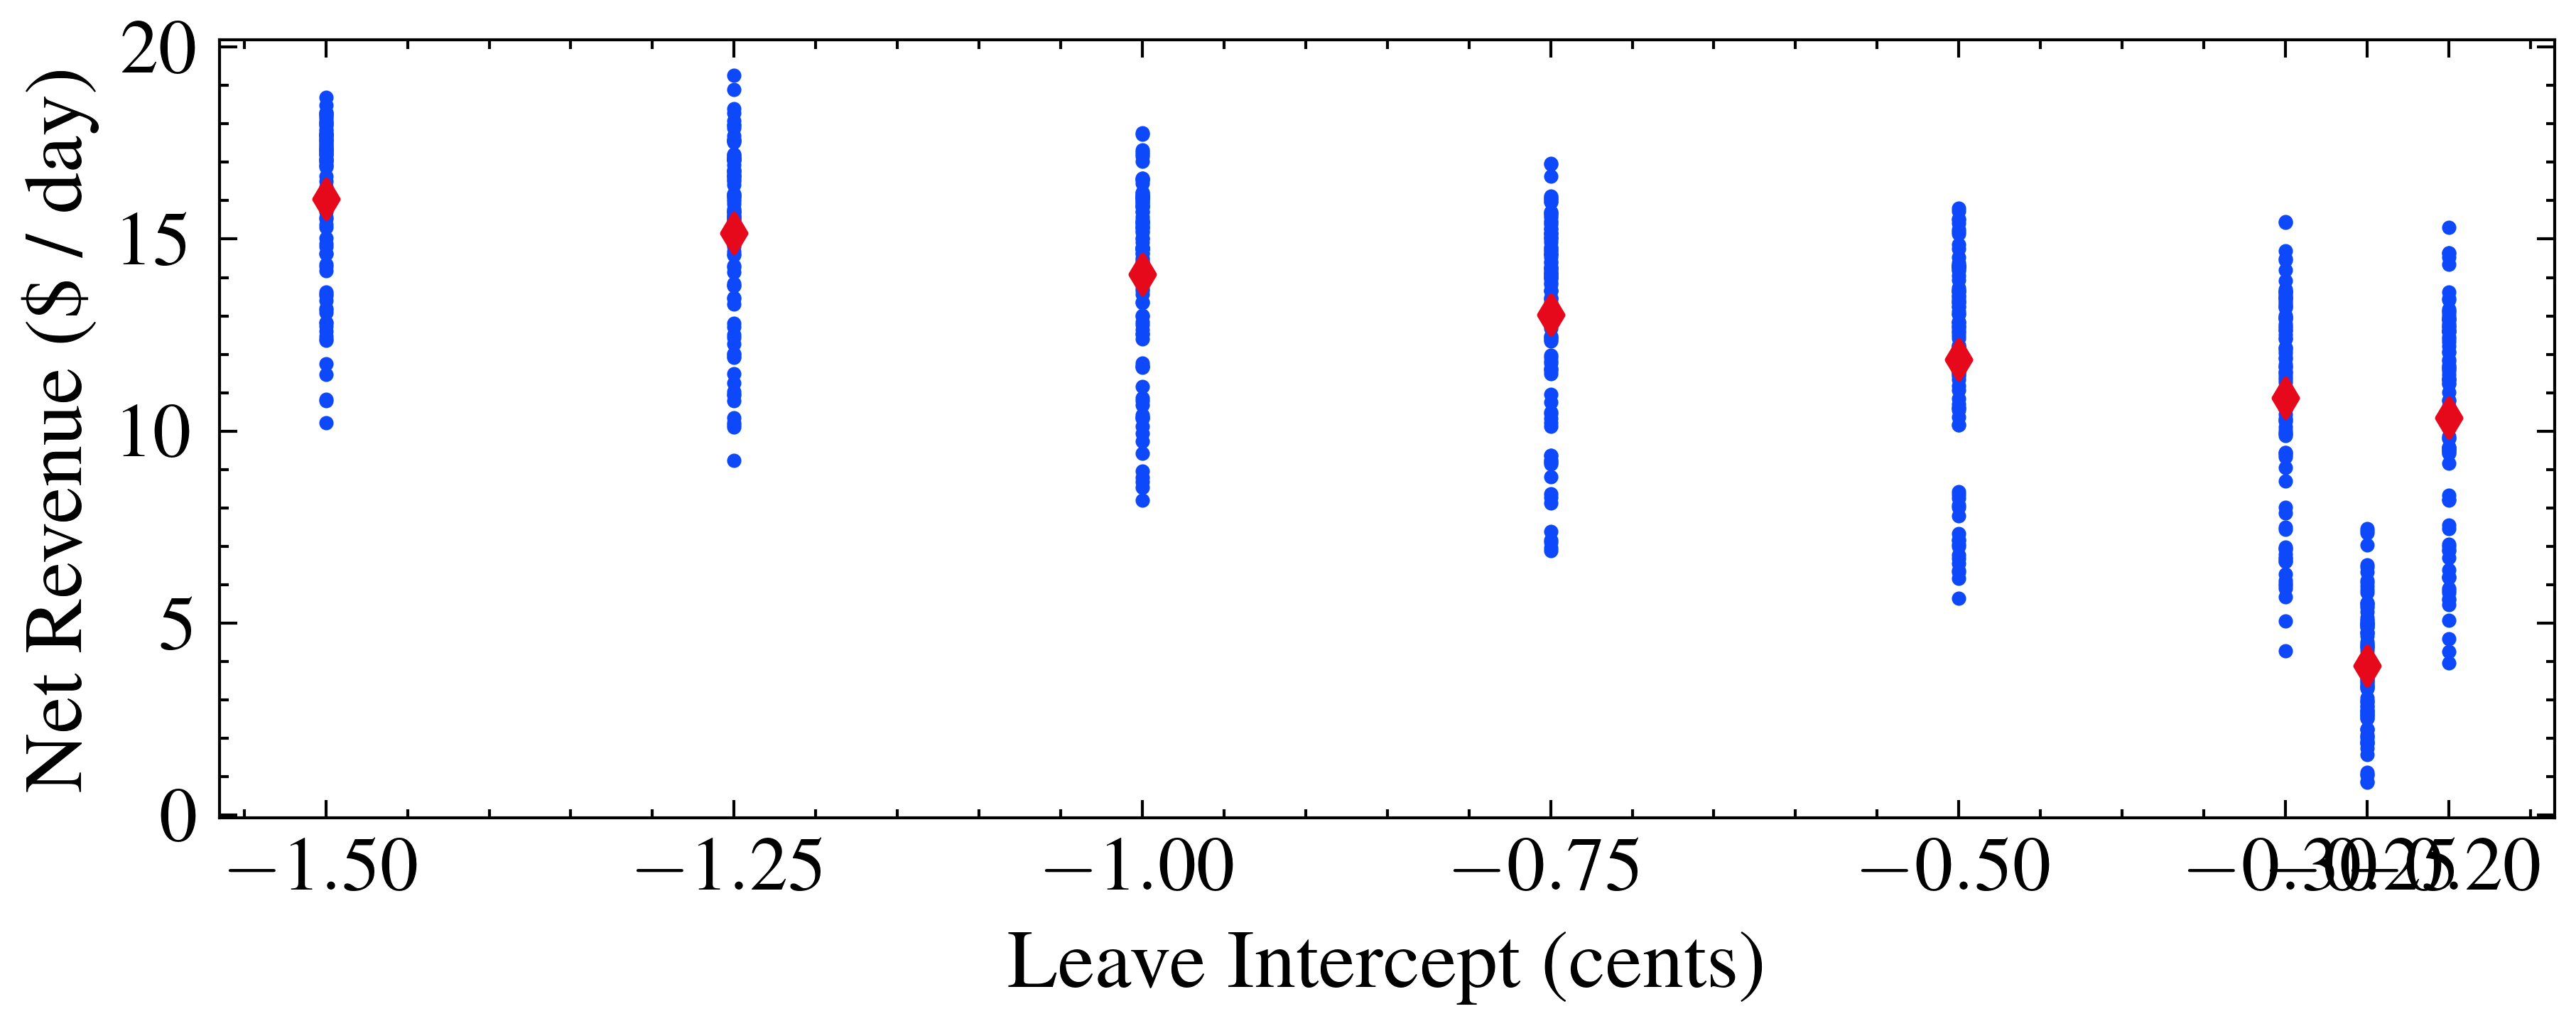

In [86]:
means = sim_stats_df[['y_intercept', 'Net Revenue (cents)']].groupby(['y_intercept']).mean().reset_index(drop=False)

x = sim_stats_df['y_intercept']
y = (sim_stats_df['Net Revenue (cents)'])
fig,ax = plt.subplots(1,1,figsize=( w ,h), tight_layout = False)
ax.set_xticks(np.sort(x.unique()))
ax.set_xlabel("Leave Intercept (cents)")
ax.set_ylabel("Net Revenue (\$ / day)")
ax.scatter(x,y,s=2)
ax.scatter(means['y_intercept'],means['Net Revenue (cents)'],marker="d",s=20,label='mean')



# sim_stats_df['intercept'] = sim_stats_df['sim_name'].str.split("_",expand=True)[1]




array([-1.5 , -1.25, -1.  , -0.5 , -0.25])

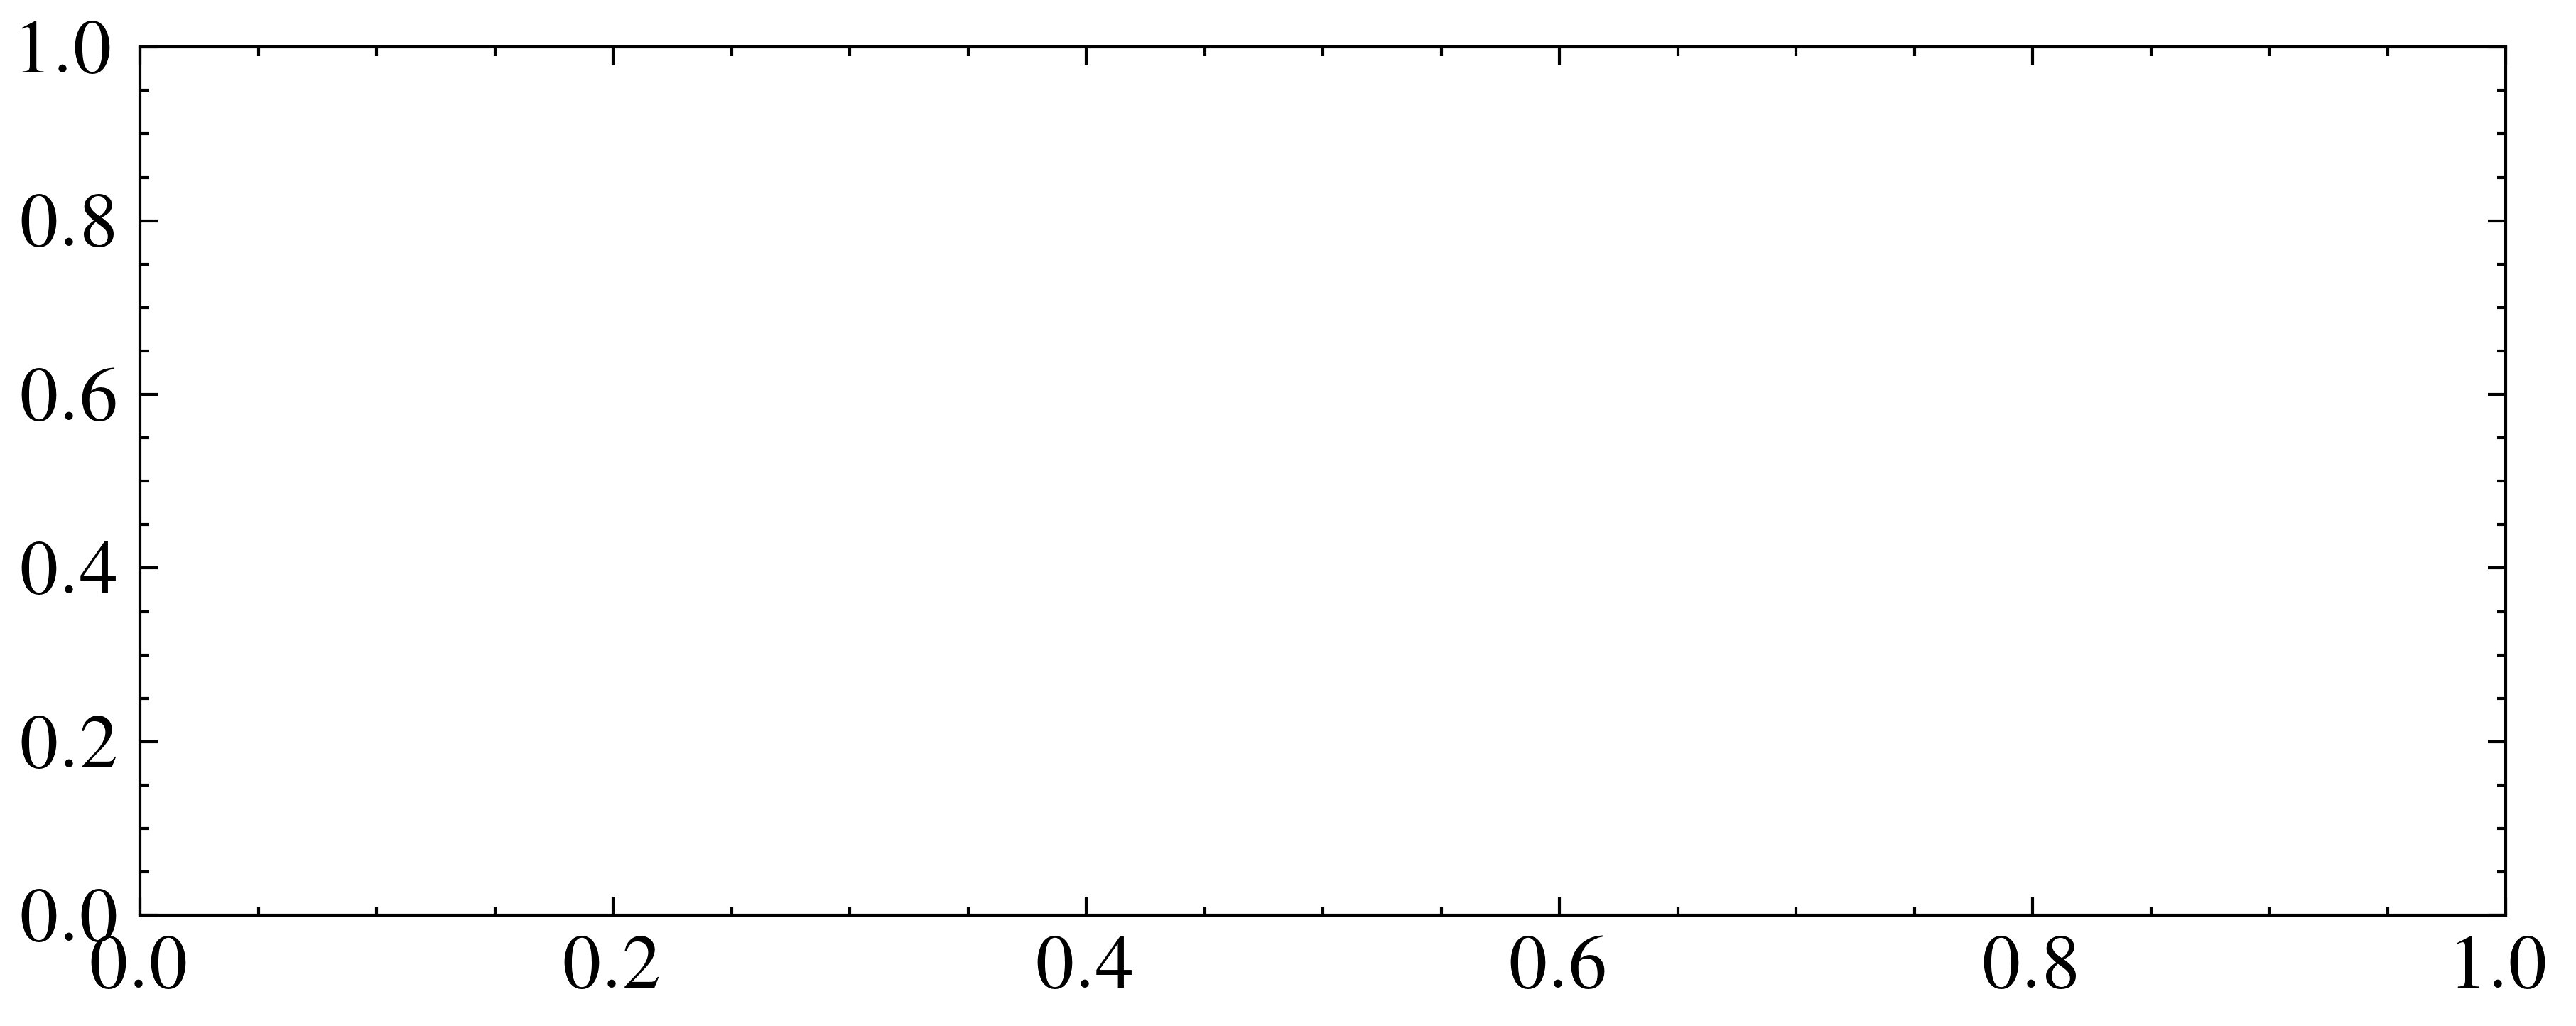

In [62]:
fig,ax = plt.subplots(1,1,figsize=( w,h), tight_layout = False)



In [26]:
def calculate_probability(z_reg, z_sch, leave_intercept = 200, utility_intercept = -1):
    u_reg =  0.3411 -0.0184*(z_sch - z_reg)*.5
    u_sch = 0.0184*(z_sch - z_reg)*.5

    coeff = 1 / leave_intercept
    u_leave = utility_intercept + coeff * (np.mean([z_sch, z_reg]))
    
#     print(u_leave, u_sch, u_reg)
    denom = np.exp(u_reg) + np.exp(u_sch) + np.exp(u_leave)

    p_reg = np.exp(u_reg) / denom
    p_sch = np.exp(u_sch) / denom
    p_leave = np.exp(u_leave) / denom

#     print(p_reg, p_sch, p_leave, np.sum([p_reg, p_sch, p_leave]))
    return p_reg, p_sch, p_leave

In [28]:
for i in [100,150,200,250]:
    print(calculate_probability(150, 150, leave_intercept = i, utility_intercept = -1))


(0.34683582247398637, 0.24659604041816177, 0.40656813710785183)
(0.41288607331638094, 0.29355696334180953, 0.29355696334180953)
(0.4415584837733671, 0.3139426975416481, 0.24449881868498477)
(0.4571267276989091, 0.3250115291315301, 0.21786174316956078)


In [22]:
for i in [0, -.25, -.5, -1, -1.25, -1.5, -2]:
    print(calculate_probability(150, 150, leave_intercept = 200, utility_intercept = i))


165.0